In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import warnings
import numpy as np
import pandas as pd
import os, random, collections, re, pickle
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn, torch.optim as optim, torch.nn.functional as F
import matplotlib.pyplot as plt

# suppress warnings
warnings.filterwarnings("ignore")

In [ ]:
# 2) Data Preprocessing: Clean and split dataset

# Define file paths
EXCEL_PATH = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/dataset/CDFT DATA -Updated Final.xlsx"
CLEAN_PATH = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/dataset/CDFT_DATA_cleaned.csv"
GLOBAL_PATH = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/dataset/CDFT_GLOBAL.csv"
ATOM_PATH   = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/dataset/CDFT_ATOM.csv"
TRAIN_CSV   = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/dataset/train_dataset.csv"
VAL_CSV     = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/dataset/val_dataset.csv"

# Load the original Excel dataset
df = pd.read_excel(EXCEL_PATH, sheet_name=0)

#Only clean obvious NaNs without propagating values into unrelated rows
df_cleaned = df.copy()
df_cleaned = df_cleaned.dropna(how="all")  # drop completely empty rows
df_cleaned = df_cleaned.drop_duplicates()  # remove duplicates

# Save cleaned combined dataset
df_cleaned.to_csv(CLEAN_PATH, index=False)

# Split into GLOBAL and ATOM-level CSVs (neutral radicals only)
last_global = "Electrophilicity"
idx = df_cleaned.columns.get_loc(last_global)
global_cols = df_cleaned.columns[:idx+1].tolist()
atom_cols   = df_cleaned.columns[idx+1:].tolist()

# Helper functions to normalize names
def norm_key(x):
    if pd.isna(x): return None
    return re.sub(r"\s+", " ", str(x).strip().lower())

def base_name(x):
    if pd.isna(x): return None
    s = str(x).strip()
    s = re.sub(r"\s+", " ", s)
    return re.sub(r"(?i)_(anion|cation)\s*$", "", s)  # strip _anion/_cation suffixes

# 1) Collect explicit radical names, exclude ion suffixes
explicit_names = df_cleaned["Radical name"].dropna().astype(str).str.strip()
explicit_names = explicit_names[explicit_names != ""]
neutral_series = explicit_names[~explicit_names.str.contains(r"(?i)_(anion|cation)\b", regex=True)]

# Build unique neutral radical keys
seen, neutral_keys, canonical_names = set(), [], []
for name in neutral_series:
    key = norm_key(name)
    if key and key not in seen:
        seen.add(key)
        neutral_keys.append(key)
        canonical_names.append(name)
key_to_name = dict(zip(neutral_keys, canonical_names))

# 2) Build GLOBAL table for neutrals
name_key_series = df_cleaned["Radical name"].map(norm_key)
global_rows = []
for key in neutral_keys:
    idxs = df_cleaned.index[name_key_series == key]
    if len(idxs) == 0:
        continue
    first_idx = idxs[0]
    row_vals = df_cleaned.loc[first_idx, global_cols]
    out_row = row_vals.copy()
    out_row["Radical name"] = key_to_name[key]
    global_rows.append(out_row)

global_df = pd.DataFrame(global_rows)
gcols = ["Radical name"] + [c for c in global_cols if c != "Radical name"]
global_df = global_df[gcols]
global_df["_key"] = global_df["Radical name"].map(norm_key)
global_df = global_df.drop_duplicates(subset="_key", keep="first").drop(columns="_key").reset_index(drop=True)

# 3) Build ATOM table for neutrals
df_cleaned["rad_group"] = df_cleaned["Radical name"]  # no forward fill!
rad_key = df_cleaned["rad_group"].map(base_name).map(norm_key)
atom_mask = rad_key.isin(set(neutral_keys)) & df_cleaned["Atom"].notna()
atom_df = df_cleaned.loc[atom_mask, ["rad_group"] + atom_cols].copy()
atom_df["_key"] = atom_df["rad_group"].map(base_name).map(norm_key)
atom_df["Radical name"] = atom_df["_key"].map(key_to_name)
atom_df = atom_df.drop(columns=["rad_group", "_key"]).reset_index(drop=True)
atom_df = atom_df[["Radical name"] + atom_cols]

# Save GLOBAL and ATOM CSVs
global_df.to_csv(GLOBAL_PATH, index=False)
atom_df.to_csv(ATOM_PATH, index=False)


In [ ]:
# 2) Data Preprocessing: Clean and split dataset

# Define file paths
EXCEL_PATH = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/dataset/CDFT DATA -Updated Final.xlsx"
CLEAN_PATH = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/dataset/CDFT_DATA_cleaned.csv"
GLOBAL_PATH = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/dataset/CDFT_GLOBAL.csv"
ATOM_PATH   = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/dataset/CDFT_ATOM.csv"
TRAIN_CSV   = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/dataset/train_dataset.csv"
VAL_CSV     = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/dataset/val_dataset.csv"

# Load the original Excel dataset
df = pd.read_excel(EXCEL_PATH, sheet_name=0)

#Only clean obvious NaNs without propagating values into unrelated rows
df_cleaned = df.copy()
df_cleaned = df_cleaned.dropna(how="all")  # drop completely empty rows
df_cleaned = df_cleaned.drop_duplicates()  # remove duplicates

# Save cleaned combined dataset
df_cleaned.to_csv(CLEAN_PATH, index=False)

# Split into GLOBAL and ATOM-level CSVs (neutral radicals only)
last_global = "Electrophilicity"
idx = df_cleaned.columns.get_loc(last_global)
global_cols = df_cleaned.columns[:idx+1].tolist()
atom_cols   = df_cleaned.columns[idx+1:].tolist()

# Helper functions to normalize names
def norm_key(x):
    if pd.isna(x): return None
    return re.sub(r"\s+", " ", str(x).strip().lower())

def base_name(x):
    if pd.isna(x): return None
    s = str(x).strip()
    s = re.sub(r"\s+", " ", s)
    return re.sub(r"(?i)_(anion|cation)\s*$", "", s)  # strip _anion/_cation suffixes

# 1) Collect explicit radical names, exclude ion suffixes
explicit_names = df_cleaned["Radical name"].dropna().astype(str).str.strip()
explicit_names = explicit_names[explicit_names != ""]
neutral_series = explicit_names[~explicit_names.str.contains(r"(?i)_(anion|cation)\b", regex=True)]

# Build unique neutral radical keys
seen, neutral_keys, canonical_names = set(), [], []
for name in neutral_series:
    key = norm_key(name)
    if key and key not in seen:
        seen.add(key)
        neutral_keys.append(key)
        canonical_names.append(name)
key_to_name = dict(zip(neutral_keys, canonical_names))

# 2) Build GLOBAL table for neutrals
name_key_series = df_cleaned["Radical name"].map(norm_key)
global_rows = []
for key in neutral_keys:
    idxs = df_cleaned.index[name_key_series == key]
    if len(idxs) == 0:
        continue
    first_idx = idxs[0]
    row_vals = df_cleaned.loc[first_idx, global_cols]
    out_row = row_vals.copy()
    out_row["Radical name"] = key_to_name[key]
    global_rows.append(out_row)

global_df = pd.DataFrame(global_rows)
gcols = ["Radical name"] + [c for c in global_cols if c != "Radical name"]
global_df = global_df[gcols]
global_df["_key"] = global_df["Radical name"].map(norm_key)
global_df = global_df.drop_duplicates(subset="_key", keep="first").drop(columns="_key").reset_index(drop=True)

# 3) Build ATOM table for neutrals
df_cleaned["rad_group"] = df_cleaned["Radical name"]  # no forward fill!
rad_key = df_cleaned["rad_group"].map(base_name).map(norm_key)
atom_mask = rad_key.isin(set(neutral_keys)) & df_cleaned["Atom"].notna()
atom_df = df_cleaned.loc[atom_mask, ["rad_group"] + atom_cols].copy()
atom_df["_key"] = atom_df["rad_group"].map(base_name).map(norm_key)
atom_df["Radical name"] = atom_df["_key"].map(key_to_name)
atom_df = atom_df.drop(columns=["rad_group", "_key"]).reset_index(drop=True)
atom_df = atom_df[["Radical name"] + atom_cols]

# Save GLOBAL and ATOM CSVs
global_df.to_csv(GLOBAL_PATH, index=False)
atom_df.to_csv(ATOM_PATH, index=False)


In [ ]:
# Electrophilicity range + radical name checks

def check_electrophilicity(df, name="dataset"):
    if "Electrophilicity" in df.columns and "Radical name" in df.columns:
        min_val = df["Electrophilicity"].min()
        max_val = df["Electrophilicity"].max()
        min_idx = df["Electrophilicity"].idxmin()
        max_idx = df["Electrophilicity"].idxmax()
        min_name = df.loc[min_idx, "Radical name"]
        max_name = df.loc[max_idx, "Radical name"]
        print(f"[check] {name}: Electrophilicity range = {min_val:.3f} → {max_val:.3f}")
        print(f"         min at '{min_name}' ({min_val:.3f}), max at '{max_name}' ({max_val:.3f})")
    else:
        print(f"[check] {name}: missing 'Electrophilicity' or 'Radical name' column")

# Run checks for both GLOBAL and ATOM datasets
check_electrophilicity(global_df, name="global_df")
check_electrophilicity(atom_df,   name="atom_df")


[check] global_df: Electrophilicity range = 0.569 → 12.961
         min at '1bis_propan_2yl_amino_ethyl' (0.569), max at 'chloryl' (12.961)
[check] atom_df: missing 'Electrophilicity' or 'Radical name' column


In [ ]:
#Consistency check

before = len(atom_df)
merged = pd.merge(atom_df, global_df, on="Radical name", how="inner")
after = len(merged)

print(f"atom_df rows: {before}, merged rows: {after}")
missing = set(atom_df["Radical name"]) - set(global_df["Radical name"])
print(f"Radicals in atom_df but not in global_df: {missing}")


atom_df rows: 487, merged rows: 487
Radicals in atom_df but not in global_df: set()


In [ ]:
# Train-Test Splitting
# Merge global + atom-level features

merged = pd.merge(atom_df, global_df, on="Radical name", how="inner")

# Split into train/validation
train_df, val_df = train_test_split(
    merged, test_size=0.2, random_state=42, shuffle=True
)

# Save splits
train_df.to_csv(TRAIN_CSV, index=False)
val_df.to_csv(VAL_CSV, index=False)

print(f"Train rows: {len(train_df)}, Val rows: {len(val_df)}")


Train rows: 389, Val rows: 98


In [ ]:
#Merged Train-Test datasets for later uses

BASE_DIR = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
TRAIN_CSV = os.path.join(BASE_DIR, "dataset", "train_dataset.csv")
VAL_CSV   = os.path.join(BASE_DIR, "dataset", "val_dataset.csv")
MERGED_CSV = os.path.join(BASE_DIR, "dataset", "MERGED_CDFT_GLOBAL.csv")

# Load
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)

# Merge
merged_df = pd.concat([train_df, val_df], axis=0).reset_index(drop=True)

# Randomize order
merged_df = merged_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Save to global dataset
merged_df.to_csv(MERGED_CSV, index=False)

print(f"Merged dataset saved → {MERGED_CSV}")
print(f"Rows: {len(merged_df)} | Columns: {len(merged_df.columns)}")


Merged dataset saved → /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/dataset/MERGED_CDFT_GLOBAL.csv
Rows: 487 | Columns: 24


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Searching 20 configs of candidates. Success threshold = 0.02

=== Running td3_h64_lr5e-05_gm0.99_pn0.02_pd2 ===
td3_h64_lr5e-05_gm0.99_pn0.02_pd2: Success rate = 0.500, Mean final |ω-1| = 0.4722
→ Saved new best checkpoint: td3_h64_lr5e-05_gm0.99_pn0.02_pd2

=== Running td3_h64_lr5e-05_gm0.99_pn0.02_pd3 ===
td3_h64_lr5e-05_gm0.99_pn0.02_pd3: Success rate = 0.445, Mean final |ω-1| = 0.5221

=== Running td3_h64_lr5e-05_gm0.99_pn0.05_pd2 ===
td3_h64_lr5e-05_gm0.99_pn0.05_pd2: Success rate = 0.435, Mean final |ω-1| = 0.5459

=== Running td3_h64_lr5e-05_gm0.99_pn0.05_pd3 ===
td3_h64_lr5e-05_gm0.99_pn0.05_pd3: Success rate = 0.600, Mean final |ω-1| = 0.1205
→ Saved new best checkpoint: td3_h64_lr5e-05_gm0.99_pn0.05_pd3

=== Running td3_h64_lr1e-04_gm0.99_pn0.02_pd2 ===
td3_h64_lr1e-04_gm0.99_pn0.02_pd2: Success rate = 0.520, Mean final |ω-1| = 0.4659

=== Running t

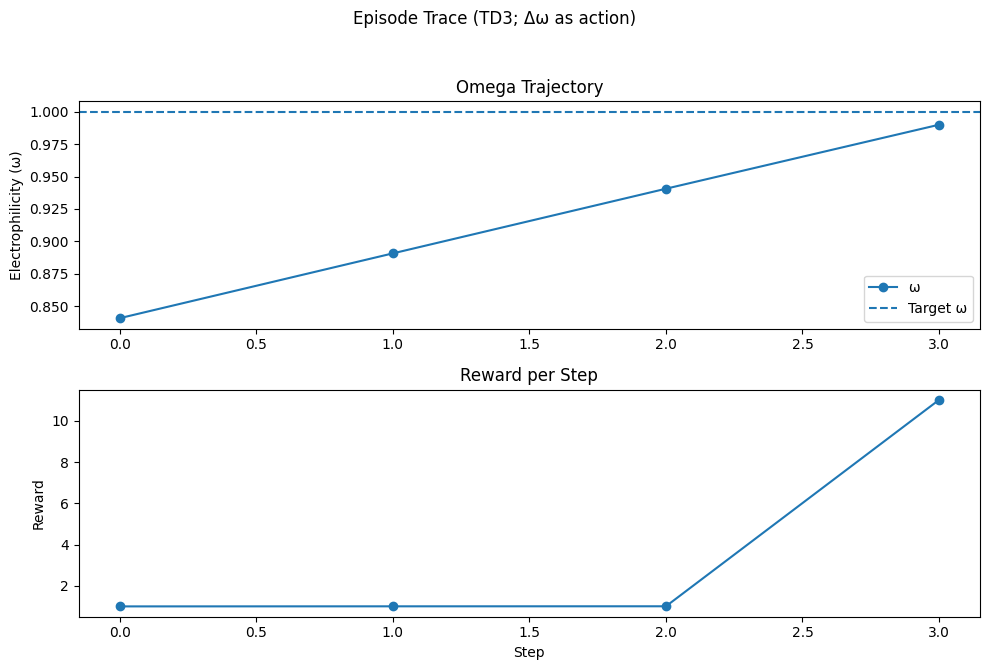

Saved episode trace to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/episode_trace_best_td3.png


In [ ]:
# Reproducibility & Paths

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# Safe Colab mount (ignored elsewhere)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

BASE_DIR    = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
TRAIN_CSV   = os.path.join(BASE_DIR, "dataset", "train_dataset.csv")
VAL_CSV     = os.path.join(BASE_DIR, "dataset", "val_dataset.csv")
RESULTS_DIR = os.path.join(BASE_DIR, "Results")
PLOTS_DIR   = os.path.join(BASE_DIR, "plots")
os.makedirs(RESULTS_DIR, exist_ok=True); os.makedirs(PLOTS_DIR, exist_ok=True)

STATE_COLUMNS = [
    'Electronegativity','Hardness','Electrophilicity','q(N)',
    'f-','f+','f0','s-','s+','s0','s+/s-','s-/s+','s(2)'
]
OMEGA_COL = 'Electrophilicity'


# Preprocessing

def _safe_ratio(num, den, eps=1e-8):
    n = np.asarray(num, dtype=np.float64)
    d = np.asarray(den, dtype=np.float64)
    return (n) / (np.sign(d) * np.maximum(np.abs(d), eps))

def preprocess_dataframe(df: pd.DataFrame, fit_scaler=False, scaler=None):
    df = df.copy()
    missing = [c for c in STATE_COLUMNS if c not in df.columns]
    for c in missing: df[c] = np.nan

    if 's+/s-' not in df.columns:
        df['s+/s-'] = _safe_ratio(df.get('s+', 0.0), df.get('s-', 1.0))
    if 's-/s+' not in df.columns:
        df['s-/s+'] = _safe_ratio(df.get('s-', 0.0), df.get('s+', 1.0))

    df[STATE_COLUMNS] = df[STATE_COLUMNS].ffill().bfill()
    df['f-'] = df['f-'].clip(-1.0, 1.0)
    df['f+'] = df['f+'].clip(-1.0, 1.0)
    df['f0'] = df['f0'].clip(-1.0, 1.0)
    df[OMEGA_COL] = df[OMEGA_COL].clip(0.0, 6.5)
    df = df[STATE_COLUMNS]

    if fit_scaler:
        mu = df.mean(numeric_only=True)
        sd = df.std(numeric_only=True).replace(0.0, 1.0)
        scaler = {'mu': mu, 'sd': sd}
    mu = scaler['mu'] if scaler else df.mean(numeric_only=True)
    sd = scaler['sd'] if scaler else df.std(numeric_only=True).replace(0.0, 1.0)

    df_scaled = (df - mu) / sd
    df_scaled['_omega_unscaled'] = df[OMEGA_COL].values.astype(np.float32)
    df_scaled['_omega_mu'] = mu[OMEGA_COL]
    df_scaled['_omega_sd'] = sd[OMEGA_COL] if sd[OMEGA_COL] != 0 else 1.0
    return df_scaled.reset_index(drop=True), scaler


# Replay Buffer

class ReplayBuffer:
    def __init__(self, capacity=200000):
        self.buf = collections.deque(maxlen=capacity)
    def push(self, s, a, r, ns, d):
        self.buf.append((s.astype(np.float32), float(a), float(r), ns.astype(np.float32), bool(d)))
    def sample(self, batch_size):
        batch = random.sample(self.buf, batch_size)
        s, a, r, ns, d = map(np.array, zip(*batch))
        return s, a.reshape(-1,1), r.reshape(-1,1), ns, d.reshape(-1,1).astype(np.float32)
    def __len__(self): return len(self.buf)


# Environment (symmetric reward)

class ContinuousRadicalEnv:
    def __init__(self, df_scaled, target_omega=1.0,
                 success_thr=0.05, rmax=2.0, success_bonus=10.0):
        self.df = df_scaled.reset_index(drop=True)
        self.state_columns = STATE_COLUMNS
        self.num_features = len(self.state_columns)
        self.target_omega = float(target_omega)
        self.success_thr = float(success_thr)
        self.rmax = float(rmax)
        self.success_bonus = float(success_bonus)

        self.omega_clip = (0.0, 6.5)
        self.high_omega_terminate = 5.0
        self.high_omega_penalty = -5.0
        self.start_policy = 'mixed'  # 'above', 'below', 'mixed'
        self.state = None
        self.idx = None

    def set_success_threshold(self, thr): self.success_thr = float(thr)
    def set_start_policy(self, policy: str): self.start_policy = policy

    def reset(self):
        df = self.df
        if self.start_policy in ('below', 'above'):
            mask = (df['_omega_unscaled'] < self.target_omega) if (self.start_policy=='below') \
                   else (df['_omega_unscaled'] > self.target_omega)
            sub = df[mask]; df = sub if len(sub) > 0 else df
        self.idx = int(np.random.choice(df.index))
        self.state = df.loc[self.idx, self.state_columns].values.astype(np.float32)
        self.row_cache = df.loc[self.idx]
        return self.state.copy()

    def _success_bonus(self, omega):
        return self.success_bonus if abs(omega - self.target_omega) <= self.success_thr else 0.0
    def _proximity_reward(self, omega):
        # Quadratic, symmetric around target; 0..1
        dist = abs(omega - self.target_omega)
        return max(0.0, 1.0 - (dist / self.rmax)**2)

    def step(self, delta_omega, pos_clip, neg_clip):
        state = self.state
        omega_mu = float(self.row_cache['_omega_mu'])
        omega_sd = float(self.row_cache['_omega_sd'])
        omega_scaled = float(state[2])

        prev_omega = omega_sd * omega_scaled + omega_mu
        prev_dist  = abs(prev_omega - self.target_omega)

        a = float(np.clip(delta_omega, -neg_clip, +pos_clip))
        new_omega = np.clip(prev_omega + a, *self.omega_clip)
        new_dist  = abs(new_omega - self.target_omega)

        done, penalty = False, 0.0
        if new_omega >= self.high_omega_terminate:
            done, penalty = True, self.high_omega_penalty
        if new_dist <= self.success_thr:
            done = True

        proximity = self._proximity_reward(new_omega)
        progress  = 0.2 * (prev_dist - new_dist)  # reward shrinking the distance
        bonus     = self._success_bonus(new_omega)
        reward = proximity + progress + bonus + penalty

        new_omega_scaled = (new_omega - omega_mu) / (omega_sd if omega_sd != 0 else 1.0)
        new_state = state.copy(); new_state[2] = new_omega_scaled
        self.state = new_state
        return new_state.copy(), float(reward), done, {"omega": new_omega, "delta_clamped": a}


# TD3 Networks

def mlp(sizes, act_last=None):
    layers = []
    for i in range(len(sizes)-2):
        layers += [nn.Linear(sizes[i], sizes[i+1]), nn.ReLU()]
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if act_last == 'tanh': layers.append(nn.Tanh())
    return nn.Sequential(*layers)

class Actor(nn.Module):
    def __init__(self, state_dim, hidden):
        super().__init__()
        self.body = mlp([state_dim, hidden, hidden, 1], act_last='tanh')
    def forward(self, s): return self.body(s).squeeze(1)

class Critic(nn.Module):
    def __init__(self, state_dim, hidden):
        super().__init__()
        self.q1 = mlp([state_dim+1, hidden, hidden, 1])
        self.q2 = mlp([state_dim+1, hidden, hidden, 1])
    def forward(self, s, a):
        x = torch.cat([s, a], dim=1)
        return self.q1(x).squeeze(1), self.q2(x).squeeze(1)

def soft_update(target, online, tau):
    for tp, op in zip(target.parameters(), online.parameters()):
        tp.data.copy_(tau * op.data + (1.0 - tau) * tp.data)


# TD3 Training

def train_td3(env,
              hidden=128, lr=1e-4, gamma=0.99,
              policy_noise=0.02, noise_clip=0.05, policy_delay=2,
              num_episodes=500, max_steps=50,  # 50 steps/episode
              buffer_capacity=200000, batch_size=128, warmup=2000,
              tau=0.005,
              base_success_bonus=10.0, late_success_bonus=12.0, bonus_boost_start=400,
              anneal_episodes=300,
              pos_clip_start=0.20, pos_clip_final=0.10,
              neg_clip_start=0.10, neg_clip_final=0.10,
              exploration_sigma_start=0.10, exploration_sigma_final=0.02):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state_dim = env.num_features

    actor = Actor(state_dim, hidden).to(device)
    actor_tgt = Actor(state_dim, hidden).to(device); actor_tgt.load_state_dict(actor.state_dict())
    critic = Critic(state_dim, hidden).to(device)
    critic_tgt = Critic(state_dim, hidden).to(device); critic_tgt.load_state_dict(critic.state_dict())

    opt_actor = optim.Adam(actor.parameters(), lr=lr)
    opt_critic = optim.Adam(critic.parameters(), lr=lr)
    rb = ReplayBuffer(buffer_capacity)

    rewards_per_ep, q_losses, pi_losses = [], [], []
    total_steps = 0

    for ep in range(1, num_episodes+1):
        # Anneal schedules
        frac = min(ep / float(max(1, anneal_episodes)), 1.0)
        thr = 0.10 + (0.05 - 0.10) * frac
        env.set_success_threshold(thr)
        env.success_bonus = late_success_bonus if ep >= bonus_boost_start else base_success_bonus
        env.set_start_policy('below' if (ep % 2 == 0) else 'above')

        pos_clip = pos_clip_start + (pos_clip_final - pos_clip_start) * frac
        neg_clip = neg_clip_start + (neg_clip_final - neg_clip_start) * frac
        sigma = exploration_sigma_start + (exploration_sigma_final - exploration_sigma_start) * frac

        s = env.reset(); ep_r = 0.0
        for _ in range(max_steps):
            s_t = torch.from_numpy(s).float().unsqueeze(0).to(device)
            with torch.no_grad():
                raw = actor(s_t).item()
                a = raw*pos_clip if raw >= 0 else raw*neg_clip
                a = a + np.random.normal(0.0, sigma)

            ns, r, done, _ = env.step(a, pos_clip=pos_clip, neg_clip=neg_clip)
            rb.push(s, a, r, ns, done)
            s = ns; ep_r += r; total_steps += 1

            if len(rb) >= max(batch_size, warmup):
                sb, ab, rb_, nsb, db = rb.sample(batch_size)
                sb  = torch.from_numpy(sb).float().to(device)
                ab  = torch.from_numpy(ab).float().to(device)
                rb_ = torch.from_numpy(rb_).float().to(device)
                nsb = torch.from_numpy(nsb).float().to(device)
                db  = torch.from_numpy(db).float().to(device)

                with torch.no_grad():
                    raw_tgt = actor_tgt(nsb).unsqueeze(1)
                    a_tgt = torch.where(raw_tgt>=0, raw_tgt*pos_clip, raw_tgt*neg_clip)
                    noise = (torch.randn_like(a_tgt) * policy_noise).clamp(-noise_clip, noise_clip)
                    a_tgt = (a_tgt + noise).clamp(-neg_clip, pos_clip)
                    q1_t, q2_t = critic_tgt(nsb, a_tgt)
                    q_tgt = torch.min(q1_t, q2_t)
                    y = rb_ + (1.0 - db) * gamma * q_tgt.unsqueeze(1)
                    y = y.squeeze(1)

                q1, q2 = critic(sb, ab)
                loss_q = F.mse_loss(q1, y) + F.mse_loss(q2, y)
                opt_critic.zero_grad(); loss_q.backward()
                nn.utils.clip_grad_norm_(critic.parameters(), 1.0)
                opt_critic.step()

                if total_steps % policy_delay == 0:
                    raw_act = actor(sb).unsqueeze(1)
                    a_pi = torch.where(raw_act>=0, raw_act*pos_clip, raw_act*neg_clip)
                    q1_pi, _ = critic(sb, a_pi)
                    loss_pi = (-q1_pi).mean()
                    opt_actor.zero_grad(); loss_pi.backward()
                    nn.utils.clip_grad_norm_(actor.parameters(), 1.0)
                    opt_actor.step()
                    soft_update(actor_tgt, actor, tau)
                    soft_update(critic_tgt, critic, tau)

                    pi_losses.append(loss_pi.item())
                q_losses.append(loss_q.item())

            if done: break
        rewards_per_ep.append(ep_r)

    logs = {"rewards": rewards_per_ep, "q_losses": q_losses, "pi_losses": pi_losses}
    return actor, critic, logs


# Validation (success ±0.02 + distance)

def validate(env, actor, episodes=200, max_steps=50,
             pos_clip=0.05, neg_clip=0.05, success_thr=0.02):
    device = next(actor.parameters()).device
    env.set_success_threshold(success_thr); env.set_start_policy('mixed')

    successes, final_dists = 0, []
    with torch.no_grad():
        for _ in range(episodes):
            s = env.reset()
            omega_final = None
            for _ in range(max_steps):
                s_t = torch.from_numpy(s).float().unsqueeze(0).to(device)
                raw = actor(s_t).item()
                a = raw*pos_clip if raw>=0 else raw*neg_clip
                s, _, done, info = env.step(a, pos_clip=pos_clip, neg_clip=neg_clip)
                omega_final = info["omega"]
                if done: break
            if abs(omega_final - env.target_omega) <= success_thr:
                successes += 1
            final_dists.append(abs(omega_final - env.target_omega))

    success_rate = successes / episodes
    mean_final_distance = float(np.mean(final_dists))
    return success_rate, mean_final_distance


# Plot per Episode Trace

def plot_episode_trace(env, actor, steps=50, fname="episode_trace_best_td3.png",
                       pos_clip=0.05, neg_clip=0.05):
    device = next(actor.parameters()).device
    env.set_start_policy('mixed')
    s = env.reset(); omegas, rewards = [], []
    with torch.no_grad():
        for _ in range(steps):
            s_t = torch.from_numpy(s).float().unsqueeze(0).to(device)
            raw = actor(s_t).item()
            a = raw*pos_clip if raw>=0 else raw*neg_clip
            s, r, done, info = env.step(a, pos_clip=pos_clip, neg_clip=neg_clip)
            omegas.append(info["omega"]); rewards.append(r)
            if done: break
    fig = plt.figure(figsize=(10, 7))
    fig.suptitle("Episode Trace (TD3; Δω as action)", fontsize=12)
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(range(len(omegas)), omegas, marker='o', label='ω')
    ax1.axhline(env.target_omega, linestyle='--', label='Target ω')
    ax1.set_ylabel("Electrophilicity (ω)"); ax1.set_title("Omega Trajectory"); ax1.legend()
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(range(len(rewards)), rewards, marker='o')
    ax2.set_ylabel("Reward"); ax2.set_xlabel("Step"); ax2.set_title("Reward per Step")
    out_path = os.path.join(PLOTS_DIR, fname)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95]); fig.savefig(out_path)
    plt.show(fig)
    print(f"Saved episode trace to: {out_path}")


# Grid Search

def grid_search_and_trace():
    # Data
    raw_tr = pd.read_csv(TRAIN_CSV); raw_va = pd.read_csv(VAL_CSV)
    train_df, scaler = preprocess_dataframe(raw_tr, fit_scaler=True, scaler=None)
    val_df, _ = preprocess_dataframe(raw_va, fit_scaler=False, scaler=scaler)
    target_omega = 1.0

    def make_env(df, success_thr, success_bonus):
        return ContinuousRadicalEnv(df, target_omega=target_omega,
                                    success_thr=success_thr, rmax=2.0,
                                    success_bonus=success_bonus)

    # Candidate space (24) -> take first 20 deterministically
    hidden_sizes = [64, 128]              # 2
    lrs          = [5e-5, 1e-4, 2e-4]     # 3
    gammas       = [0.99]                 # 1
    noises       = [0.02, 0.05]           # 2
    delays       = [2, 3]                 # 2
    all_cfgs = [(hs, lr, gm, nz, pd)
                for hs in hidden_sizes
                for lr in lrs
                for gm in gammas
                for nz in noises
                for pd in delays]         # 2*3*1*2*2 = 24
    configs = all_cfgs[:20]
    print(f"Searching {len(configs)} configs of candidates. Success threshold = 0.02")

    best_sr, best_dist = -1.0, 1e9
    best_cfg, best_logs = None, None
    best_actor_state, best_critic_state = None, None
    best_hidden, best_lr, best_gamma, best_pn, best_pd = None, None, None, None, None

    for (hidden, lr, gamma, pol_noise, pol_delay) in configs:
        label = f"td3_h{hidden}_lr{lr:.0e}_gm{gamma}_pn{pol_noise}_pd{pol_delay}"
        print(f"\n=== Running {label} ===")

        env_tr  = make_env(train_df, success_thr=0.10, success_bonus=10.0)
        env_val = make_env(val_df,   success_thr=0.02, success_bonus=10.0)  # <= strict eval

        actor, critic, logs = train_td3(
            env_tr,
            hidden=hidden, lr=lr, gamma=gamma,
            policy_noise=pol_noise, noise_clip=pol_noise*2.0, policy_delay=pol_delay,
            num_episodes=500, max_steps=50
        )

        sr, dist = validate(env_val, actor,
                            episodes=200, max_steps=50,
                            pos_clip=0.05, neg_clip=0.05, success_thr=0.02)
        print(f"{label}: Success rate = {sr:.3f}, Mean final |ω-1| = {dist:.4f}")

        # Select by success rate, break ties by smaller distance
        if (sr > best_sr) or (sr == best_sr and dist < best_dist):
            best_sr, best_dist = sr, dist
            best_cfg, best_logs = label, logs
            best_actor_state  = actor.state_dict()
            best_critic_state = critic.state_dict()
            best_hidden, best_lr, best_gamma, best_pn, best_pd = hidden, lr, gamma, pol_noise, pol_delay

            # Save separate weights (for backwards-compatibility)
            torch.save(best_actor_state,  os.path.join(RESULTS_DIR, "best_actor_td3.pth"))
            torch.save(best_critic_state, os.path.join(RESULTS_DIR, "best_critic_td3.pth"))

            # Save unified checkpoint for continuation (used by Code-2)
            ckpt = {
                "actor": best_actor_state,
                "critic": best_critic_state,
                "hparams": {
                    "hidden": best_hidden,
                    "lr": best_lr,
                    "gamma": best_gamma,
                    "policy_noise": best_pn,
                    "noise_clip": best_pn * 2.0,
                    "policy_delay": best_pd,
                    "batch_size": 128,
                    "warmup": 2000,
                    "tau": 0.005,
                    "buffer_capacity": 200000,
                    "anneal_episodes": 300,
                    "base_success_bonus": 10.0,
                    "late_success_bonus": 12.0,
                    "bonus_boost_start": 400,
                    "pos_clip_start": 0.20, "pos_clip_final": 0.10,
                    "neg_clip_start": 0.10, "neg_clip_final": 0.10,
                    "exploration_sigma_start": 0.10,
                    "exploration_sigma_final": 0.02
                },
                "meta": {
                    "label": label,
                    "success_rate": float(sr),
                    "mean_final_distance": float(dist),
                    "state_columns": STATE_COLUMNS
                },
                "scaler": scaler  # keep for compatibility if needed later
            }
            torch.save(ckpt, os.path.join(RESULTS_DIR, "best_td3_checkpoint.pth"))
            print(f"→ Saved new best checkpoint: {label}")

    print(f"\nBest config: {best_cfg}, success_rate = {best_sr:.3f}, mean_final_distance = {best_dist:.4f}")

    # Reload best & plot one validation episode trace
    val_df, _ = preprocess_dataframe(pd.read_csv(VAL_CSV), fit_scaler=False, scaler=scaler)
    env_trace = ContinuousRadicalEnv(val_df, target_omega=target_omega,
                                     success_thr=0.02, rmax=2.0, success_bonus=10.0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Hidden size from the best we tracked
    hidden_best = best_hidden if best_hidden is not None else 128

    actor_best  = Actor(env_trace.num_features, hidden=hidden_best).to(device)
    critic_best = Critic(env_trace.num_features, hidden=hidden_best).to(device)
    actor_best.load_state_dict(torch.load(os.path.join(RESULTS_DIR, "best_actor_td3.pth"),
                                          map_location=device))
    critic_best.load_state_dict(torch.load(os.path.join(RESULTS_DIR, "best_critic_td3.pth"),
                                           map_location=device))
    actor_best.eval(); critic_best.eval()

    # Save an episode trace plot like Code-2
    plot_episode_trace(env_trace, actor_best, steps=50,
                       fname="episode_trace_best_td3.png",
                       pos_clip=0.05, neg_clip=0.05)

    return best_cfg, best_sr, best_dist


# Run

if __name__ == "__main__":
    grid_search_and_trace()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== Extended validation for 1000 episodes ===
Validation: Success=0.663, MeanDist=0.0884


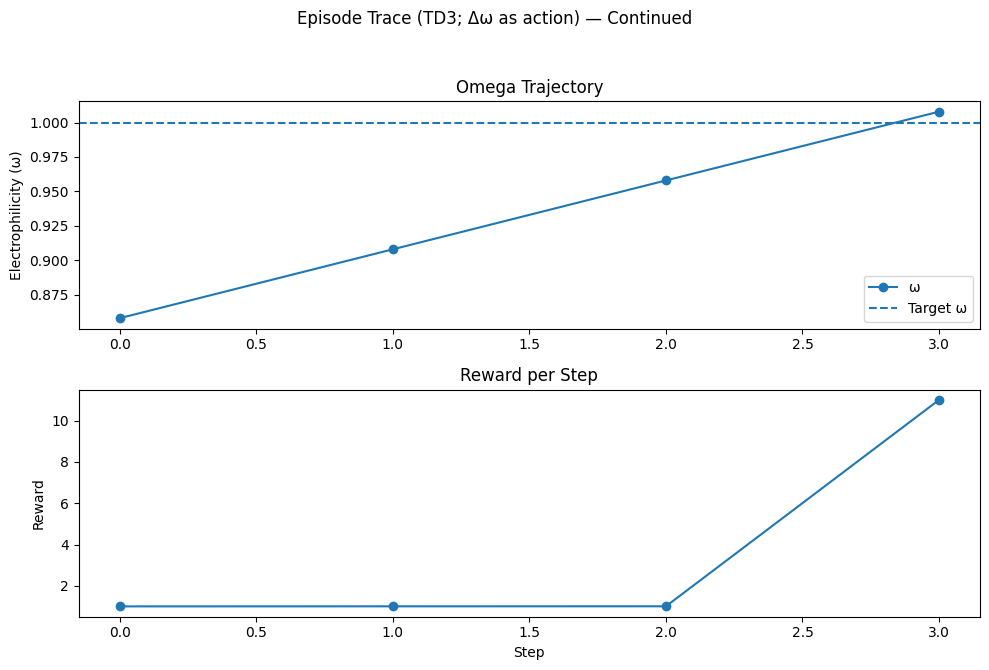

Saved episode trace to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/trace_td3_continued_1000.png
Saved validated actor to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/best_actor_td3_validated_1000.pth

=== Extended validation for 2000 episodes ===
Validation: Success=0.673, MeanDist=0.0860


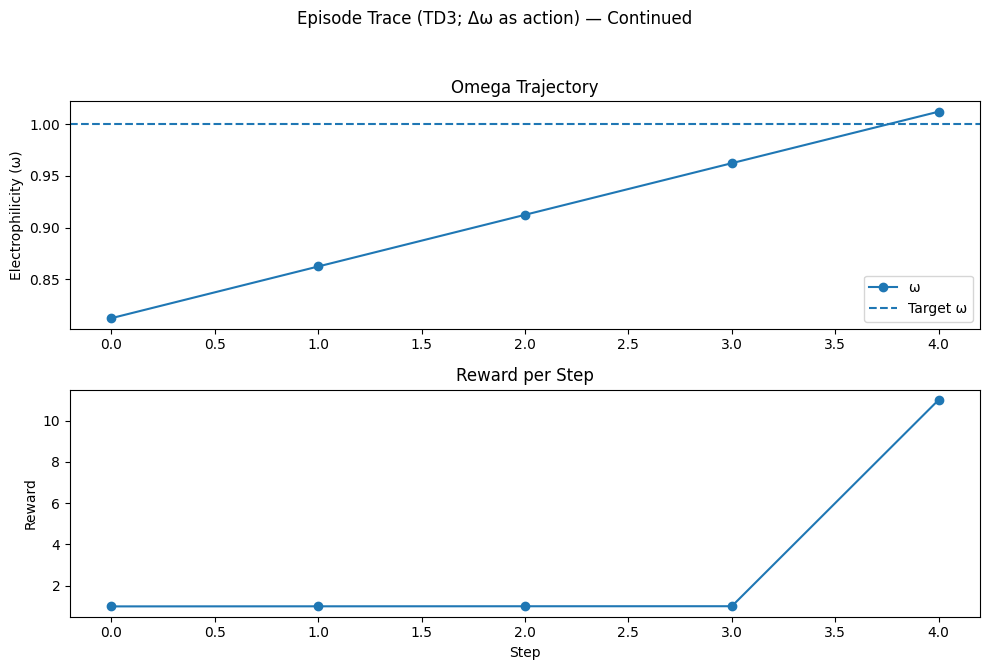

Saved episode trace to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/trace_td3_continued_2000.png
Saved validated actor to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/best_actor_td3_validated_2000.pth

=== Extended validation for 3000 episodes ===
Validation: Success=0.668, MeanDist=0.0881


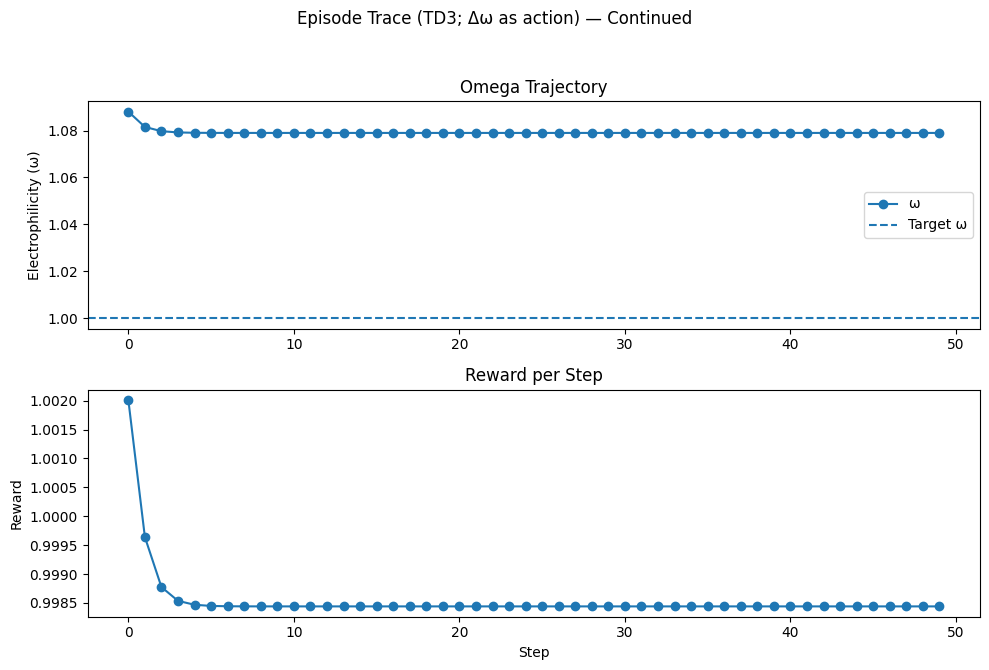

Saved episode trace to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/trace_td3_continued_3000.png
Saved validated actor to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/best_actor_td3_validated_3000.pth

=== Extended validation for 4000 episodes ===
Validation: Success=0.656, MeanDist=0.0943


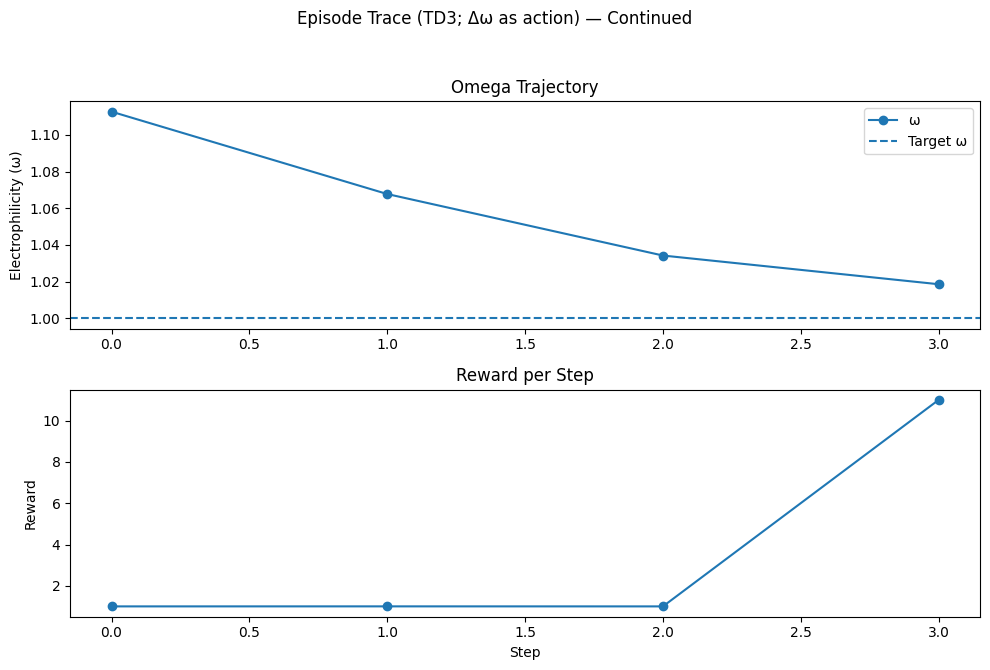

Saved episode trace to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/trace_td3_continued_4000.png
Saved validated actor to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/best_actor_td3_validated_4000.pth

=== Extended validation for 5000 episodes ===
Validation: Success=0.671, MeanDist=0.0932


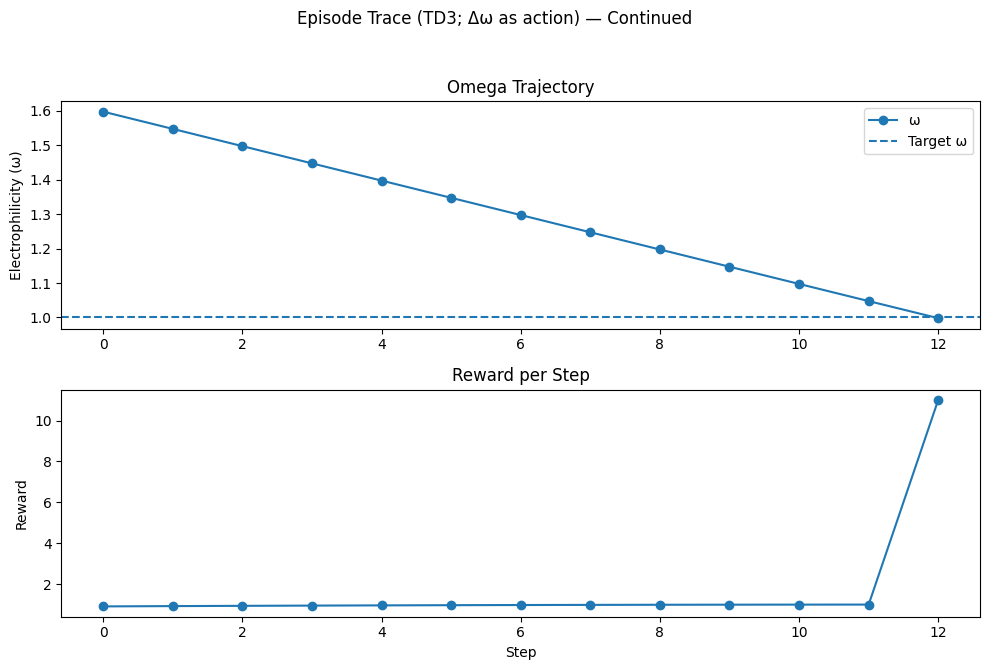

Saved episode trace to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/trace_td3_continued_5000.png
Saved validated actor to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/best_actor_td3_validated_5000.pth

=== Extended validation for 10000 episodes ===
Validation: Success=0.649, MeanDist=0.0915


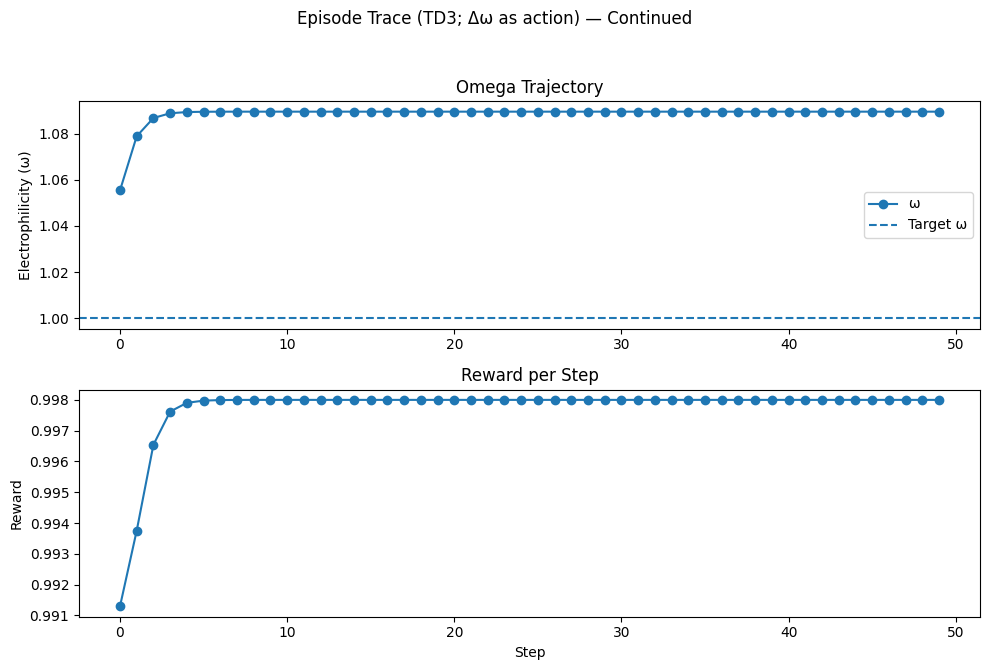

Saved episode trace to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/trace_td3_continued_10000.png
Saved validated actor to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/best_actor_td3_validated_10000.pth

=== Extended validation for 20000 episodes ===
Validation: Success=0.664, MeanDist=0.0903


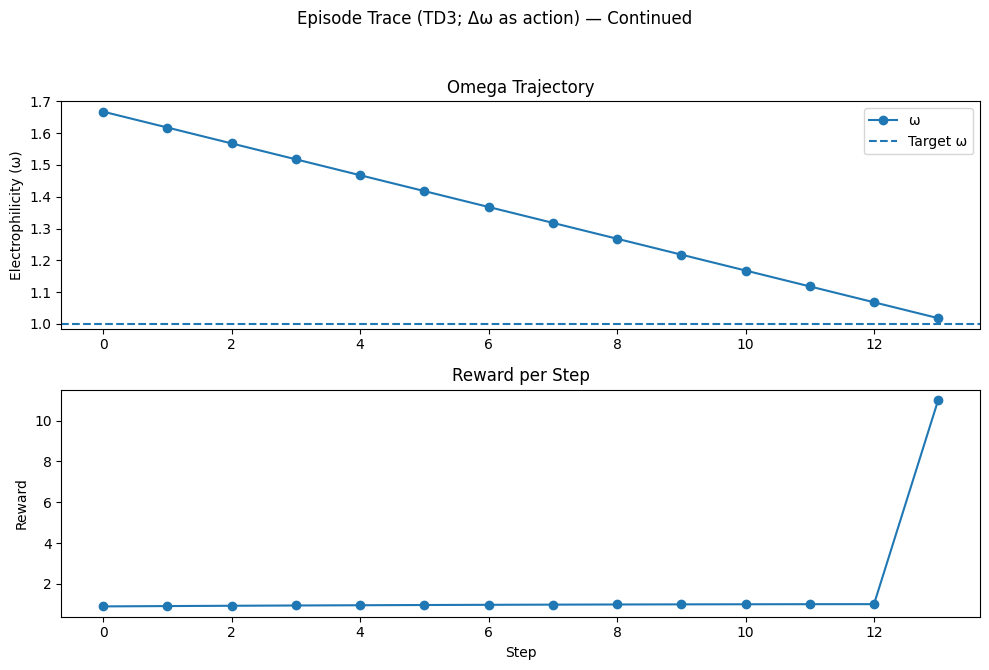

Saved episode trace to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/trace_td3_continued_20000.png
Saved validated actor to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/best_actor_td3_validated_20000.pth

=== Extended validation for 40000 episodes ===
Validation: Success=0.661, MeanDist=0.0898


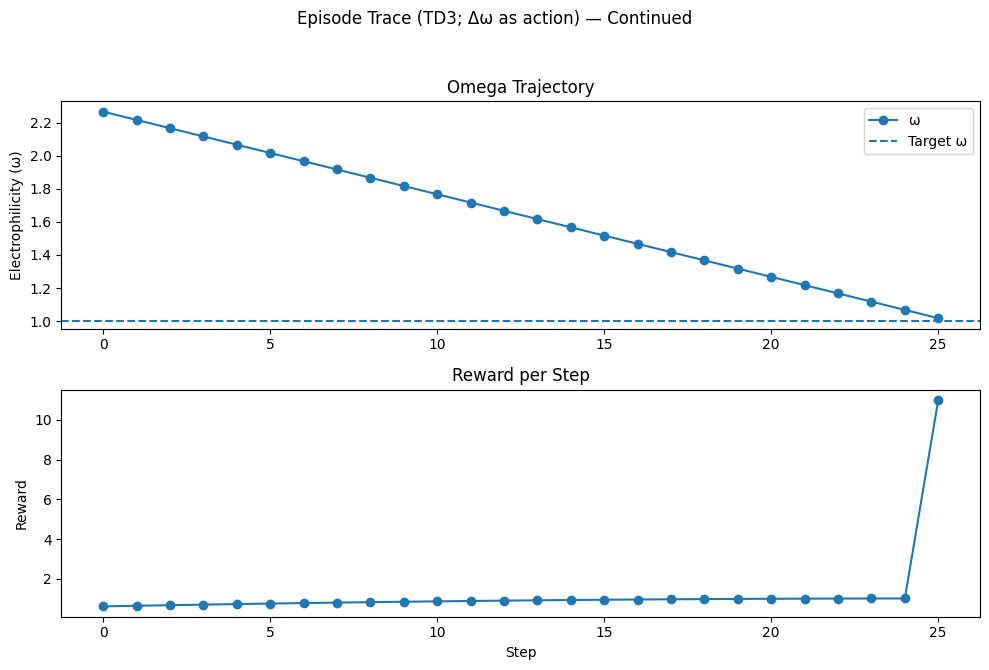

Saved episode trace to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/trace_td3_continued_40000.png
Saved validated actor to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/best_actor_td3_validated_40000.pth


In [ ]:
#Longer runs of the best model from the grid search
# Reproducibility & Paths

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

BASE_DIR    = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
TRAIN_CSV   = os.path.join(BASE_DIR, "dataset", "train_dataset.csv")
VAL_CSV     = os.path.join(BASE_DIR, "dataset", "val_dataset.csv")
RESULTS_DIR = os.path.join(BASE_DIR, "Results")
PLOTS_DIR   = os.path.join(BASE_DIR, "plots")
os.makedirs(RESULTS_DIR, exist_ok=True); os.makedirs(PLOTS_DIR, exist_ok=True)

BEST_ACTOR  = os.path.join(RESULTS_DIR, "best_actor_td3.pth")
BEST_CRITIC = os.path.join(RESULTS_DIR, "best_critic_td3.pth")

STATE_COLUMNS = [
    'Electronegativity','Hardness','Electrophilicity','q(N)',
    'f-','f+','f0','s-','s+','s0','s+/s-','s-/s+','s(2)'
]
OMEGA_COL = 'Electrophilicity'


# Preprocessing

def _safe_ratio(num, den, eps=1e-8):
    n = np.asarray(num, dtype=np.float64)
    d = np.asarray(den, dtype=np.float64)
    return (n) / (np.sign(d) * np.maximum(np.abs(d), eps))

def preprocess_dataframe(df: pd.DataFrame, fit_scaler=False, scaler=None):
    df = df.copy()
    missing = [c for c in STATE_COLUMNS if c not in df.columns]
    for c in missing: df[c] = np.nan

    if 's+/s-' not in df.columns:
        df['s+/s-'] = _safe_ratio(df.get('s+', 0.0), df.get('s-', 1.0))
    if 's-/s+' not in df.columns:
        df['s-/s+'] = _safe_ratio(df.get('s-', 0.0), df.get('s+', 1.0))

    df[STATE_COLUMNS] = df[STATE_COLUMNS].ffill().bfill()
    df['f-'] = df['f-'].clip(-1.0, 1.0)
    df['f+'] = df['f+'].clip(-1.0, 1.0)
    df['f0'] = df['f0'].clip(-1.0, 1.0)
    df[OMEGA_COL] = df[OMEGA_COL].clip(0.0, 6.5)
    df = df[STATE_COLUMNS]

    if fit_scaler:
        mu = df.mean(numeric_only=True)
        sd = df.std(numeric_only=True).replace(0.0, 1.0)
        scaler = {'mu': mu, 'sd': sd}
    mu = scaler['mu'] if scaler else df.mean(numeric_only=True)
    sd = scaler['sd'] if scaler else df.std(numeric_only=True).replace(0.0, 1.0)

    df_scaled = (df - mu) / sd
    df_scaled['_omega_unscaled'] = df[OMEGA_COL].values.astype(np.float32)
    df_scaled['_omega_mu'] = mu[OMEGA_COL]
    df_scaled['_omega_sd'] = sd[OMEGA_COL] if sd[OMEGA_COL] != 0 else 1.0
    return df_scaled.reset_index(drop=True), scaler


# Environment

class ContinuousRadicalEnv:
    def __init__(self, df_scaled, target_omega=1.0,
                 success_thr=0.05, rmax=2.0, success_bonus=10.0):
        self.df = df_scaled.reset_index(drop=True)
        self.state_columns = STATE_COLUMNS
        self.num_features = len(self.state_columns)
        self.target_omega = float(target_omega)
        self.success_thr = float(success_thr)
        self.rmax = float(rmax)
        self.success_bonus = float(success_bonus)
        self.omega_clip = (0.0, 6.5)
        self.high_omega_terminate = 5.0
        self.high_omega_penalty = -5.0
        self.start_policy = 'mixed'
        self.state = None
        self.idx = None

    def set_success_threshold(self, thr): self.success_thr = float(thr)
    def set_start_policy(self, policy: str): self.start_policy = policy

    def reset(self):
        df = self.df
        if self.start_policy in ('below', 'above'):
            mask = (df['_omega_unscaled'] < self.target_omega) if (self.start_policy=='below') \
                   else (df['_omega_unscaled'] > self.target_omega)
            sub = df[mask]; df = sub if len(sub) > 0 else df
        self.idx = int(np.random.choice(df.index))
        self.state = df.loc[self.idx, self.state_columns].values.astype(np.float32)
        self.row_cache = df.loc[self.idx]
        return self.state.copy()

    def _success_bonus(self, omega):
        return self.success_bonus if abs(omega - self.target_omega) <= self.success_thr else 0.0
    def _proximity_reward(self, omega):
        dist = abs(omega - self.target_omega)
        return max(0.0, 1.0 - (dist / self.rmax)**2)

    def step(self, delta_omega, pos_clip, neg_clip):
        state = self.state
        omega_mu = float(self.row_cache['_omega_mu'])
        omega_sd = float(self.row_cache['_omega_sd'])
        omega_scaled = float(state[2])
        prev_omega = omega_sd * omega_scaled + omega_mu
        prev_dist  = abs(prev_omega - self.target_omega)
        a = float(np.clip(delta_omega, -neg_clip, +pos_clip))
        new_omega = np.clip(prev_omega + a, *self.omega_clip)
        new_dist  = abs(new_omega - self.target_omega)
        done, penalty = False, 0.0
        if new_omega >= self.high_omega_terminate: done, penalty = True, self.high_omega_penalty
        if new_dist <= self.success_thr: done = True
        proximity = self._proximity_reward(new_omega)
        progress  = 0.2 * (prev_dist - new_dist)
        bonus     = self._success_bonus(new_omega)
        reward = proximity + progress + bonus + penalty
        new_omega_scaled = (new_omega - omega_mu) / (omega_sd if omega_sd != 0 else 1.0)
        new_state = state.copy(); new_state[2] = new_omega_scaled
        self.state = new_state
        return new_state.copy(), float(reward), done, {"omega": new_omega, "delta_clamped": a}


# TD3 Networks

def mlp(sizes, act_last=None):
    layers = []
    for i in range(len(sizes)-2):
        layers += [nn.Linear(sizes[i], sizes[i+1]), nn.ReLU()]
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if act_last == 'tanh': layers.append(nn.Tanh())
    return nn.Sequential(*layers)

class Actor(nn.Module):
    def __init__(self, state_dim, hidden):
        super().__init__()
        self.body = mlp([state_dim, hidden, hidden, 1], act_last='tanh')
    def forward(self, s): return self.body(s).squeeze(1)

class Critic(nn.Module):
    def __init__(self, state_dim, hidden):
        super().__init__()
        self.q1 = mlp([state_dim+1, hidden, hidden, 1])
        self.q2 = mlp([state_dim+1, hidden, hidden, 1])
    def forward(self, s, a):
        x = torch.cat([s, a], dim=1)
        return self.q1(x).squeeze(1), self.q2(x).squeeze(1)


# Validation + Plot

def validate(env, actor, episodes=200, max_steps=50,
             pos_clip=0.05, neg_clip=0.05, success_thr=0.02):
    device = next(actor.parameters()).device
    env.set_success_threshold(success_thr); env.set_start_policy('mixed')
    successes, final_dists = 0, []
    with torch.no_grad():
        for _ in range(episodes):
            s = env.reset()
            omega_final = None
            for _ in range(max_steps):
                s_t = torch.from_numpy(s).float().unsqueeze(0).to(device)
                raw = actor(s_t).item()
                a = raw*pos_clip if raw>=0 else raw*neg_clip
                s, _, done, info = env.step(a, pos_clip=pos_clip, neg_clip=neg_clip)
                omega_final = info["omega"]
                if done: break
            if abs(omega_final - env.target_omega) <= success_thr:
                successes += 1
            final_dists.append(abs(omega_final - env.target_omega))
    return successes/episodes, float(np.mean(final_dists))

def plot_episode_trace(env, actor, steps=50, fname="trace_td3.png",
                       pos_clip=0.05, neg_clip=0.05):
    device = next(actor.parameters()).device
    env.set_start_policy('mixed')
    s = env.reset(); omegas, rewards = [], []
    with torch.no_grad():
        for _ in range(steps):
            s_t = torch.from_numpy(s).float().unsqueeze(0).to(device)
            raw = actor(s_t).item()
            a = raw*pos_clip if raw>=0 else raw*neg_clip
            s, r, done, info = env.step(a, pos_clip=pos_clip, neg_clip=neg_clip)
            omegas.append(info["omega"]); rewards.append(r)
            if done: break
    fig = plt.figure(figsize=(10,7))
    fig.suptitle("Episode Trace (TD3; Δω as action) — Continued", fontsize=12)
    ax1 = fig.add_subplot(2,1,1)
    ax1.plot(range(len(omegas)), omegas, marker='o', label='ω')
    ax1.axhline(env.target_omega, linestyle='--', label='Target ω')
    ax1.set_ylabel("Electrophilicity (ω)"); ax1.set_title("Omega Trajectory"); ax1.legend()
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(range(len(rewards)), rewards, marker='o')
    ax2.set_ylabel("Reward"); ax2.set_xlabel("Step"); ax2.set_title("Reward per Step")
    out_path = os.path.join(PLOTS_DIR, fname)
    fig.tight_layout(rect=[0,0.03,1,0.95]); fig.savefig(out_path)
    plt.show(fig)
    print(f"Saved episode trace to: {out_path}")


# Extended Validation Runner

def continue_best_for_budgets(budgets=(1000,2000,5000)):
    # Load data
    raw_va = pd.read_csv(VAL_CSV)
    val_df, _ = preprocess_dataframe(raw_va, fit_scaler=False, scaler=None)
    env_val = ContinuousRadicalEnv(val_df, target_omega=1.0,
                                   success_thr=0.02, rmax=2.0, success_bonus=10.0)

    # Load best models from Code-1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hidden_best = 128
    if os.path.exists(BEST_ACTOR):
        m = re.search(r"h(\d+)", BEST_ACTOR)
        if m: hidden_best = int(m.group(1))
    actor = Actor(env_val.num_features, hidden_best).to(device)
    critic = Critic(env_val.num_features, hidden_best).to(device)
    actor.load_state_dict(torch.load(BEST_ACTOR, map_location=device))
    critic.load_state_dict(torch.load(BEST_CRITIC, map_location=device))
    actor.eval(); critic.eval()

    # Validate across budgets
    for ep_budget in budgets:
        print(f"\n=== Extended validation for {ep_budget} episodes ===")
        sr, dist = validate(env_val, actor,
                            episodes=ep_budget, max_steps=50,
                            pos_clip=0.05, neg_clip=0.05, success_thr=0.02)
        print(f"Validation: Success={sr:.3f}, MeanDist={dist:.4f}")

        # Save plot
        plot_episode_trace(env_val, actor, steps=50,
                           fname=f"trace_td3_continued_{ep_budget}.png")

        # Save actor for downstream
        save_path = os.path.join(RESULTS_DIR, f"best_actor_td3_validated_{ep_budget}.pth")
        torch.save(actor.state_dict(), save_path)
        print(f"Saved validated actor to: {save_path}")


# Run

if __name__ == "__main__":
    continue_best_for_budgets(budgets=(1000,2000,3000, 4000, 5000, 10000, 20000, 40000))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== Extended validation for 1000 episodes ===
Validation: Success=0.663, MeanDist=0.0884


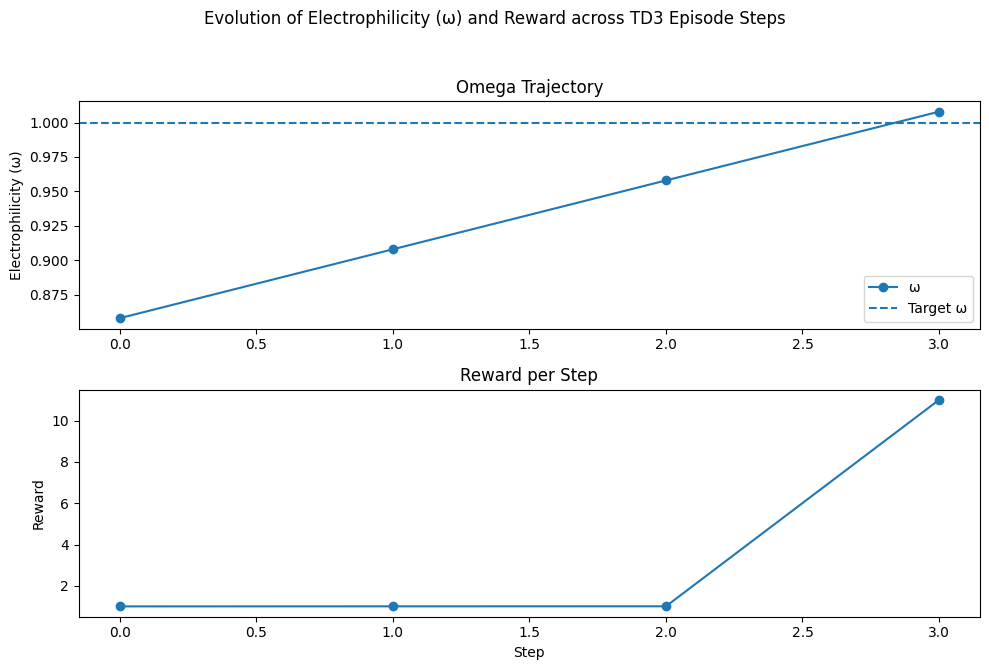

Saved episode trace to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/trace_td3_continued_1000.png
Saved validated actor to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/best_actor_td3_validated_1000.pth

=== Extended validation for 2000 episodes ===


KeyboardInterrupt: 

In [ ]:
#Longer runs of the best model from the grid search
# Reproducibility & Paths

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

BASE_DIR    = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
TRAIN_CSV   = os.path.join(BASE_DIR, "dataset", "train_dataset.csv")
VAL_CSV     = os.path.join(BASE_DIR, "dataset", "val_dataset.csv")
RESULTS_DIR = os.path.join(BASE_DIR, "Results")
PLOTS_DIR   = os.path.join(BASE_DIR, "plots")
os.makedirs(RESULTS_DIR, exist_ok=True); os.makedirs(PLOTS_DIR, exist_ok=True)

BEST_ACTOR  = os.path.join(RESULTS_DIR, "best_actor_td3.pth")
BEST_CRITIC = os.path.join(RESULTS_DIR, "best_critic_td3.pth")

STATE_COLUMNS = [
    'Electronegativity','Hardness','Electrophilicity','q(N)',
    'f-','f+','f0','s-','s+','s0','s+/s-','s-/s+','s(2)'
]
OMEGA_COL = 'Electrophilicity'


# Preprocessing

def _safe_ratio(num, den, eps=1e-8):
    n = np.asarray(num, dtype=np.float64)
    d = np.asarray(den, dtype=np.float64)
    return (n) / (np.sign(d) * np.maximum(np.abs(d), eps))

def preprocess_dataframe(df: pd.DataFrame, fit_scaler=False, scaler=None):
    df = df.copy()
    missing = [c for c in STATE_COLUMNS if c not in df.columns]
    for c in missing: df[c] = np.nan

    if 's+/s-' not in df.columns:
        df['s+/s-'] = _safe_ratio(df.get('s+', 0.0), df.get('s-', 1.0))
    if 's-/s+' not in df.columns:
        df['s-/s+'] = _safe_ratio(df.get('s-', 0.0), df.get('s+', 1.0))

    df[STATE_COLUMNS] = df[STATE_COLUMNS].ffill().bfill()
    df['f-'] = df['f-'].clip(-1.0, 1.0)
    df['f+'] = df['f+'].clip(-1.0, 1.0)
    df['f0'] = df['f0'].clip(-1.0, 1.0)
    df[OMEGA_COL] = df[OMEGA_COL].clip(0.0, 6.5)
    df = df[STATE_COLUMNS]

    if fit_scaler:
        mu = df.mean(numeric_only=True)
        sd = df.std(numeric_only=True).replace(0.0, 1.0)
        scaler = {'mu': mu, 'sd': sd}
    mu = scaler['mu'] if scaler else df.mean(numeric_only=True)
    sd = scaler['sd'] if scaler else df.std(numeric_only=True).replace(0.0, 1.0)

    df_scaled = (df - mu) / sd
    df_scaled['_omega_unscaled'] = df[OMEGA_COL].values.astype(np.float32)
    df_scaled['_omega_mu'] = mu[OMEGA_COL]
    df_scaled['_omega_sd'] = sd[OMEGA_COL] if sd[OMEGA_COL] != 0 else 1.0
    return df_scaled.reset_index(drop=True), scaler


# Environment

class ContinuousRadicalEnv:
    def __init__(self, df_scaled, target_omega=1.0,
                 success_thr=0.05, rmax=2.0, success_bonus=10.0):
        self.df = df_scaled.reset_index(drop=True)
        self.state_columns = STATE_COLUMNS
        self.num_features = len(self.state_columns)
        self.target_omega = float(target_omega)
        self.success_thr = float(success_thr)
        self.rmax = float(rmax)
        self.success_bonus = float(success_bonus)
        self.omega_clip = (0.0, 6.5)
        self.high_omega_terminate = 5.0
        self.high_omega_penalty = -5.0
        self.start_policy = 'mixed'
        self.state = None
        self.idx = None

    def set_success_threshold(self, thr): self.success_thr = float(thr)
    def set_start_policy(self, policy: str): self.start_policy = policy

    def reset(self):
        df = self.df
        if self.start_policy in ('below', 'above'):
            mask = (df['_omega_unscaled'] < self.target_omega) if (self.start_policy=='below') \
                   else (df['_omega_unscaled'] > self.target_omega)
            sub = df[mask]; df = sub if len(sub) > 0 else df
        self.idx = int(np.random.choice(df.index))
        self.state = df.loc[self.idx, self.state_columns].values.astype(np.float32)
        self.row_cache = df.loc[self.idx]
        return self.state.copy()

    def _success_bonus(self, omega):
        return self.success_bonus if abs(omega - self.target_omega) <= self.success_thr else 0.0
    def _proximity_reward(self, omega):
        dist = abs(omega - self.target_omega)
        return max(0.0, 1.0 - (dist / self.rmax)**2)

    def step(self, delta_omega, pos_clip, neg_clip):
        state = self.state
        omega_mu = float(self.row_cache['_omega_mu'])
        omega_sd = float(self.row_cache['_omega_sd'])
        omega_scaled = float(state[2])
        prev_omega = omega_sd * omega_scaled + omega_mu
        prev_dist  = abs(prev_omega - self.target_omega)
        a = float(np.clip(delta_omega, -neg_clip, +pos_clip))
        new_omega = np.clip(prev_omega + a, *self.omega_clip)
        new_dist  = abs(new_omega - self.target_omega)
        done, penalty = False, 0.0
        if new_omega >= self.high_omega_terminate: done, penalty = True, self.high_omega_penalty
        if new_dist <= self.success_thr: done = True
        proximity = self._proximity_reward(new_omega)
        progress  = 0.2 * (prev_dist - new_dist)
        bonus     = self._success_bonus(new_omega)
        reward = proximity + progress + bonus + penalty
        new_omega_scaled = (new_omega - omega_mu) / (omega_sd if omega_sd != 0 else 1.0)
        new_state = state.copy(); new_state[2] = new_omega_scaled
        self.state = new_state
        return new_state.copy(), float(reward), done, {"omega": new_omega, "delta_clamped": a}


# TD3 Networks

def mlp(sizes, act_last=None):
    layers = []
    for i in range(len(sizes)-2):
        layers += [nn.Linear(sizes[i], sizes[i+1]), nn.ReLU()]
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if act_last == 'tanh': layers.append(nn.Tanh())
    return nn.Sequential(*layers)

class Actor(nn.Module):
    def __init__(self, state_dim, hidden):
        super().__init__()
        self.body = mlp([state_dim, hidden, hidden, 1], act_last='tanh')
    def forward(self, s): return self.body(s).squeeze(1)

class Critic(nn.Module):
    def __init__(self, state_dim, hidden):
        super().__init__()
        self.q1 = mlp([state_dim+1, hidden, hidden, 1])
        self.q2 = mlp([state_dim+1, hidden, hidden, 1])
    def forward(self, s, a):
        x = torch.cat([s, a], dim=1)
        return self.q1(x).squeeze(1), self.q2(x).squeeze(1)


# Validation + Plot

def validate(env, actor, episodes=200, max_steps=50,
             pos_clip=0.05, neg_clip=0.05, success_thr=0.02):
    device = next(actor.parameters()).device
    env.set_success_threshold(success_thr); env.set_start_policy('mixed')
    successes, final_dists = 0, []
    with torch.no_grad():
        for _ in range(episodes):
            s = env.reset()
            omega_final = None
            for _ in range(max_steps):
                s_t = torch.from_numpy(s).float().unsqueeze(0).to(device)
                raw = actor(s_t).item()
                a = raw*pos_clip if raw>=0 else raw*neg_clip
                s, _, done, info = env.step(a, pos_clip=pos_clip, neg_clip=neg_clip)
                omega_final = info["omega"]
                if done: break
            if abs(omega_final - env.target_omega) <= success_thr:
                successes += 1
            final_dists.append(abs(omega_final - env.target_omega))
    return successes/episodes, float(np.mean(final_dists))

def plot_episode_trace(env, actor, steps=50, fname="trace_td3.png",
                       pos_clip=0.05, neg_clip=0.05):
    device = next(actor.parameters()).device
    env.set_start_policy('mixed')
    s = env.reset(); omegas, rewards = [], []
    with torch.no_grad():
        for _ in range(steps):
            s_t = torch.from_numpy(s).float().unsqueeze(0).to(device)
            raw = actor(s_t).item()
            a = raw*pos_clip if raw>=0 else raw*neg_clip
            s, r, done, info = env.step(a, pos_clip=pos_clip, neg_clip=neg_clip)
            omegas.append(info["omega"]); rewards.append(r)
            if done: break
    fig = plt.figure(figsize=(10,7))
    fig.suptitle("Evolution of Electrophilicity (ω) and Reward across TD3 Episode Steps", fontsize=12)
    ax1 = fig.add_subplot(2,1,1)
    ax1.plot(range(len(omegas)), omegas, marker='o', label='ω')
    ax1.axhline(env.target_omega, linestyle='--', label='Target ω')
    ax1.set_ylabel("Electrophilicity (ω)"); ax1.set_title("Omega Trajectory"); ax1.legend()
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(range(len(rewards)), rewards, marker='o')
    ax2.set_ylabel("Reward"); ax2.set_xlabel("Step"); ax2.set_title("Reward per Step")
    out_path = os.path.join(PLOTS_DIR, fname)
    fig.tight_layout(rect=[0,0.03,1,0.95]); fig.savefig(out_path)
    plt.show(fig)
    print(f"Saved episode trace to: {out_path}")


# Extended Validation Runner

def continue_best_for_budgets(budgets=(1000,2000,5000)):
    # Load data
    raw_va = pd.read_csv(VAL_CSV)
    val_df, _ = preprocess_dataframe(raw_va, fit_scaler=False, scaler=None)
    env_val = ContinuousRadicalEnv(val_df, target_omega=1.0,
                                   success_thr=0.02, rmax=2.0, success_bonus=10.0)

    # Load best models from Code-1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hidden_best = 128
    if os.path.exists(BEST_ACTOR):
        m = re.search(r"h(\d+)", BEST_ACTOR)
        if m: hidden_best = int(m.group(1))
    actor = Actor(env_val.num_features, hidden_best).to(device)
    critic = Critic(env_val.num_features, hidden_best).to(device)
    actor.load_state_dict(torch.load(BEST_ACTOR, map_location=device))
    critic.load_state_dict(torch.load(BEST_CRITIC, map_location=device))
    actor.eval(); critic.eval()

    # Validate across budgets
    for ep_budget in budgets:
        print(f"\n=== Extended validation for {ep_budget} episodes ===")
        sr, dist = validate(env_val, actor,
                            episodes=ep_budget, max_steps=50,
                            pos_clip=0.05, neg_clip=0.05, success_thr=0.02)
        print(f"Validation: Success={sr:.3f}, MeanDist={dist:.4f}")

        # Save plot
        plot_episode_trace(env_val, actor, steps=50,
                           fname=f"trace_td3_continued_{ep_budget}.png")

        # Save actor for downstream
        save_path = os.path.join(RESULTS_DIR, f"best_actor_td3_validated_{ep_budget}.pth")
        torch.save(actor.state_dict(), save_path)
        print(f"Saved validated actor to: {save_path}")


# Run

if __name__ == "__main__":
    continue_best_for_budgets(budgets=(1000,2000,3000, 4000, 5000, 10000, 20000, 40000))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== Extended validation for 1000 episodes ===
Validation: Success=0.663, MeanDist=0.0884


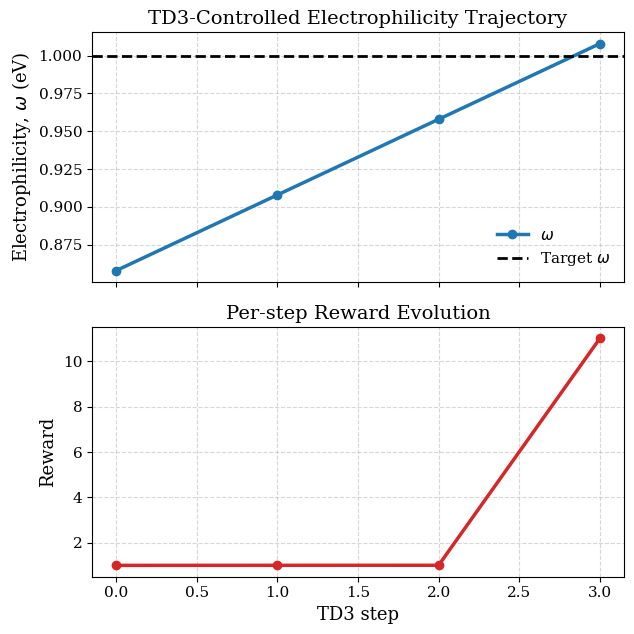

Saved episode trace to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/trace_td3_continued_1000.png
Saved validated actor to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/best_actor_td3_validated_1000.pth

=== Extended validation for 2000 episodes ===


KeyboardInterrupt: 

In [ ]:
# =========================
# Longer runs of the best model from the grid search
# Reproducibility & Paths
# =========================

import os, re, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

BASE_DIR    = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
TRAIN_CSV   = os.path.join(BASE_DIR, "dataset", "train_dataset.csv")
VAL_CSV     = os.path.join(BASE_DIR, "dataset", "val_dataset.csv")
RESULTS_DIR = os.path.join(BASE_DIR, "Results")
PLOTS_DIR   = os.path.join(BASE_DIR, "plots")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

BEST_ACTOR  = os.path.join(RESULTS_DIR, "best_actor_td3.pth")
BEST_CRITIC = os.path.join(RESULTS_DIR, "best_critic_td3.pth")

STATE_COLUMNS = [
    'Electronegativity','Hardness','Electrophilicity','q(N)',
    'f-','f+','f0','s-','s+','s0','s+/s-','s-/s+','s(2)'
]
OMEGA_COL = 'Electrophilicity'


# =========================
# Preprocessing
# =========================

def _safe_ratio(num, den, eps=1e-8):
    n = np.asarray(num, dtype=np.float64)
    d = np.asarray(den, dtype=np.float64)
    return (n) / (np.sign(d) * np.maximum(np.abs(d), eps))

def preprocess_dataframe(df: pd.DataFrame, fit_scaler=False, scaler=None):
    df = df.copy()
    missing = [c for c in STATE_COLUMNS if c not in df.columns]
    for c in missing:
        df[c] = np.nan

    if 's+/s-' not in df.columns:
        df['s+/s-'] = _safe_ratio(df.get('s+', 0.0), df.get('s-', 1.0))
    if 's-/s+' not in df.columns:
        df['s-/s+'] = _safe_ratio(df.get('s-', 0.0), df.get('s+', 1.0))

    df[STATE_COLUMNS] = df[STATE_COLUMNS].ffill().bfill()
    df['f-'] = df['f-'].clip(-1.0, 1.0)
    df['f+'] = df['f+'].clip(-1.0, 1.0)
    df['f0'] = df['f0'].clip(-1.0, 1.0)
    df[OMEGA_COL] = df[OMEGA_COL].clip(0.0, 6.5)
    df = df[STATE_COLUMNS]

    if fit_scaler:
        mu = df.mean(numeric_only=True)
        sd = df.std(numeric_only=True).replace(0.0, 1.0)
        scaler = {'mu': mu, 'sd': sd}

    mu = scaler['mu'] if scaler else df.mean(numeric_only=True)
    sd = scaler['sd'] if scaler else df.std(numeric_only=True).replace(0.0, 1.0)

    df_scaled = (df - mu) / sd
    df_scaled['_omega_unscaled'] = df[OMEGA_COL].values.astype(np.float32)
    df_scaled['_omega_mu'] = mu[OMEGA_COL]
    df_scaled['_omega_sd'] = sd[OMEGA_COL] if sd[OMEGA_COL] != 0 else 1.0
    return df_scaled.reset_index(drop=True), scaler


# =========================
# Environment
# =========================

class ContinuousRadicalEnv:
    def __init__(self, df_scaled, target_omega=1.0,
                 success_thr=0.05, rmax=2.0, success_bonus=10.0):
        self.df = df_scaled.reset_index(drop=True)
        self.state_columns = STATE_COLUMNS
        self.num_features = len(self.state_columns)
        self.target_omega = float(target_omega)
        self.success_thr = float(success_thr)
        self.rmax = float(rmax)
        self.success_bonus = float(success_bonus)
        self.omega_clip = (0.0, 6.5)
        self.high_omega_terminate = 5.0
        self.high_omega_penalty = -5.0
        self.start_policy = 'mixed'
        self.state = None
        self.idx = None

    def set_success_threshold(self, thr):
        self.success_thr = float(thr)

    def set_start_policy(self, policy: str):
        self.start_policy = policy

    def reset(self):
        df = self.df
        if self.start_policy in ('below', 'above'):
            mask = (df['_omega_unscaled'] < self.target_omega) if (self.start_policy=='below') \
                   else (df['_omega_unscaled'] > self.target_omega)
            sub = df[mask]
            df = sub if len(sub) > 0 else df
        self.idx = int(np.random.choice(df.index))
        self.state = df.loc[self.idx, self.state_columns].values.astype(np.float32)
        self.row_cache = df.loc[self.idx]
        return self.state.copy()

    def _success_bonus(self, omega):
        return self.success_bonus if abs(omega - self.target_omega) <= self.success_thr else 0.0

    def _proximity_reward(self, omega):
        dist = abs(omega - self.target_omega)
        return max(0.0, 1.0 - (dist / self.rmax)**2)

    def step(self, delta_omega, pos_clip, neg_clip):
        state = self.state
        omega_mu = float(self.row_cache['_omega_mu'])
        omega_sd = float(self.row_cache['_omega_sd'])
        omega_scaled = float(state[2])

        prev_omega = omega_sd * omega_scaled + omega_mu
        prev_dist  = abs(prev_omega - self.target_omega)

        a = float(np.clip(delta_omega, -neg_clip, +pos_clip))
        new_omega = np.clip(prev_omega + a, *self.omega_clip)
        new_dist  = abs(new_omega - self.target_omega)

        done, penalty = False, 0.0
        if new_omega >= self.high_omega_terminate:
            done, penalty = True, self.high_omega_penalty
        if new_dist <= self.success_thr:
            done = True

        proximity = self._proximity_reward(new_omega)
        progress  = 0.2 * (prev_dist - new_dist)
        bonus     = self._success_bonus(new_omega)
        reward = proximity + progress + bonus + penalty

        new_omega_scaled = (new_omega - omega_mu) / (omega_sd if omega_sd != 0 else 1.0)
        new_state = state.copy()
        new_state[2] = new_omega_scaled
        self.state = new_state

        return new_state.copy(), float(reward), done, {"omega": new_omega, "delta_clamped": a}


# =========================
# TD3 Networks
# =========================

def mlp(sizes, act_last=None):
    layers = []
    for i in range(len(sizes)-2):
        layers += [nn.Linear(sizes[i], sizes[i+1]), nn.ReLU()]
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if act_last == 'tanh':
        layers.append(nn.Tanh())
    return nn.Sequential(*layers)

class Actor(nn.Module):
    def __init__(self, state_dim, hidden):
        super().__init__()
        self.body = mlp([state_dim, hidden, hidden, 1], act_last='tanh')
    def forward(self, s):
        return self.body(s).squeeze(1)

class Critic(nn.Module):
    def __init__(self, state_dim, hidden):
        super().__init__()
        self.q1 = mlp([state_dim+1, hidden, hidden, 1])
        self.q2 = mlp([state_dim+1, hidden, hidden, 1])
    def forward(self, s, a):
        x = torch.cat([s, a], dim=1)
        return self.q1(x).squeeze(1), self.q2(x).squeeze(1)


# =========================
# Validation
# =========================

def validate(env, actor, episodes=200, max_steps=50,
             pos_clip=0.05, neg_clip=0.05, success_thr=0.02):
    device = next(actor.parameters()).device
    env.set_success_threshold(success_thr)
    env.set_start_policy('mixed')
    successes, final_dists = 0, []

    with torch.no_grad():
        for _ in range(episodes):
            s = env.reset()
            omega_final = None
            for _ in range(max_steps):
                s_t = torch.from_numpy(s).float().unsqueeze(0).to(device)
                raw = actor(s_t).item()
                a = raw*pos_clip if raw >= 0 else raw*neg_clip
                s, _, done, info = env.step(a, pos_clip=pos_clip, neg_clip=neg_clip)
                omega_final = info["omega"]
                if done:
                    break
            if abs(omega_final - env.target_omega) <= success_thr:
                successes += 1
            final_dists.append(abs(omega_final - env.target_omega))

    return successes/episodes, float(np.mean(final_dists))


# =========================
# Publication-quality Plot
# =========================

def plot_episode_trace(env, actor, steps=50, fname="trace_td3.png",
                       pos_clip=0.05, neg_clip=0.05):
    device = next(actor.parameters()).device
    env.set_start_policy('mixed')
    s = env.reset()
    omegas, rewards = [], []

    with torch.no_grad():
        for _ in range(steps):
            s_t = torch.from_numpy(s).float().unsqueeze(0).to(device)
            raw = actor(s_t).item()
            a = raw*pos_clip if raw >= 0 else raw*neg_clip
            s, r, done, info = env.step(a, pos_clip=pos_clip, neg_clip=neg_clip)
            omegas.append(info["omega"])
            rewards.append(r)
            if done:
                break

    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 12,
        "axes.labelsize": 13,
        "axes.titlesize": 14,
        "legend.fontsize": 11,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11
    })

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.5, 6.5), sharex=True)
    steps_range = np.arange(len(omegas))

    ax1.plot(steps_range, omegas, marker='o', lw=2.5, color="tab:blue", label=r"$\omega$")
    ax1.axhline(env.target_omega, lw=2, ls="--", color="black",
                label=r"Target $\omega$")
    ax1.set_ylabel(r"Electrophilicity, $\omega$ (eV)")
    ax1.set_title("TD3-Controlled Electrophilicity Trajectory")
    ax1.grid(True, ls="--", alpha=0.5)
    ax1.legend(frameon=False)

    ax2.plot(steps_range, rewards, marker='o', lw=2.5, color="tab:red")
    ax2.set_xlabel("TD3 step")
    ax2.set_ylabel("Reward")
    ax2.set_title("Per-step Reward Evolution")
    ax2.grid(True, ls="--", alpha=0.5)

    fig.tight_layout()
    out_path = os.path.join(PLOTS_DIR, fname)
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved episode trace to: {out_path}")


# =========================
# Extended Validation Runner
# =========================

def continue_best_for_budgets(budgets=(1000,2000,5000)):
    raw_va = pd.read_csv(VAL_CSV)
    val_df, _ = preprocess_dataframe(raw_va, fit_scaler=False, scaler=None)

    env_val = ContinuousRadicalEnv(val_df, target_omega=1.0,
                                   success_thr=0.02, rmax=2.0, success_bonus=10.0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hidden_best = 128

    actor = Actor(env_val.num_features, hidden_best).to(device)
    critic = Critic(env_val.num_features, hidden_best).to(device)
    actor.load_state_dict(torch.load(BEST_ACTOR, map_location=device))
    critic.load_state_dict(torch.load(BEST_CRITIC, map_location=device))
    actor.eval(); critic.eval()

    for ep_budget in budgets:
        print(f"\n=== Extended validation for {ep_budget} episodes ===")
        sr, dist = validate(env_val, actor,
                            episodes=ep_budget, max_steps=50,
                            pos_clip=0.05, neg_clip=0.05, success_thr=0.02)
        print(f"Validation: Success={sr:.3f}, MeanDist={dist:.4f}")

        plot_episode_trace(env_val, actor, steps=50,
                           fname=f"trace_td3_continued_{ep_budget}.png")

        save_path = os.path.join(RESULTS_DIR, f"best_actor_td3_validated_{ep_budget}.pth")
        torch.save(actor.state_dict(), save_path)
        print(f"Saved validated actor to: {save_path}")


# =========================
# Run
# =========================

if __name__ == "__main__":
    continue_best_for_budgets(budgets=(1000,2000,3000,4000,5000,10000,20000,40000))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== Extended validation for 1000 episodes ===
Validation: Success=0.663, MeanDist=0.0884


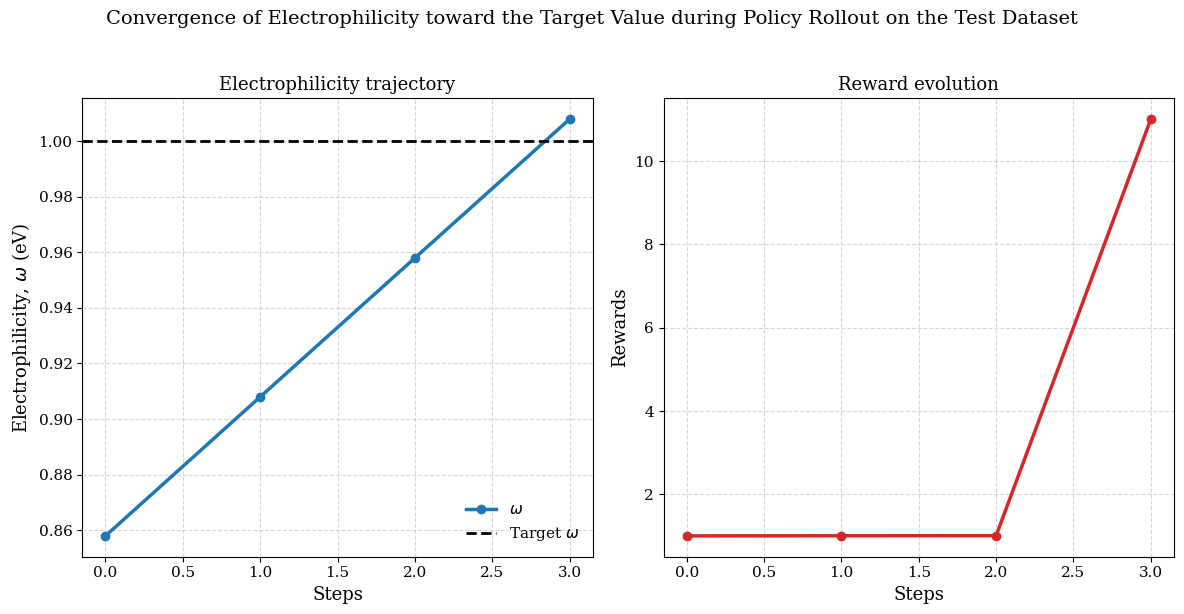

Saved episode trace to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/trace_td3_continued_1000.png
Saved validated actor to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/best_actor_td3_validated_1000.pth

=== Extended validation for 2000 episodes ===
Validation: Success=0.673, MeanDist=0.0860


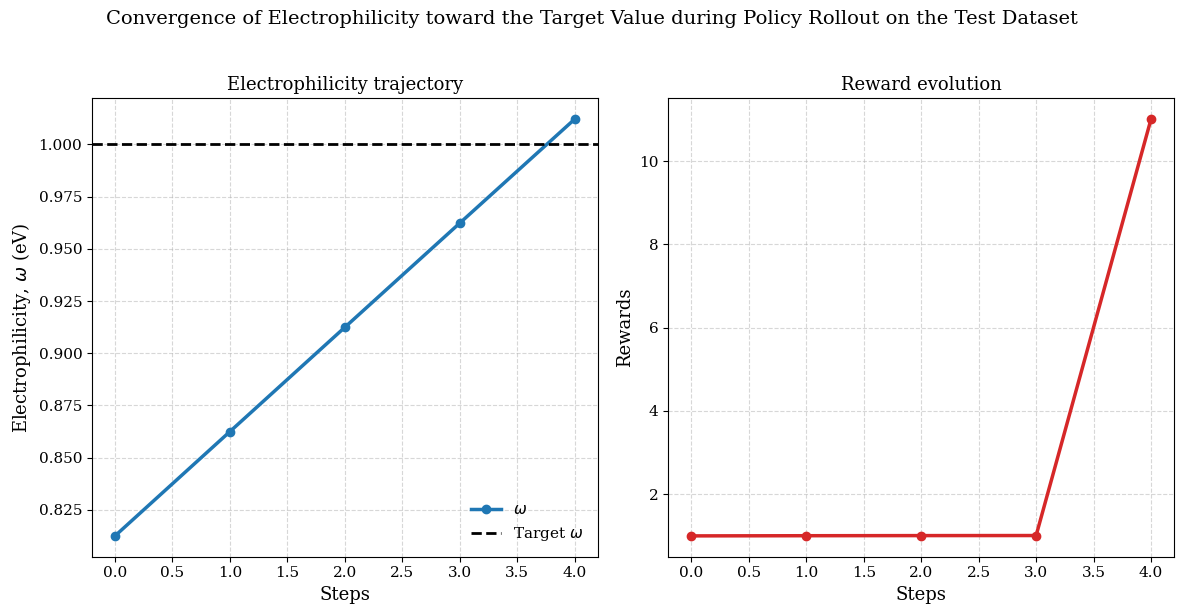

Saved episode trace to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/trace_td3_continued_2000.png
Saved validated actor to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/best_actor_td3_validated_2000.pth

=== Extended validation for 3000 episodes ===
Validation: Success=0.668, MeanDist=0.0881


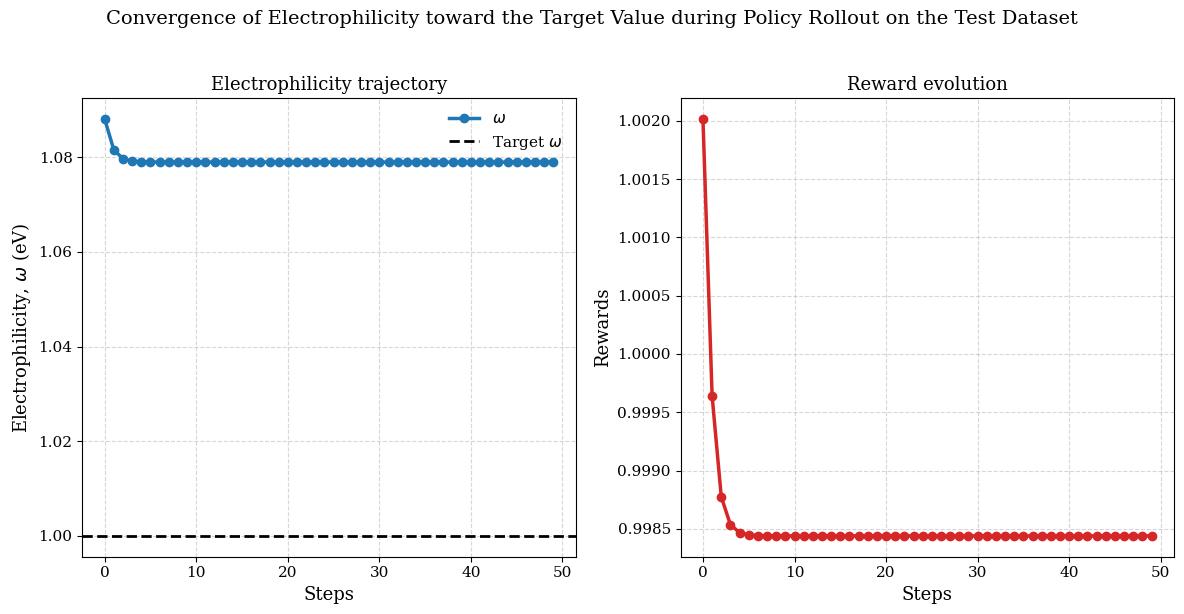

Saved episode trace to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/trace_td3_continued_3000.png
Saved validated actor to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/best_actor_td3_validated_3000.pth

=== Extended validation for 4000 episodes ===
Validation: Success=0.656, MeanDist=0.0943


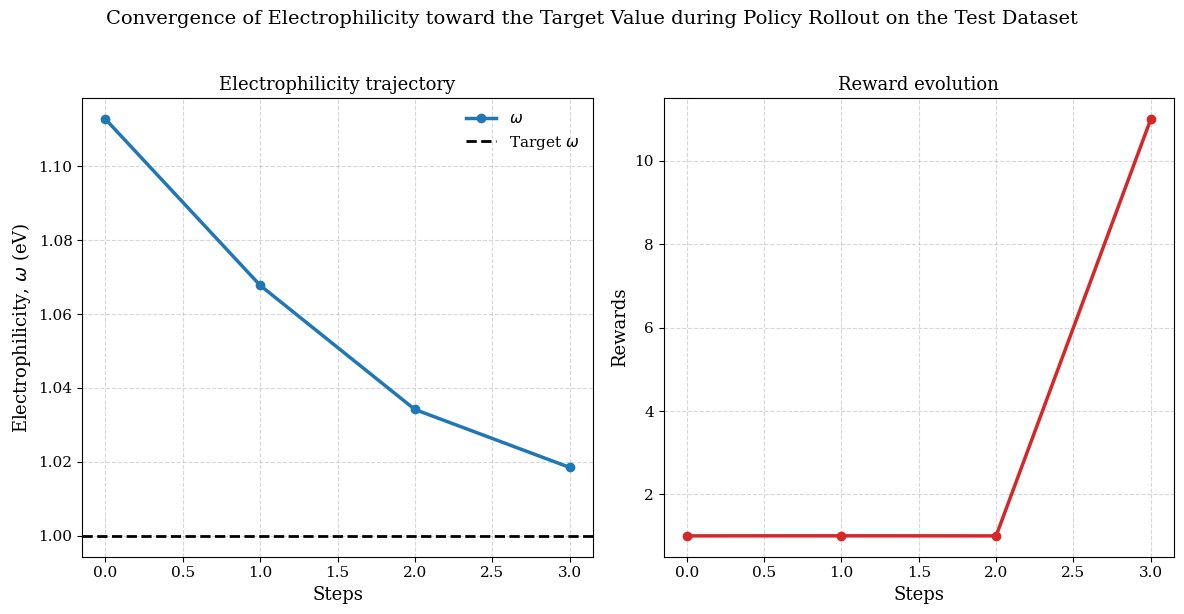

Saved episode trace to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/trace_td3_continued_4000.png
Saved validated actor to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/best_actor_td3_validated_4000.pth

=== Extended validation for 5000 episodes ===
Validation: Success=0.671, MeanDist=0.0932


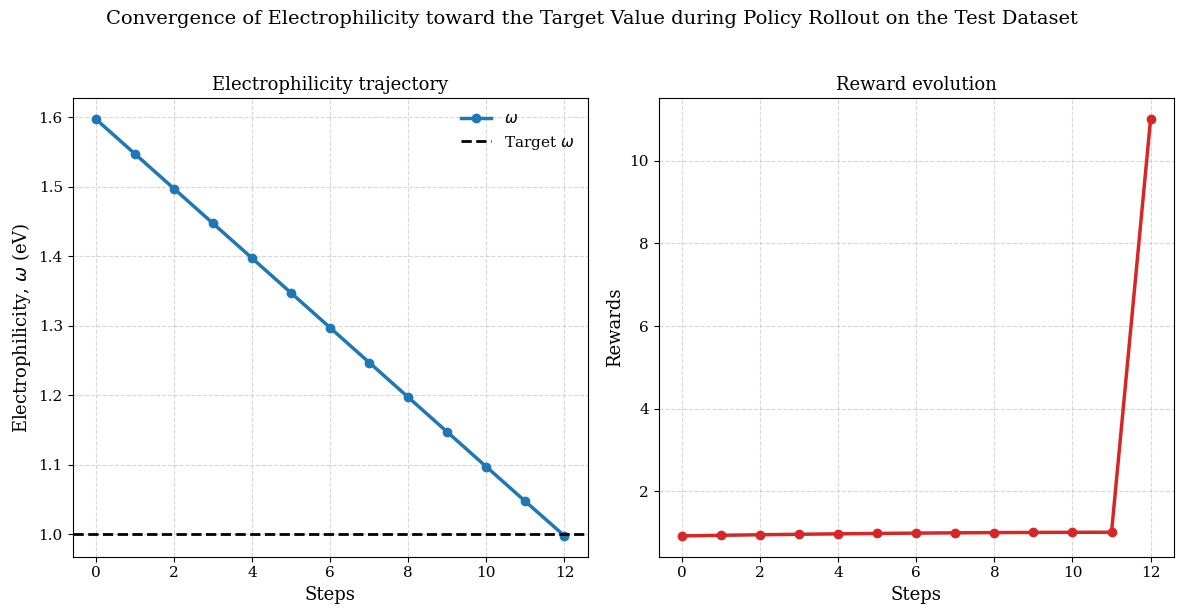

Saved episode trace to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/trace_td3_continued_5000.png
Saved validated actor to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/best_actor_td3_validated_5000.pth

=== Extended validation for 10000 episodes ===
Validation: Success=0.649, MeanDist=0.0915


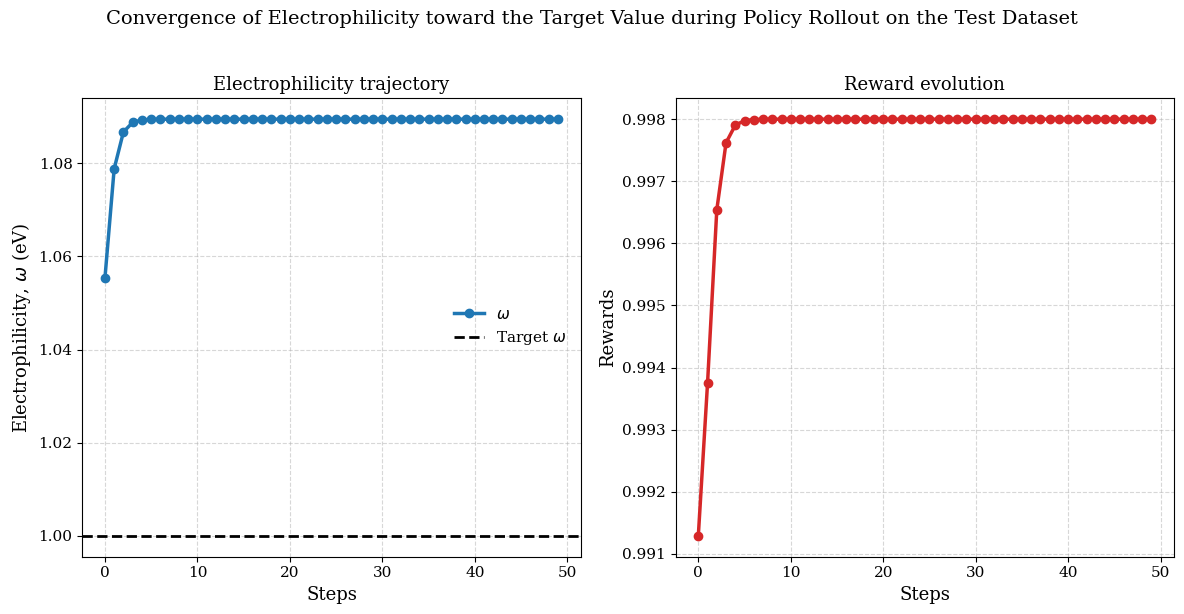

Saved episode trace to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/trace_td3_continued_10000.png
Saved validated actor to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/best_actor_td3_validated_10000.pth

=== Extended validation for 20000 episodes ===
Validation: Success=0.664, MeanDist=0.0903


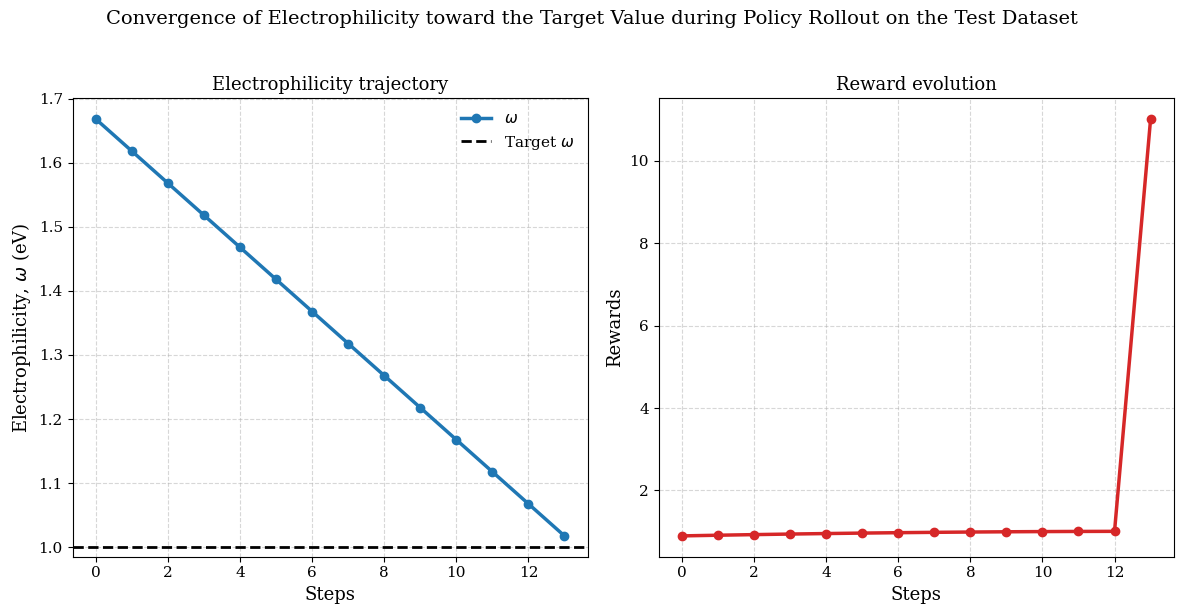

Saved episode trace to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/trace_td3_continued_20000.png
Saved validated actor to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/best_actor_td3_validated_20000.pth

=== Extended validation for 40000 episodes ===
Validation: Success=0.661, MeanDist=0.0898


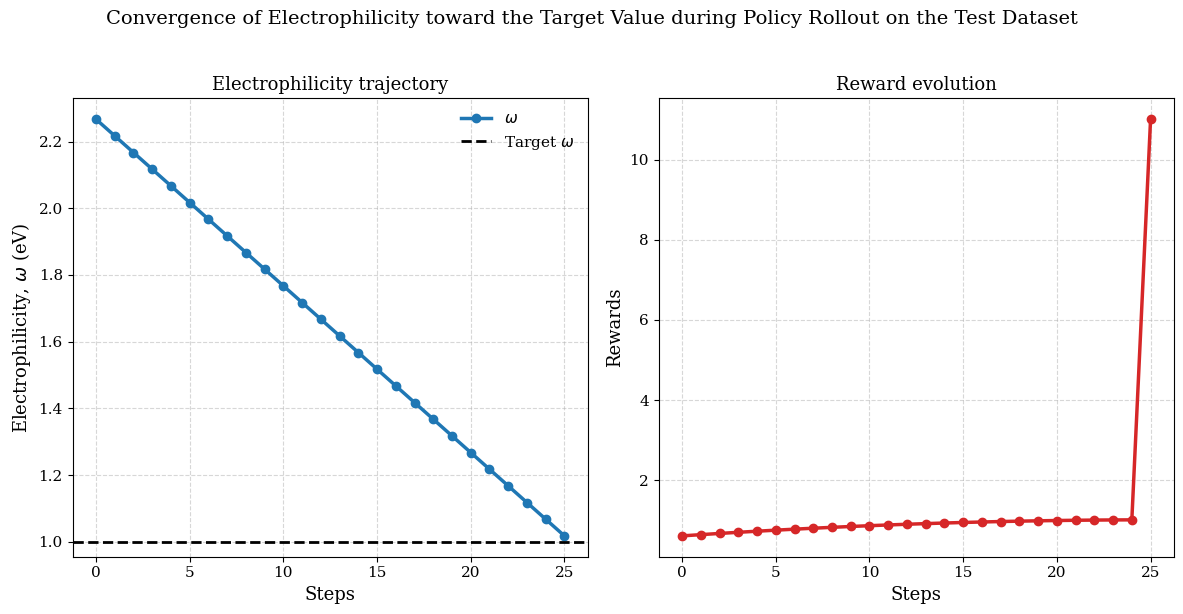

Saved episode trace to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/trace_td3_continued_40000.png
Saved validated actor to: /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/best_actor_td3_validated_40000.pth


In [ ]:
# =========================
# Longer runs of the best model from the grid search
# Reproducibility & Paths
# =========================

import os, re, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

BASE_DIR    = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
TRAIN_CSV   = os.path.join(BASE_DIR, "dataset", "train_dataset.csv")
VAL_CSV     = os.path.join(BASE_DIR, "dataset", "val_dataset.csv")
RESULTS_DIR = os.path.join(BASE_DIR, "Results")
PLOTS_DIR   = os.path.join(BASE_DIR, "plots")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

BEST_ACTOR  = os.path.join(RESULTS_DIR, "best_actor_td3.pth")
BEST_CRITIC = os.path.join(RESULTS_DIR, "best_critic_td3.pth")

STATE_COLUMNS = [
    'Electronegativity','Hardness','Electrophilicity','q(N)',
    'f-','f+','f0','s-','s+','s0','s+/s-','s-/s+','s(2)'
]
OMEGA_COL = 'Electrophilicity'


# =========================
# Preprocessing
# =========================

def _safe_ratio(num, den, eps=1e-8):
    n = np.asarray(num, dtype=np.float64)
    d = np.asarray(den, dtype=np.float64)
    return (n) / (np.sign(d) * np.maximum(np.abs(d), eps))

def preprocess_dataframe(df: pd.DataFrame, fit_scaler=False, scaler=None):
    df = df.copy()
    missing = [c for c in STATE_COLUMNS if c not in df.columns]
    for c in missing:
        df[c] = np.nan

    if 's+/s-' not in df.columns:
        df['s+/s-'] = _safe_ratio(df.get('s+', 0.0), df.get('s-', 1.0))
    if 's-/s+' not in df.columns:
        df['s-/s+'] = _safe_ratio(df.get('s-', 0.0), df.get('s+', 1.0))

    df[STATE_COLUMNS] = df[STATE_COLUMNS].ffill().bfill()
    df['f-'] = df['f-'].clip(-1.0, 1.0)
    df['f+'] = df['f+'].clip(-1.0, 1.0)
    df['f0'] = df['f0'].clip(-1.0, 1.0)
    df[OMEGA_COL] = df[OMEGA_COL].clip(0.0, 6.5)
    df = df[STATE_COLUMNS]

    if fit_scaler:
        mu = df.mean(numeric_only=True)
        sd = df.std(numeric_only=True).replace(0.0, 1.0)
        scaler = {'mu': mu, 'sd': sd}

    mu = scaler['mu'] if scaler else df.mean(numeric_only=True)
    sd = scaler['sd'] if scaler else df.std(numeric_only=True).replace(0.0, 1.0)

    df_scaled = (df - mu) / sd
    df_scaled['_omega_unscaled'] = df[OMEGA_COL].values.astype(np.float32)
    df_scaled['_omega_mu'] = mu[OMEGA_COL]
    df_scaled['_omega_sd'] = sd[OMEGA_COL] if sd[OMEGA_COL] != 0 else 1.0
    return df_scaled.reset_index(drop=True), scaler


# =========================
# Environment
# =========================

class ContinuousRadicalEnv:
    def __init__(self, df_scaled, target_omega=1.0,
                 success_thr=0.05, rmax=2.0, success_bonus=10.0):
        self.df = df_scaled.reset_index(drop=True)
        self.state_columns = STATE_COLUMNS
        self.num_features = len(self.state_columns)
        self.target_omega = float(target_omega)
        self.success_thr = float(success_thr)
        self.rmax = float(rmax)
        self.success_bonus = float(success_bonus)
        self.omega_clip = (0.0, 6.5)
        self.high_omega_terminate = 5.0
        self.high_omega_penalty = -5.0
        self.start_policy = 'mixed'
        self.state = None
        self.idx = None

    def set_success_threshold(self, thr):
        self.success_thr = float(thr)

    def set_start_policy(self, policy: str):
        self.start_policy = policy

    def reset(self):
        df = self.df
        if self.start_policy in ('below', 'above'):
            mask = (df['_omega_unscaled'] < self.target_omega) if (self.start_policy=='below') \
                   else (df['_omega_unscaled'] > self.target_omega)
            sub = df[mask]
            df = sub if len(sub) > 0 else df
        self.idx = int(np.random.choice(df.index))
        self.state = df.loc[self.idx, self.state_columns].values.astype(np.float32)
        self.row_cache = df.loc[self.idx]
        return self.state.copy()

    def _success_bonus(self, omega):
        return self.success_bonus if abs(omega - self.target_omega) <= self.success_thr else 0.0

    def _proximity_reward(self, omega):
        dist = abs(omega - self.target_omega)
        return max(0.0, 1.0 - (dist / self.rmax)**2)

    def step(self, delta_omega, pos_clip, neg_clip):
        state = self.state
        omega_mu = float(self.row_cache['_omega_mu'])
        omega_sd = float(self.row_cache['_omega_sd'])
        omega_scaled = float(state[2])

        prev_omega = omega_sd * omega_scaled + omega_mu
        prev_dist  = abs(prev_omega - self.target_omega)

        a = float(np.clip(delta_omega, -neg_clip, +pos_clip))
        new_omega = np.clip(prev_omega + a, *self.omega_clip)
        new_dist  = abs(new_omega - self.target_omega)

        done, penalty = False, 0.0
        if new_omega >= self.high_omega_terminate:
            done, penalty = True, self.high_omega_penalty
        if new_dist <= self.success_thr:
            done = True

        proximity = self._proximity_reward(new_omega)
        progress  = 0.2 * (prev_dist - new_dist)
        bonus     = self._success_bonus(new_omega)
        reward = proximity + progress + bonus + penalty

        new_omega_scaled = (new_omega - omega_mu) / (omega_sd if omega_sd != 0 else 1.0)
        new_state = state.copy()
        new_state[2] = new_omega_scaled
        self.state = new_state

        return new_state.copy(), float(reward), done, {"omega": new_omega, "delta_clamped": a}


# =========================
# TD3 Networks
# =========================

def mlp(sizes, act_last=None):
    layers = []
    for i in range(len(sizes)-2):
        layers += [nn.Linear(sizes[i], sizes[i+1]), nn.ReLU()]
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if act_last == 'tanh':
        layers.append(nn.Tanh())
    return nn.Sequential(*layers)

class Actor(nn.Module):
    def __init__(self, state_dim, hidden):
        super().__init__()
        self.body = mlp([state_dim, hidden, hidden, 1], act_last='tanh')
    def forward(self, s):
        return self.body(s).squeeze(1)

class Critic(nn.Module):
    def __init__(self, state_dim, hidden):
        super().__init__()
        self.q1 = mlp([state_dim+1, hidden, hidden, 1])
        self.q2 = mlp([state_dim+1, hidden, hidden, 1])
    def forward(self, s, a):
        x = torch.cat([s, a], dim=1)
        return self.q1(x).squeeze(1), self.q2(x).squeeze(1)


# =========================
# Validation
# =========================

def validate(env, actor, episodes=200, max_steps=50,
             pos_clip=0.05, neg_clip=0.05, success_thr=0.02):
    device = next(actor.parameters()).device
    env.set_success_threshold(success_thr)
    env.set_start_policy('mixed')
    successes, final_dists = 0, []

    with torch.no_grad():
        for _ in range(episodes):
            s = env.reset()
            omega_final = None
            for _ in range(max_steps):
                s_t = torch.from_numpy(s).float().unsqueeze(0).to(device)
                raw = actor(s_t).item()
                a = raw*pos_clip if raw >= 0 else raw*neg_clip
                s, _, done, info = env.step(a, pos_clip=pos_clip, neg_clip=neg_clip)
                omega_final = info["omega"]
                if done:
                    break
            if abs(omega_final - env.target_omega) <= success_thr:
                successes += 1
            final_dists.append(abs(omega_final - env.target_omega))

    return successes/episodes, float(np.mean(final_dists))


# =========================
# Publication-quality Plot (Two columns + overall title)
# =========================

def plot_episode_trace(env, actor, steps=50, fname="trace_td3.png",
                       pos_clip=0.05, neg_clip=0.05):
    device = next(actor.parameters()).device
    env.set_start_policy('mixed')
    s = env.reset()
    omegas, rewards = [], []

    with torch.no_grad():
        for _ in range(steps):
            s_t = torch.from_numpy(s).float().unsqueeze(0).to(device)
            raw = actor(s_t).item()
            a = raw*pos_clip if raw >= 0 else raw*neg_clip
            s, r, done, info = env.step(a, pos_clip=pos_clip, neg_clip=neg_clip)
            omegas.append(info["omega"])
            rewards.append(r)
            if done:
                break

    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 12,
        "axes.labelsize": 13,
        "axes.titlesize": 13,
        "legend.fontsize": 11,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11
    })

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    steps_range = np.arange(len(omegas))

    ax1.plot(steps_range, omegas, lw=2.5, marker='o',color="tab:blue", label=r"$\omega$")
    ax1.axhline(env.target_omega, lw=2, ls="--", color="black",
                label=r"Target $\omega$")
    ax1.set_xlabel("Steps")
    ax1.set_ylabel(r"Electrophilicity, $\omega$ (eV)")
    ax1.set_title("Electrophilicity trajectory")
    ax1.grid(True, ls="--", alpha=0.5)
    ax1.legend(frameon=False)

    ax2.plot(steps_range, rewards, marker='o', lw=2.5, color="tab:red")
    ax2.set_xlabel("Steps")
    ax2.set_ylabel("Rewards")
    ax2.set_title("Reward evolution")
    ax2.grid(True, ls="--", alpha=0.5)

    fig.suptitle(
        r"Convergence of Electrophilicity toward the Target Value during Policy Rollout on the Test Dataset",
        fontsize=14, y=1.02
    )

    fig.tight_layout()
    out_path = os.path.join(PLOTS_DIR, fname)
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved episode trace to: {out_path}")


# =========================
# Extended Validation Runner
# =========================

def continue_best_for_budgets(budgets=(1000,2000,5000)):
    raw_va = pd.read_csv(VAL_CSV)
    val_df, _ = preprocess_dataframe(raw_va, fit_scaler=False, scaler=None)

    env_val = ContinuousRadicalEnv(val_df, target_omega=1.0,
                                   success_thr=0.02, rmax=2.0, success_bonus=10.0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hidden_best = 128

    actor = Actor(env_val.num_features, hidden_best).to(device)
    critic = Critic(env_val.num_features, hidden_best).to(device)
    actor.load_state_dict(torch.load(BEST_ACTOR, map_location=device))
    critic.load_state_dict(torch.load(BEST_CRITIC, map_location=device))
    actor.eval(); critic.eval()

    for ep_budget in budgets:
        print(f"\n=== Extended validation for {ep_budget} episodes ===")
        sr, dist = validate(env_val, actor,
                            episodes=ep_budget, max_steps=50,
                            pos_clip=0.05, neg_clip=0.05, success_thr=0.02)
        print(f"Validation: Success={sr:.3f}, MeanDist={dist:.4f}")

        plot_episode_trace(env_val, actor, steps=50,
                           fname=f"trace_td3_continued_{ep_budget}.png")

        save_path = os.path.join(RESULTS_DIR, f"best_actor_td3_validated_{ep_budget}.pth")
        torch.save(actor.state_dict(), save_path)
        print(f"Saved validated actor to: {save_path}")


# =========================
# Run
# =========================

if __name__ == "__main__":
    continue_best_for_budgets(budgets=(1000,2000,3000,4000,5000,10000,20000,40000))



PLS Baseline (Validation set):
  Success rate (±0.02 band) : 3.1%
  Mean final |ω-1| distance : 0.5878


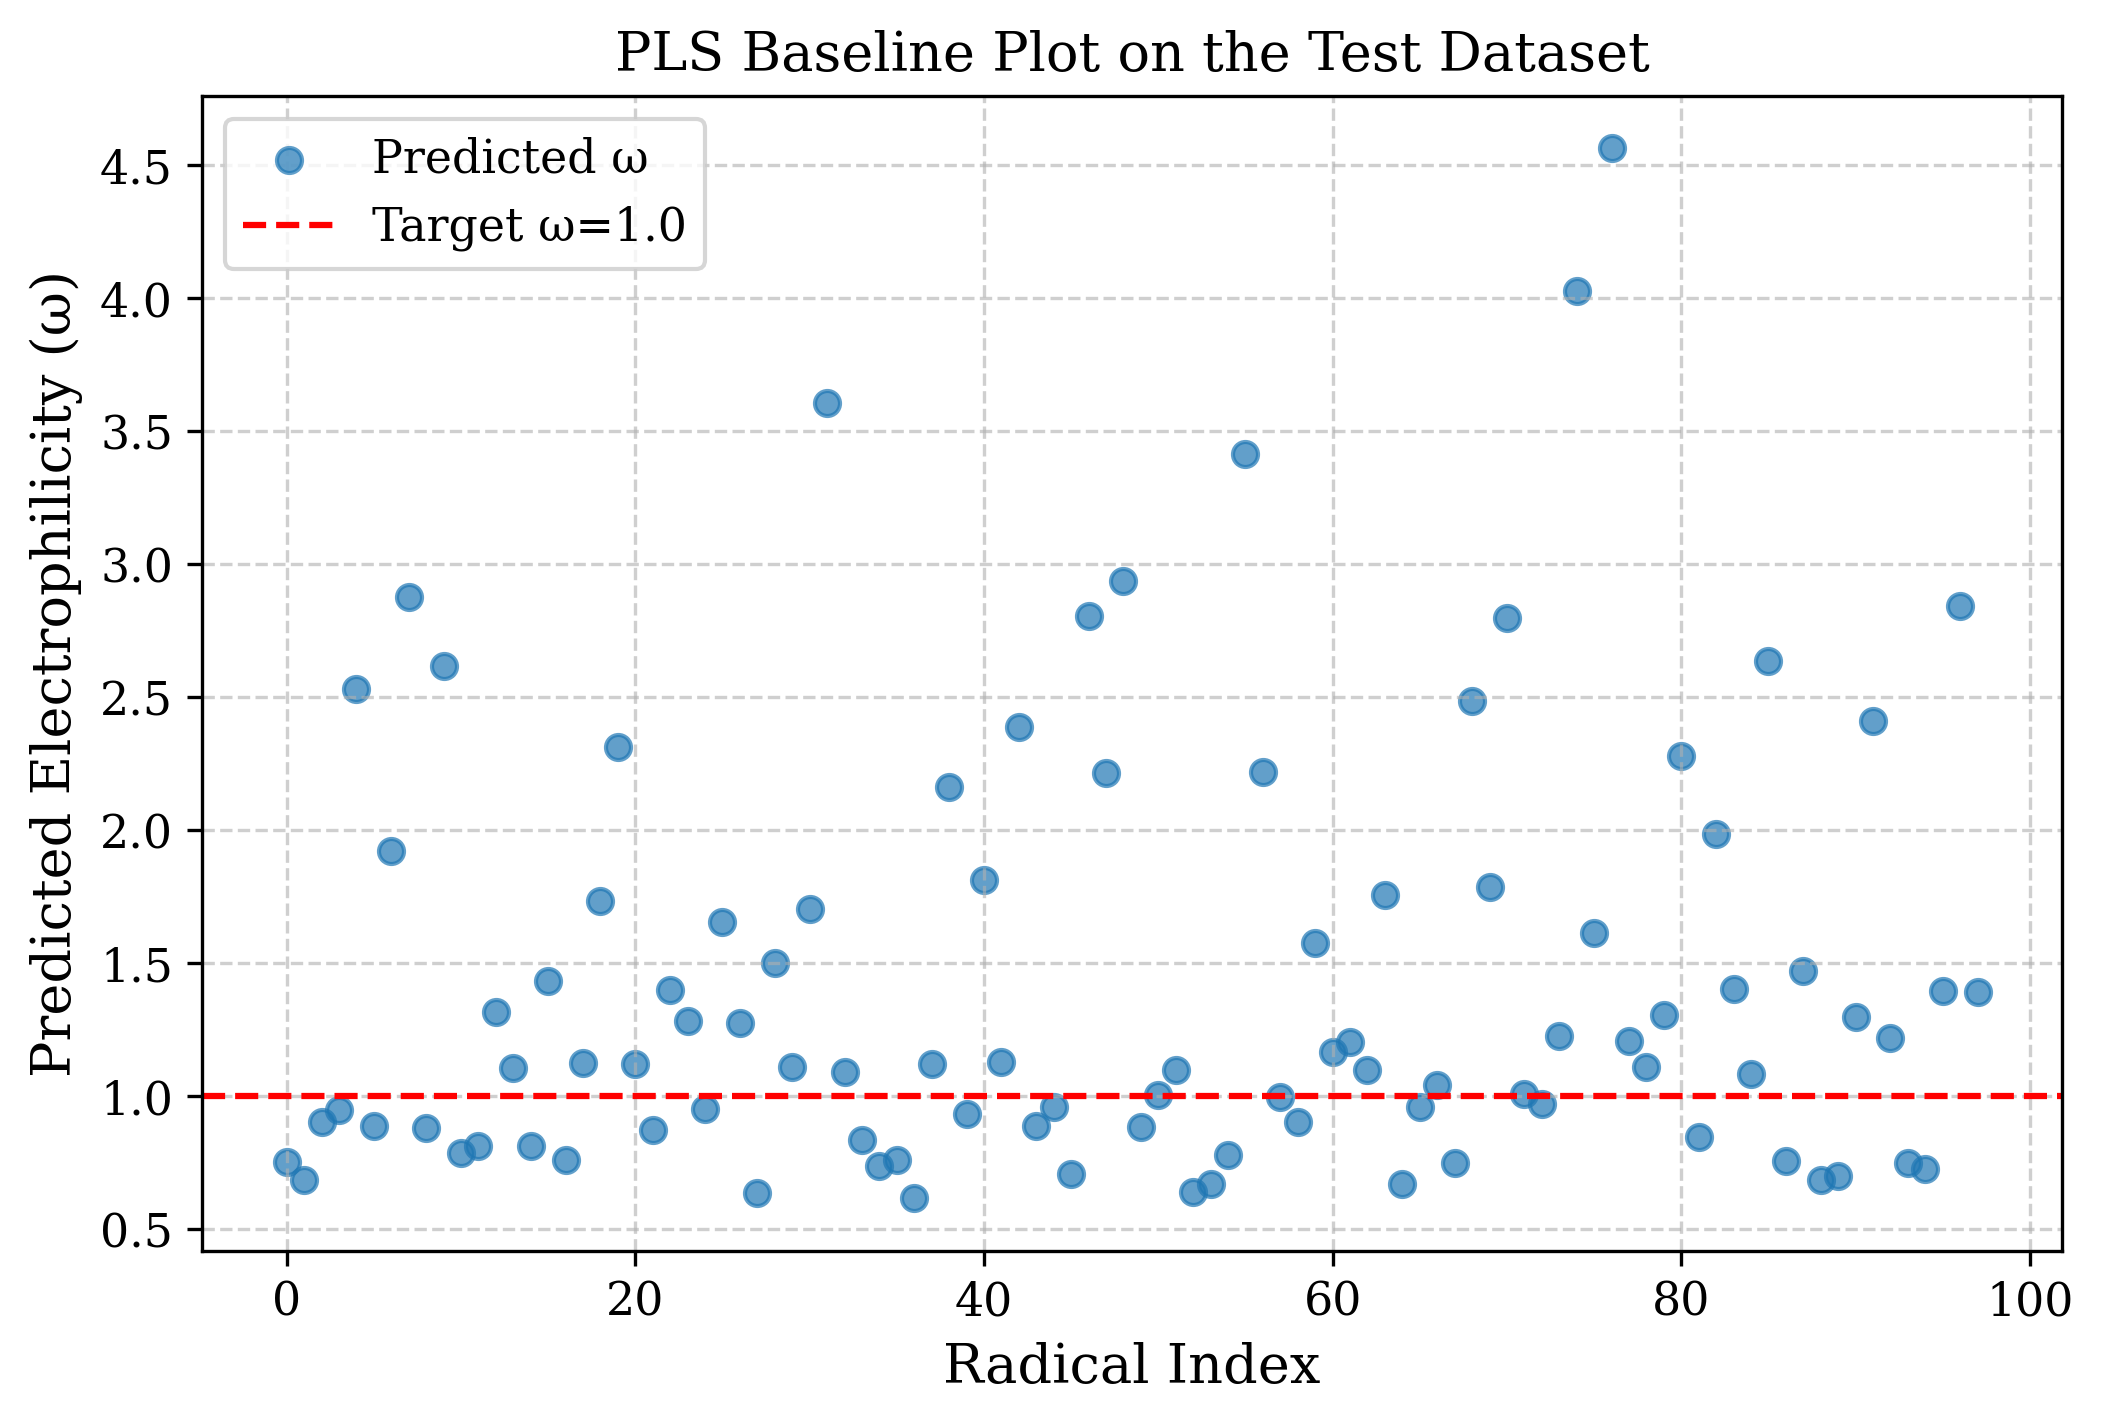

Baseline plot saved → /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/episode_trace_val_pls.png


In [ ]:
# Baseline: PLS Regression → evaluate on validation set

from sklearn.cross_decomposition import PLSRegression


# Paths

BASE_DIR    = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
TRAIN_CSV   = os.path.join(BASE_DIR, "dataset", "train_dataset.csv")
VAL_CSV     = os.path.join(BASE_DIR, "dataset", "val_dataset.csv")
RESULTS_DIR = os.path.join(BASE_DIR, "Results")
PLOTS_DIR   = os.path.join(BASE_DIR, "plots")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)


# Settings

STATE_COLUMNS = [
    'Electronegativity','Hardness','Electrophilicity','q(N)',
    's-','s+','s0','s+/s-','s-/s+','s(2)'
]
TARGET_COLUMNS = ['Electrophilicity','f-','f+','f0']

TARGET_OMEGA = 1.0
SUCCESS_THR  = 0.02   # strict band ±0.02


# Load datasets

df_train = pd.read_csv(TRAIN_CSV)
df_val   = pd.read_csv(VAL_CSV)

X_train = df_train[STATE_COLUMNS].values
Y_train = df_train[TARGET_COLUMNS].values
X_val   = df_val[STATE_COLUMNS].values
Y_val   = df_val[TARGET_COLUMNS].values


# Train PLS

pls = PLSRegression(n_components=5)
pls.fit(X_train, Y_train)


# Predict on validation dataset

Y_pred = pls.predict(X_val)

# Extract ω predictions
omega_pred = Y_pred[:,0]

# Success stats

success_flags = np.abs(omega_pred - TARGET_OMEGA) <= SUCCESS_THR
distances     = np.abs(omega_pred - TARGET_OMEGA)

success_rate = success_flags.mean()
mean_distance = distances.mean()

print("\nPLS Baseline (Validation set):")
print(f"  Success rate (±0.02 band) : {success_rate*100:.1f}%")
print(f"  Mean final |ω-1| distance : {mean_distance:.4f}")


# Plot ω predictions (scatter)

fig, ax = plt.subplots(figsize=(8,5), dpi=300)
ax.scatter(range(len(omega_pred)), omega_pred, c="tab:blue", label="Predicted ω", alpha=0.7)
ax.axhline(TARGET_OMEGA, ls="--", color="red", label="Target ω=1.0")

ax.set_xlabel("Radical Index")
ax.set_ylabel("Predicted Electrophilicity (ω)")
ax.set_title("PLS Baseline Plot on the Test Dataset")
ax.legend()
ax.grid(True, ls="--", alpha=0.6)

out_path = os.path.join(PLOTS_DIR, "episode_trace_val_pls.png")
plt.savefig(out_path, bbox_inches="tight")
plt.show()
print(f"Baseline plot saved → {out_path}")


In [ ]:

# Load best validated model (use only if the session is restarted)


BASE_DIR    = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
VAL_CSV     = os.path.join(BASE_DIR, "dataset", "val_dataset.csv")
RESULTS_DIR = os.path.join(BASE_DIR, "Results")
BEST_ACTOR  = os.path.join(RESULTS_DIR, "best_actor_td3_validated_5000.pth")

STATE_COLUMNS = [
    'Electronegativity','Hardness','Electrophilicity','q(N)',
    'f-','f+','f0','s-','s+','s0','s+/s-','s-/s+','s(2)'
]
OMEGA_COL = 'Electrophilicity'

# Preprocessing
def _safe_ratio(num, den, eps=1e-8):
    import numpy as np
    n = np.asarray(num, dtype=np.float64)
    d = np.asarray(den, dtype=np.float64)
    return (n) / (np.sign(d) * np.maximum(np.abs(d), eps))

def preprocess_dataframe(df: pd.DataFrame):
    import numpy as np
    if 's+/s-' not in df.columns:
        df['s+/s-'] = _safe_ratio(df.get('s+', 0.0), df.get('s-', 1.0))
    if 's-/s+' not in df.columns:
        df['s-/s+'] = _safe_ratio(df.get('s-', 0.0), df.get('s+', 1.0))
    df[STATE_COLUMNS] = df[STATE_COLUMNS].ffill().bfill()
    df['f-'] = df['f-'].clip(-1,1); df['f+'] = df['f+'].clip(-1,1); df['f0'] = df['f0'].clip(-1,1)
    df[OMEGA_COL] = df[OMEGA_COL].clip(0.0,6.5)
    df = df[STATE_COLUMNS]
    mu = df.mean(numeric_only=True); sd = df.std(numeric_only=True).replace(0.0,1.0)
    df_scaled = (df - mu) / sd
    df_scaled['_omega_unscaled'] = df[OMEGA_COL].values.astype(np.float32)
    df_scaled['_omega_mu'] = mu[OMEGA_COL]; df_scaled['_omega_sd'] = sd[OMEGA_COL]
    return df_scaled.reset_index(drop=True)

# Environment
class ContinuousRadicalEnv:
    def __init__(self, df_scaled, target_omega=1.0, success_thr=0.02, rmax=2.0, success_bonus=10.0):
        self.df = df_scaled.reset_index(drop=True)
        self.state_columns = STATE_COLUMNS; self.num_features = len(self.state_columns)
        self.target_omega = target_omega; self.success_thr = success_thr
        self.rmax = rmax; self.success_bonus = success_bonus
        self.omega_clip = (0.0,6.5); self.high_omega_terminate = 5.0; self.high_omega_penalty = -5.0
        self.state=None; self.idx=None
    def reset(self):
        import numpy as np
        self.idx = int(np.random.choice(self.df.index))
        self.state = self.df.loc[self.idx,self.state_columns].values.astype(np.float32)
        self.row_cache = self.df.loc[self.idx]; return self.state.copy()
    def _success_bonus(self,omega): return self.success_bonus if abs(omega-self.target_omega)<=self.success_thr else 0.0
    def _proximity_reward(self,omega): dist=abs(omega-self.target_omega); return max(0,1-(dist/self.rmax)**2)
    def step(self,delta,pos_clip,neg_clip):
        s=self.state; mu=float(self.row_cache['_omega_mu']); sd=float(self.row_cache['_omega_sd']); omega_scaled=float(s[2])
        prev=sd*omega_scaled+mu; dist0=abs(prev-self.target_omega)
        import numpy as np
        a=float(np.clip(delta,-neg_clip,+pos_clip))
        new=np.clip(prev+a,*self.omega_clip); dist1=abs(new-self.target_omega)
        done,penalty=False,0.0
        if new>=self.high_omega_terminate: done,penalty=True,self.high_omega_penalty
        if dist1<=self.success_thr: done=True
        r=self._proximity_reward(new)+0.2*(dist0-dist1)+self._success_bonus(new)+penalty
        new_scaled=(new-mu)/(sd if sd!=0 else 1.0); ns=s.copy(); ns[2]=new_scaled; self.state=ns
        return ns.copy(),float(r),done,{"omega":new,"delta_clamped":a}

# TD3 Actor
def mlp(sizes, act_last=None):
    layers=[];
    for i in range(len(sizes)-2): layers+=[nn.Linear(sizes[i],sizes[i+1]),nn.ReLU()]
    layers.append(nn.Linear(sizes[-2],sizes[-1]))
    if act_last=='tanh': layers.append(nn.Tanh())
    return nn.Sequential(*layers)

class Actor(nn.Module):
    def __init__(self,state_dim,hidden):
        super().__init__(); self.body=mlp([state_dim,hidden,hidden,1],act_last='tanh')
    def forward(self,s): return self.body(s).squeeze(1)

# Load best model once
def load_best_model():
    raw_va=pd.read_csv(VAL_CSV); val_df=preprocess_dataframe(raw_va)
    env=ContinuousRadicalEnv(val_df,target_omega=1.0,success_thr=0.02)
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    actor=Actor(env.num_features,hidden=128).to(device)  # hidden=128 from Code-1
    actor.load_state_dict(torch.load(BEST_ACTOR,map_location=device))
    actor.eval()
    print(f"Loaded validated actor from {BEST_ACTOR}")
    return actor, env

# Example usage
if __name__=="__main__":
    actor, env = load_best_model()


Loaded validated actor from /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/Results/best_actor_td3_validated_5000.pth


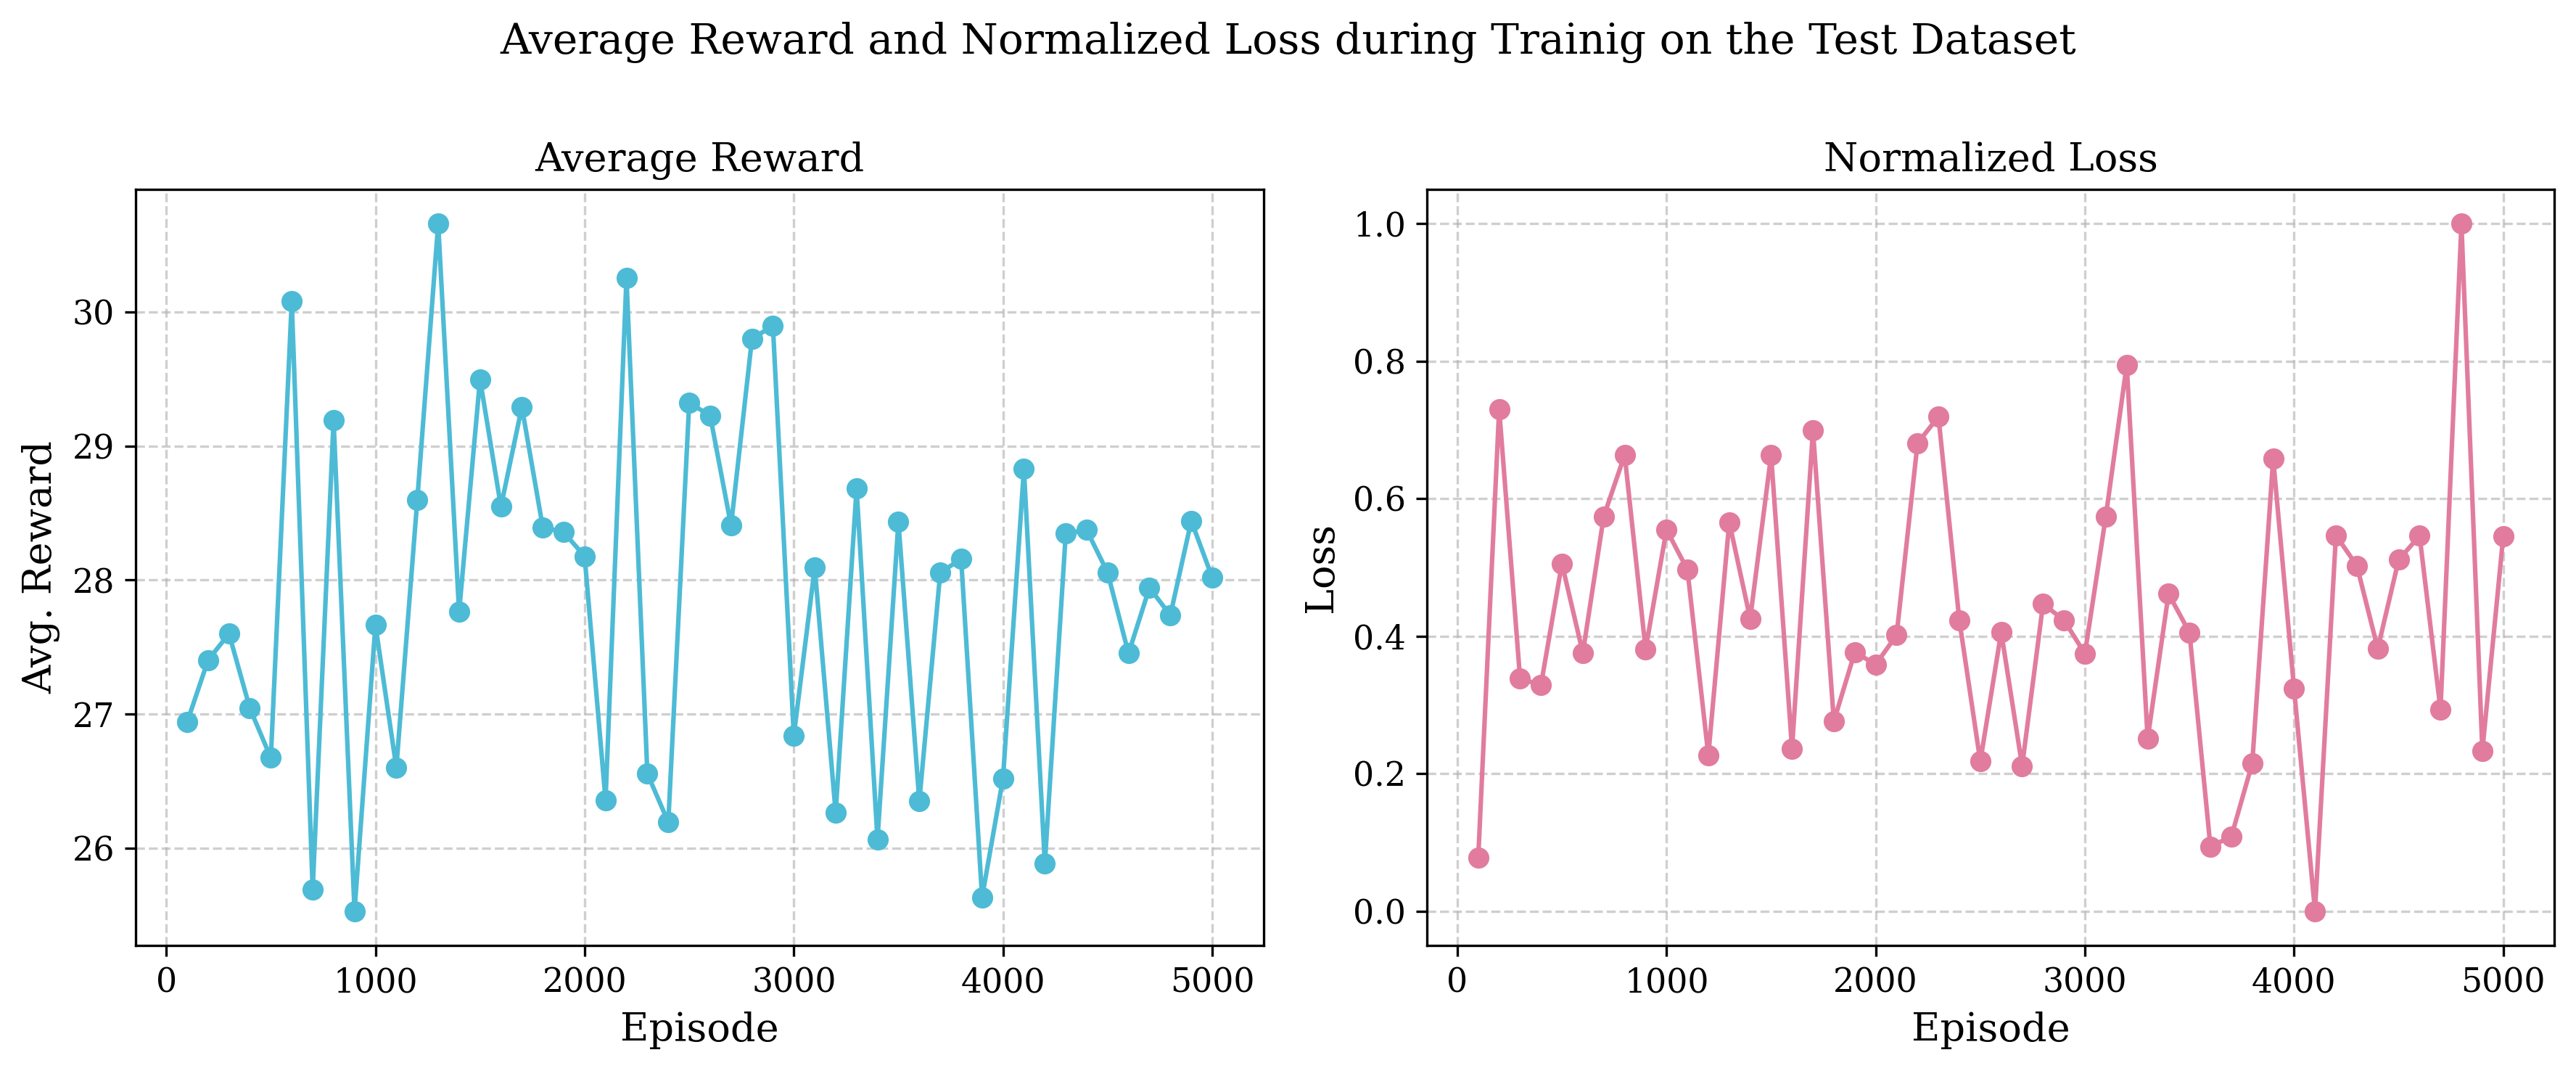

Saved normalized-loss plot to /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/best_actor_td3_validated_5000_binned100.png


In [ ]:
#  Downstream evaluation + plotting


import numpy as np
import matplotlib.pyplot as plt
import os

def evaluate_and_plot(actor, env,
                      num_episodes=5000,
                      max_steps=50,
                      block_size=100,
                      PLOTS_DIR="/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots",
                      tag="best_actor_td3_validated_5000"):
    """
    Evaluate a trained actor on the environment and plot
    binned average rewards and normalized loss proxies.
    """
    device = next(actor.parameters()).device
    actor.eval()

    rewards, losses = [], []

    with torch.no_grad():
        for ep in range(num_episodes):
            s = env.reset()
            ep_r, ep_loss = 0.0, 0.0
            for _ in range(max_steps):
                s_t = torch.from_numpy(s).float().unsqueeze(0).to(device)
                raw = actor(s_t).item()
                a = raw * 0.05 if raw >= 0 else raw * 0.05
                s, r, done, info = env.step(a, pos_clip=0.05, neg_clip=0.05)
                ep_r += r
                ep_loss += abs(info["omega"] - env.target_omega)
                if done:
                    break
            rewards.append(ep_r)
            losses.append(ep_loss / max_steps)

    # Bin results
    num_blocks = max(1, len(rewards) // block_size)
    avg_rews = [np.mean(rewards[i*block_size:(i+1)*block_size]) for i in range(num_blocks)]
    avg_losses = [np.mean(losses[i*block_size:(i+1)*block_size]) for i in range(num_blocks)]

    # Normalize losses
    min_l, max_l = np.min(avg_losses), np.max(avg_losses)
    norm_losses = [(l - min_l) / (max_l - min_l) if max_l > min_l else 0.0 for l in avg_losses]
    episode_bins = [(i+1) * block_size for i in range(num_blocks)]

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=300)
    fig.suptitle(
        f"Average Reward and Normalized Loss during Trainig on the Test Dataset",
        fontsize=14
    )

    # Rewards → pastel teal
    axes[0].plot(episode_bins, avg_rews, marker='o', linewidth=1.5, color="#4DBBD5")
    axes[0].set_title("Average Reward")
    axes[0].set_xlabel("Episode")
    axes[0].set_ylabel("Avg. Reward")
    axes[0].grid(True, linestyle="--", alpha=0.6)

    # Loss → pastel purple
    axes[1].plot(episode_bins, norm_losses, marker='o', linewidth=1.5, color="#E17C9E")
    axes[1].set_title("Normalized Loss")
    axes[1].set_xlabel("Episode")
    axes[1].set_ylabel("Loss")
    axes[1].grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    out_path = os.path.join(PLOTS_DIR, f"{tag}_binned{block_size}.png")
    fig.savefig(out_path)
    plt.show()

    print(f"Saved normalized-loss plot to {out_path}")


#  run

if __name__ == "__main__":
    evaluate_and_plot(actor, env,
                      num_episodes=5000,
                      max_steps=50,
                      block_size=100,
                      tag="best_actor_td3_validated_5000")


{'exp_hit_rate': 0.84, 'fukui_hit_rate': 1.0, 'multi_hit_rate': 0.84}


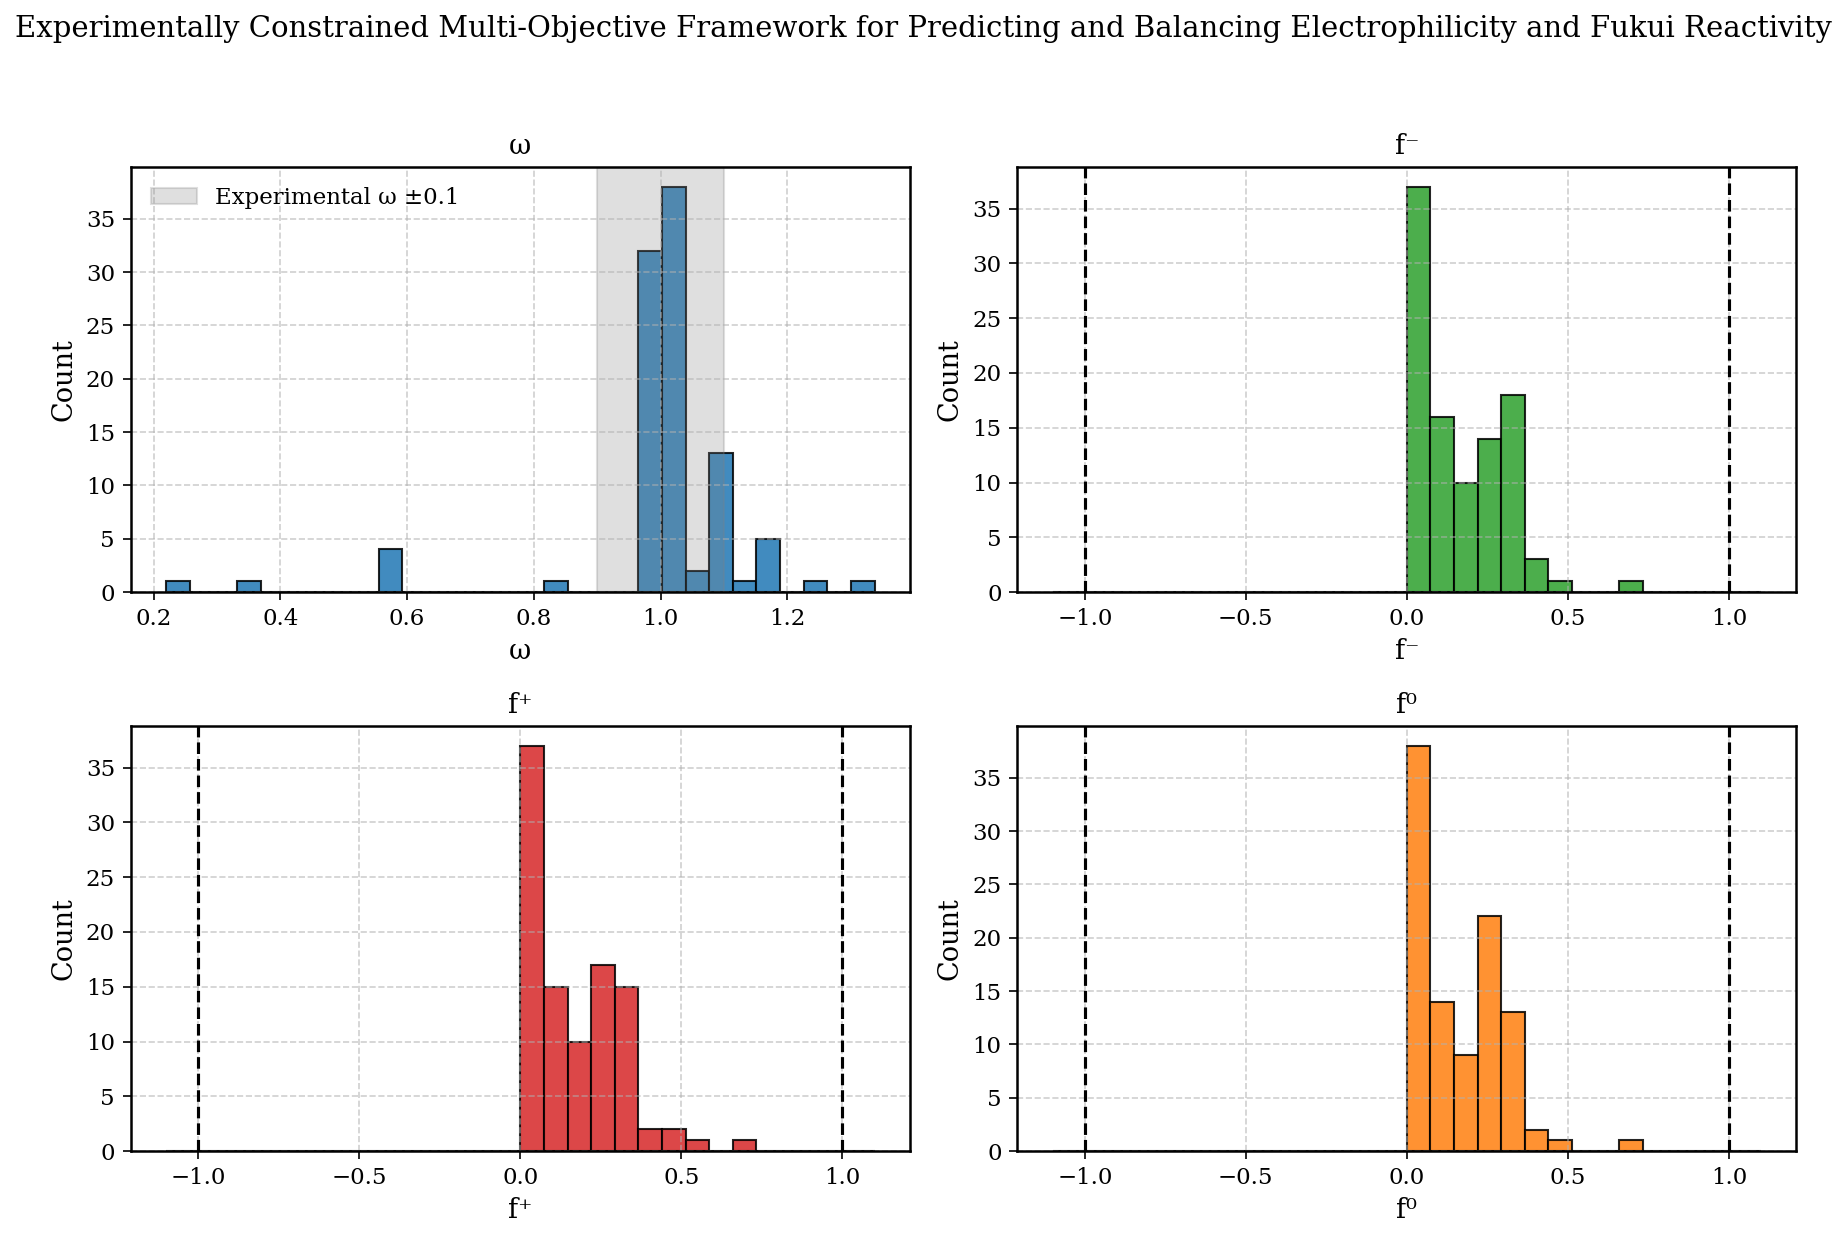

Saved multi-objective histograms → /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/best_actor_td3_validated_5000_multiobjective_histograms.png


In [ ]:
# Multi-objective downstream evaluation for TD3 actor


import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt


# Paths & constants

BASE_DIR    = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
VAL_CSV     = os.path.join(BASE_DIR, "dataset", "val_dataset.csv")
PLOTS_DIR   = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

STATE_COLUMNS = [
    'Electronegativity','Hardness','Electrophilicity','q(N)',
    'f-','f+','f0','s-','s+','s0','s+/s-','s-/s+','s(2)'
]
IDX_FM, IDX_FP, IDX_F0 = 4, 5, 6   # indices of f-, f+, f0 in state

TARGET_OMEGA = 1.0
OMEGA_TOL    = 0.10
F_BOUNDS     = {'f-': (-1.0, 1.0), 'f+': (-1.0, 1.0), 'f0': (-1.0, 1.0)}

POS_CLIP, NEG_CLIP = 0.05, 0.05


# Helper Functions

def _compute_val_scaler(val_csv: str):
    """Mean/std from raw validation CSV (to invert z-score)."""
    raw = pd.read_csv(val_csv)
    mu = raw[STATE_COLUMNS].mean(numeric_only=True)
    sd = raw[STATE_COLUMNS].std(numeric_only=True).replace(0.0, 1.0)
    return mu, sd

@torch.no_grad()
def _rollout(actor, env, max_steps=50):
    """Rollout actor policy; returns final scaled state and last unscaled ω."""
    device = next(actor.parameters()).device
    s = env.reset()
    last_omega = None
    for _ in range(max_steps):
        st = torch.from_numpy(s).float().unsqueeze(0).to(device)
        raw = actor(st).item()
        a = raw*POS_CLIP if raw >= 0 else raw*NEG_CLIP
        s, _, done, info = env.step(a, pos_clip=POS_CLIP, neg_clip=NEG_CLIP)
        last_omega = float(info["omega"])
        if done: break
    return s, last_omega

def _unscale_feature(z, mu, sd, name):
    raw = float(z) * float(sd[name]) + float(mu[name])
    if name in ('f-','f+','f0'):
        raw = float(np.clip(raw, -1.0, 1.0))
    return raw


# Main evaluation

def evaluate_multiobjective(actor, env,
                            trials=100, steps=10,
                            bench=(TARGET_OMEGA,),
                            save_name="best_actor_td3_validated_5000_multiobjective_histograms.png"):
    mu, sd = _compute_val_scaler(VAL_CSV)

    omega_list, fm_list, fp_list, f0_list = [], [], [], []
    for _ in range(trials):
        s_final, omega = _rollout(actor, env, max_steps=steps)
        fm = _unscale_feature(s_final[IDX_FM], mu, sd, 'f-')
        fp = _unscale_feature(s_final[IDX_FP], mu, sd, 'f+')
        f0 = _unscale_feature(s_final[IDX_F0], mu, sd, 'f0')
        omega_list.append(omega); fm_list.append(fm); fp_list.append(fp); f0_list.append(f0)

    omega_arr = np.array(omega_list)
    fm_arr, fp_arr, f0_arr = np.array(fm_list), np.array(fp_list), np.array(f0_list)

    # --- Hit rates ---
    exp_hit = np.array([any(abs(w - b) <= OMEGA_TOL for b in bench) for w in omega_arr])
    fukui_hit = np.logical_and.reduce([
        (fm_arr >= F_BOUNDS['f-'][0]) & (fm_arr <= F_BOUNDS['f-'][1]),
        (fp_arr >= F_BOUNDS['f+'][0]) & (fp_arr <= F_BOUNDS['f+'][1]),
        (f0_arr >= F_BOUNDS['f0'][0]) & (f0_arr <= F_BOUNDS['f0'][1]),
    ])
    multi_hit = exp_hit & fukui_hit

    print({
        "exp_hit_rate":   float(exp_hit.mean()),
        "fukui_hit_rate": float(fukui_hit.mean()),
        "multi_hit_rate": float(multi_hit.mean())
    })

    # Plots
    plt.rcParams.update({"font.size":12, "axes.linewidth":1.2,
                         "xtick.major.size":4, "ytick.major.size":4})
    fig, ax = plt.subplots(2, 2, figsize=(12,8), dpi=150)
    ax = ax.flatten()

    # ω
    band_lo, band_hi = TARGET_OMEGA - OMEGA_TOL, TARGET_OMEGA + OMEGA_TOL
    ax[0].hist(omega_arr, bins=30, color="#1f77b4", alpha=0.85, edgecolor="black")
    ax[0].axvspan(band_lo, band_hi, color='gray', alpha=0.25, label=f"Experimental ω ±{OMEGA_TOL}")
    ax[0].set_title("ω"); ax[0].set_xlabel("ω"); ax[0].set_ylabel("Count"); ax[0].legend(frameon=False)
    ax[0].grid(True, linestyle="--", alpha=0.6)

    # f-
    ax[1].hist(fm_arr, bins=30, range=(-1.1,1.1), color="#2ca02c", alpha=0.85, edgecolor="black")
    ax[1].axvline(F_BOUNDS['f-'][0], ls='--', c='black'); ax[1].axvline(F_BOUNDS['f-'][1], ls='--', c='black')
    ax[1].set_title("f⁻"); ax[1].set_xlabel("f⁻"); ax[1].set_ylabel("Count")
    ax[1].grid(True, linestyle="--", alpha=0.6)

    # f+
    ax[2].hist(fp_arr, bins=30, range=(-1.1,1.1), color="#d62728", alpha=0.85, edgecolor="black")
    ax[2].axvline(F_BOUNDS['f+'][0], ls='--', c='black'); ax[2].axvline(F_BOUNDS['f+'][1], ls='--', c='black')
    ax[2].set_title("f⁺"); ax[2].set_xlabel("f⁺"); ax[2].set_ylabel("Count")
    ax[2].grid(True, linestyle="--", alpha=0.6)

    # f0
    ax[3].hist(f0_arr, bins=30, range=(-1.1,1.1), color="#ff7f0e", alpha=0.85, edgecolor="black")
    ax[3].axvline(F_BOUNDS['f0'][0], ls='--', c='black'); ax[3].axvline(F_BOUNDS['f0'][1], ls='--', c='black')
    ax[3].set_title("f⁰"); ax[3].set_xlabel("f⁰"); ax[3].set_ylabel("Count")
    ax[3].grid(True, linestyle="--", alpha=0.6)

    fig.suptitle("Experimentally Constrained Multi-Objective Framework for Predicting and Balancing Electrophilicity and Fukui Reactivity", fontsize=14, y=1.03)
    plt.tight_layout()

    out_path = os.path.join(PLOTS_DIR, save_name)
    plt.savefig(out_path, bbox_inches="tight")
    plt.show()
    print(f"Saved multi-objective histograms → {out_path}")



# Run

if __name__ == "__main__":
    # Stage-1 must have been run: actor, env = load_best_model()
    from __main__ import actor, env   # if running in same notebook
    evaluate_multiobjective(actor, env, trials=100, steps=250)


{'exp_hit_rate': 0.78, 'fukui_hit_rate': 1.0, 'multi_hit_rate': 0.78}


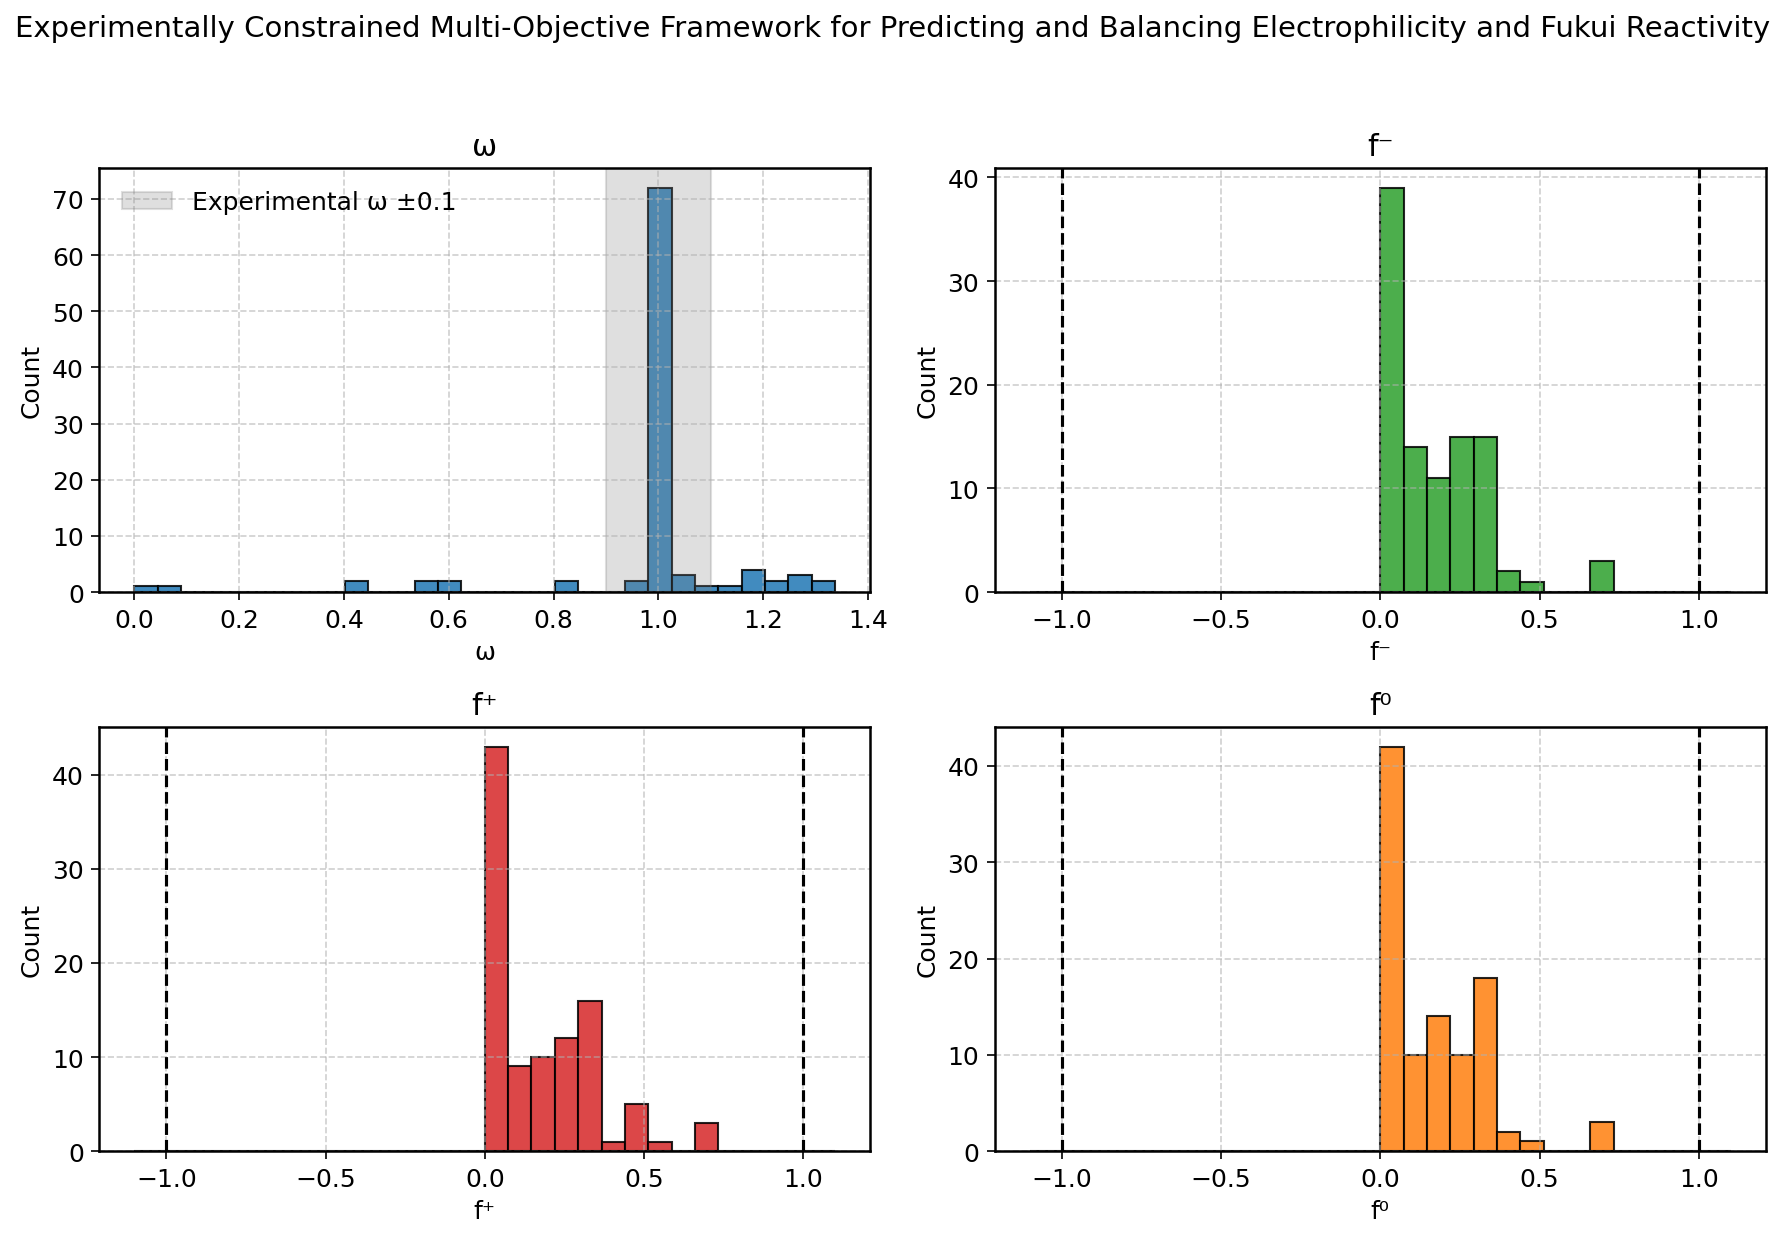

Saved multi-objective histograms → /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/best_actor_td3_validated_5000_multiobjective_histograms.png


In [ ]:
# Multi-objective downstream evaluation for TD3 actor


import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt


# Paths & constants

BASE_DIR    = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
VAL_CSV     = os.path.join(BASE_DIR, "dataset", "val_dataset.csv")
PLOTS_DIR   = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

STATE_COLUMNS = [
    'Electronegativity','Hardness','Electrophilicity','q(N)',
    'f-','f+','f0','s-','s+','s0','s+/s-','s-/s+','s(2)'
]
IDX_FM, IDX_FP, IDX_F0 = 4, 5, 6   # indices of f-, f+, f0 in state

TARGET_OMEGA = 1.0
OMEGA_TOL    = 0.10
F_BOUNDS     = {'f-': (-1.0, 1.0), 'f+': (-1.0, 1.0), 'f0': (-1.0, 1.0)}

POS_CLIP, NEG_CLIP = 0.05, 0.05


# Helper Functions

def _compute_val_scaler(val_csv: str):
    """Mean/std from raw validation CSV (to invert z-score)."""
    raw = pd.read_csv(val_csv)
    mu = raw[STATE_COLUMNS].mean(numeric_only=True)
    sd = raw[STATE_COLUMNS].std(numeric_only=True).replace(0.0, 1.0)
    return mu, sd

@torch.no_grad()
def _rollout(actor, env, max_steps=50):
    """Rollout actor policy; returns final scaled state and last unscaled ω."""
    device = next(actor.parameters()).device
    s = env.reset()
    last_omega = None
    for _ in range(max_steps):
        st = torch.from_numpy(s).float().unsqueeze(0).to(device)
        raw = actor(st).item()
        a = raw*POS_CLIP if raw >= 0 else raw*NEG_CLIP
        s, _, done, info = env.step(a, pos_clip=POS_CLIP, neg_clip=NEG_CLIP)
        last_omega = float(info["omega"])
        if done: break
    return s, last_omega

def _unscale_feature(z, mu, sd, name):
    raw = float(z) * float(sd[name]) + float(mu[name])
    if name in ('f-','f+','f0'):
        raw = float(np.clip(raw, -1.0, 1.0))
    return raw


# Main evaluation

def evaluate_multiobjective(actor, env,
                            trials=100, steps=10,
                            bench=(TARGET_OMEGA,),
                            save_name="best_actor_td3_validated_5000_multiobjective_histograms.png"):
    mu, sd = _compute_val_scaler(VAL_CSV)

    omega_list, fm_list, fp_list, f0_list = [], [], [], []
    for _ in range(trials):
        s_final, omega = _rollout(actor, env, max_steps=steps)
        fm = _unscale_feature(s_final[IDX_FM], mu, sd, 'f-')
        fp = _unscale_feature(s_final[IDX_FP], mu, sd, 'f+')
        f0 = _unscale_feature(s_final[IDX_F0], mu, sd, 'f0')
        omega_list.append(omega); fm_list.append(fm); fp_list.append(fp); f0_list.append(f0)

    omega_arr = np.array(omega_list)
    fm_arr, fp_arr, f0_arr = np.array(fm_list), np.array(fp_list), np.array(f0_list)

    # --- Hit rates ---
    exp_hit = np.array([any(abs(w - b) <= OMEGA_TOL for b in bench) for w in omega_arr])
    fukui_hit = np.logical_and.reduce([
        (fm_arr >= F_BOUNDS['f-'][0]) & (fm_arr <= F_BOUNDS['f-'][1]),
        (fp_arr >= F_BOUNDS['f+'][0]) & (fp_arr <= F_BOUNDS['f+'][1]),
        (f0_arr >= F_BOUNDS['f0'][0]) & (f0_arr <= F_BOUNDS['f0'][1]),
    ])
    multi_hit = exp_hit & fukui_hit

    print({
        "exp_hit_rate":   float(exp_hit.mean()),
        "fukui_hit_rate": float(fukui_hit.mean()),
        "multi_hit_rate": float(multi_hit.mean())
    })

    # Plots
    plt.rcParams.update({"font.size":12, "axes.linewidth":1.2,
                         "xtick.major.size":4, "ytick.major.size":4})
    fig, ax = plt.subplots(2, 2, figsize=(12,8), dpi=150)
    ax = ax.flatten()

    # ω
    band_lo, band_hi = TARGET_OMEGA - OMEGA_TOL, TARGET_OMEGA + OMEGA_TOL
    ax[0].hist(omega_arr, bins=30, color="#1f77b4", alpha=0.85, edgecolor="black")
    ax[0].axvspan(band_lo, band_hi, color='gray', alpha=0.25, label=f"Experimental ω ±{OMEGA_TOL}")
    ax[0].set_title("ω"); ax[0].set_xlabel("ω"); ax[0].set_ylabel("Count"); ax[0].legend(frameon=False)
    ax[0].grid(True, linestyle="--", alpha=0.6)

    # f-
    ax[1].hist(fm_arr, bins=30, range=(-1.1,1.1), color="#2ca02c", alpha=0.85, edgecolor="black")
    ax[1].axvline(F_BOUNDS['f-'][0], ls='--', c='black'); ax[1].axvline(F_BOUNDS['f-'][1], ls='--', c='black')
    ax[1].set_title("f⁻"); ax[1].set_xlabel("f⁻"); ax[1].set_ylabel("Count")
    ax[1].grid(True, linestyle="--", alpha=0.6)

    # f+
    ax[2].hist(fp_arr, bins=30, range=(-1.1,1.1), color="#d62728", alpha=0.85, edgecolor="black")
    ax[2].axvline(F_BOUNDS['f+'][0], ls='--', c='black'); ax[2].axvline(F_BOUNDS['f+'][1], ls='--', c='black')
    ax[2].set_title("f⁺"); ax[2].set_xlabel("f⁺"); ax[2].set_ylabel("Count")
    ax[2].grid(True, linestyle="--", alpha=0.6)

    # f0
    ax[3].hist(f0_arr, bins=30, range=(-1.1,1.1), color="#ff7f0e", alpha=0.85, edgecolor="black")
    ax[3].axvline(F_BOUNDS['f0'][0], ls='--', c='black'); ax[3].axvline(F_BOUNDS['f0'][1], ls='--', c='black')
    ax[3].set_title("f⁰"); ax[3].set_xlabel("f⁰"); ax[3].set_ylabel("Count")
    ax[3].grid(True, linestyle="--", alpha=0.6)

    fig.suptitle("Experimentally Constrained Multi-Objective Framework for Predicting and Balancing Electrophilicity and Fukui Reactivity", fontsize=14, y=1.03)
    plt.tight_layout()

    out_path = os.path.join(PLOTS_DIR, save_name)
    #plt.savefig(out_path, bbox_inches="tight")
    plt.show()
    print(f"Saved multi-objective histograms → {out_path}")



# Run

if __name__ == "__main__":
    # Stage-1 must have been run: actor, env = load_best_model()
    from __main__ import actor, env   # if running in same notebook
    evaluate_multiobjective(actor, env, trials=100, steps=250)


Class distribution in val set:
class
Oxygen substituted carbon radical      15
Nitrogen substituted carbon radical    14
Nitrogen radical                       12
Aliphatic carbon radical               11
Oxygen radical                          8
Sulfur radical                          8
Phosphoryl radical                      7
Silyl radical                           4
Sulfur substituted carbon radical       4
Halogen substituted carbon radical      4
Heteroaryl radical                      4
Boryl radical                           2
Biological radical                      2
Aromatic carbon radical                 2
Inorganic radical                       1
Name: count, dtype: int64

=== Overall hit rates ===
exp_hit      0.857143
fukui_hit    1.000000
multi_hit    0.857143
dtype: float64
Saved → /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/classwise_success_rates_percent.csv


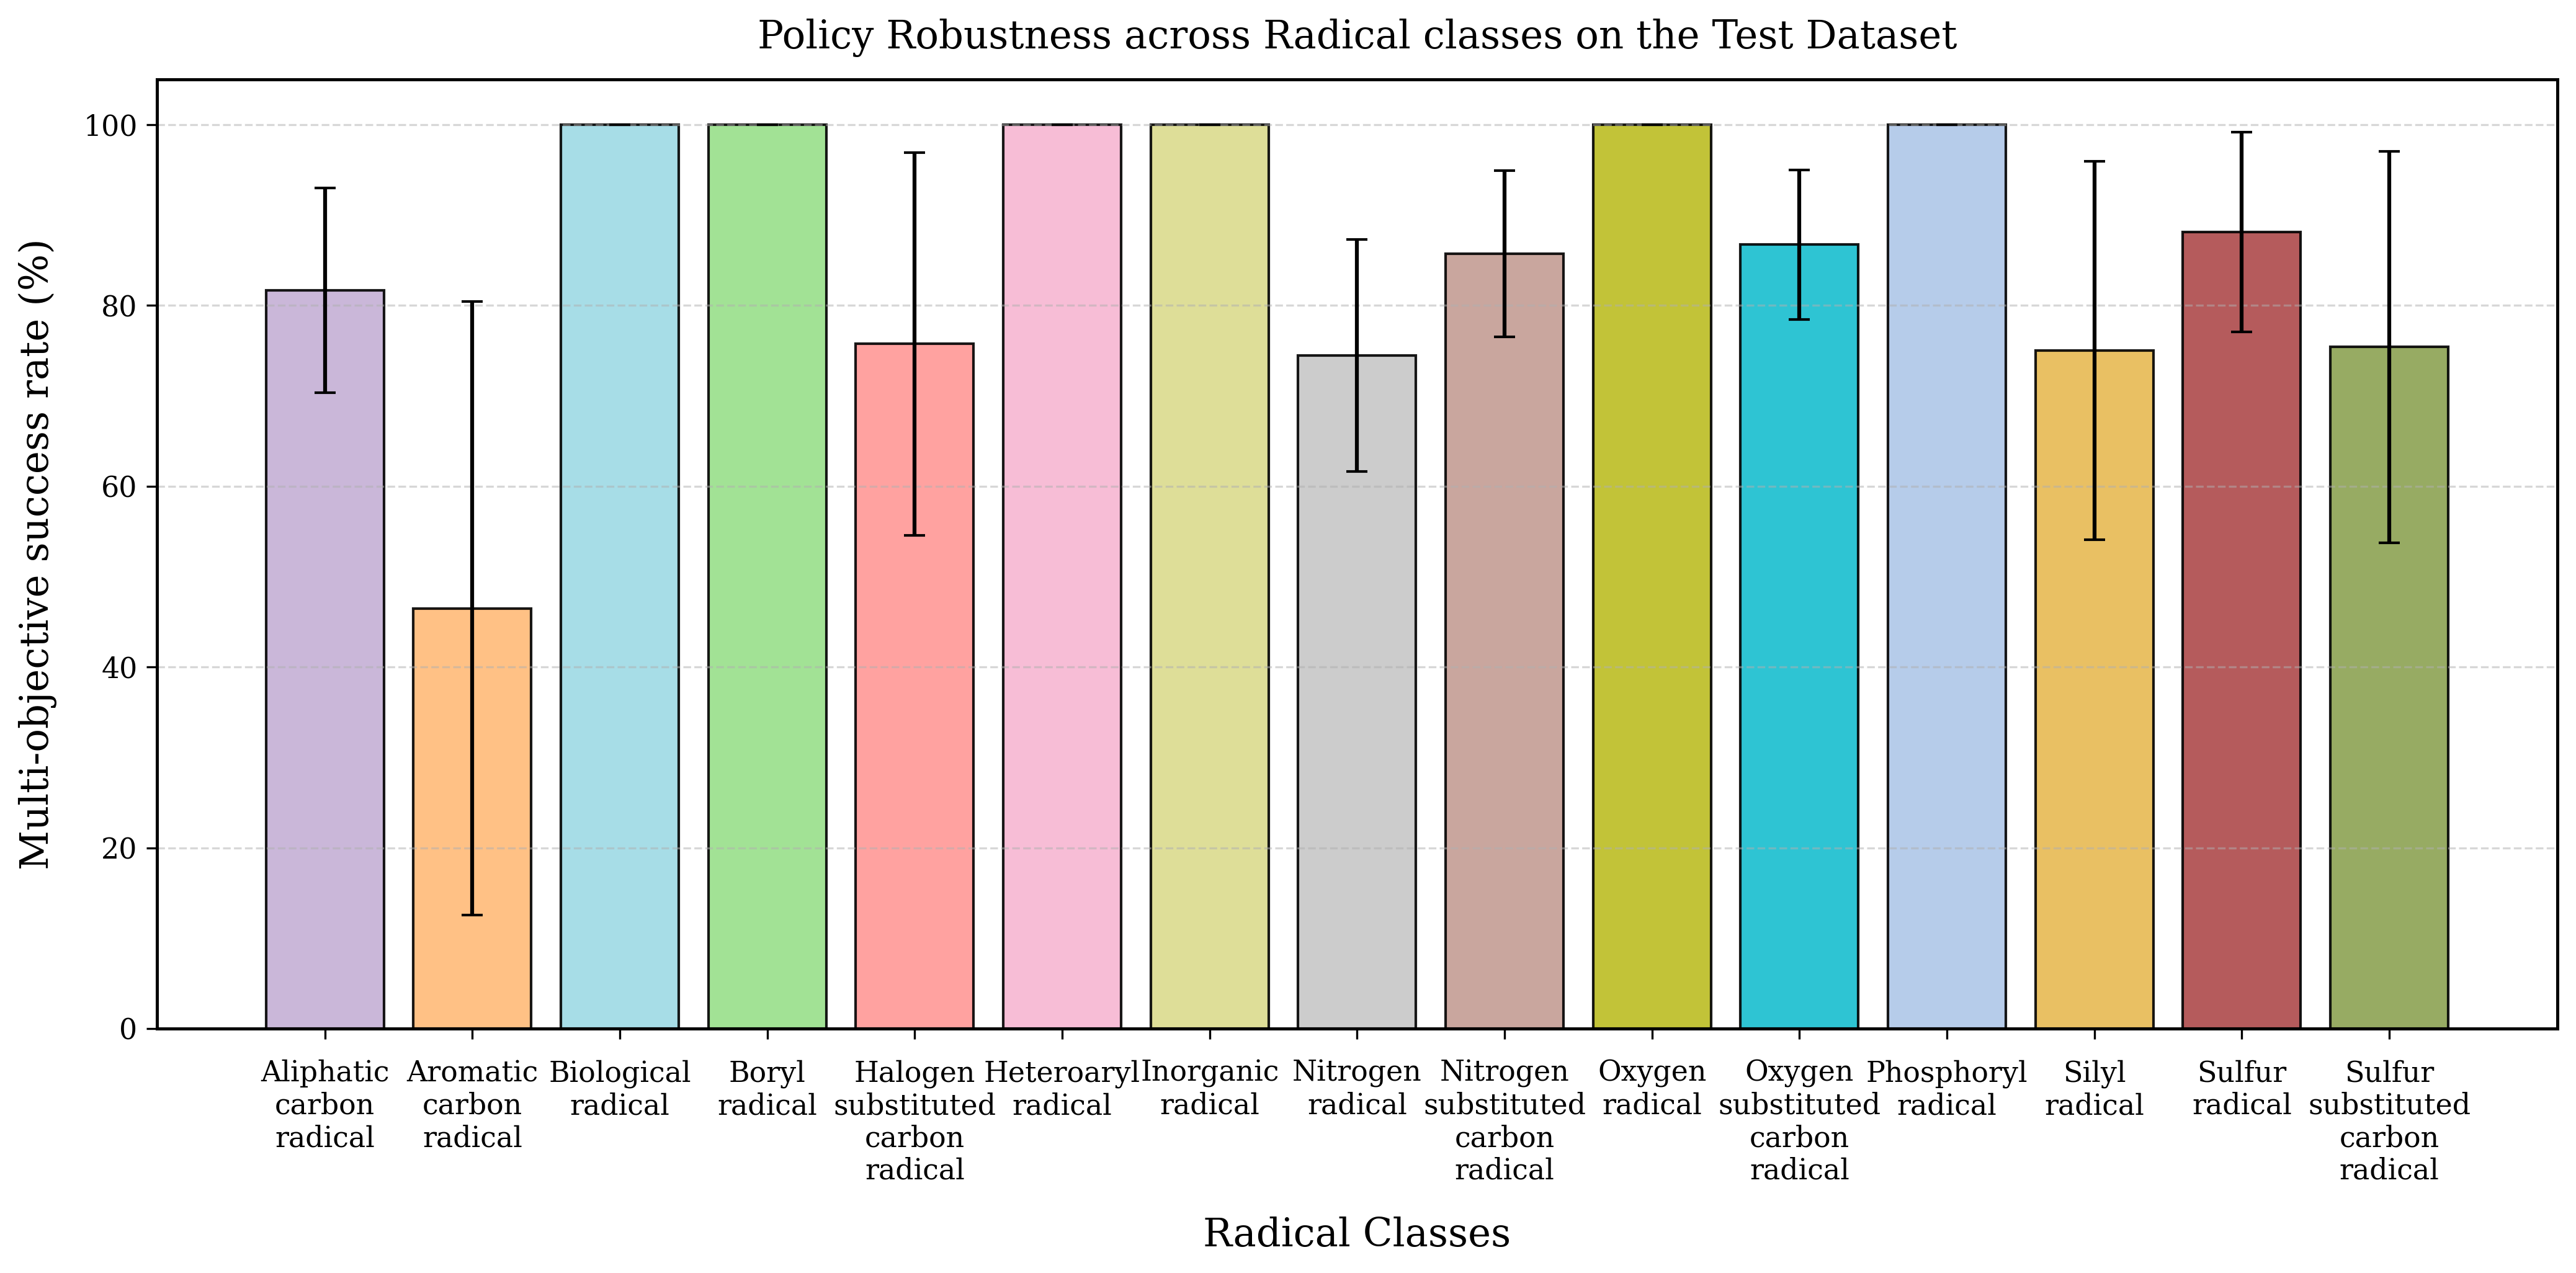

Saved → /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/classwise_multiobjective_success_percent.png


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import textwrap

# ============================================================
# PATHS
# ============================================================

BASE_DIR = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
VAL_CSV  = os.path.join(BASE_DIR, "dataset", "val_dataset.csv")
CLASS_XLSX = os.path.join(BASE_DIR, "dataset", "Radical_Name_List-2.xlsx")
PLOTS_DIR = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# ============================================================
# CONSTANTS
# ============================================================

STATE_COLUMNS = [
    'Electronegativity','Hardness','Electrophilicity','q(N)',
    'f-','f+','f0','s-','s+','s0','s+/s-','s-/s+','s(2)'
]
IDX_FM, IDX_FP, IDX_F0 = 4, 5, 6

TARGET_OMEGA = 1.0
OMEGA_TOL    = 0.10
F_BOUNDS     = {'f-': (-1.0, 1.0), 'f+': (-1.0, 1.0), 'f0': (-1.0, 1.0)}

POS_CLIP, NEG_CLIP = 0.05, 0.05
HIGH_OMEGA_THRESH = 2.0

# ============================================================
# LOAD VALIDATION DATA
# ============================================================

val_df = pd.read_csv(VAL_CSV)

if "Radical name" not in val_df.columns:
    raise ValueError("val_dataset.csv must contain column 'Radical name'.")

val_df["Radical name"] = val_df["Radical name"].astype(str).str.strip()

# ============================================================
# LOAD CLASS MAP
# ============================================================

motif_df = pd.read_excel(CLASS_XLSX)
motif_df["Radical name"] = motif_df["Radical name"].astype(str).str.strip()
motif_df["Classification"] = motif_df["Classification"].astype(str).str.strip()

class_map = dict(zip(motif_df["Radical name"], motif_df["Classification"]))
val_df["class"] = val_df["Radical name"].map(class_map).fillna("unknown")

print("Class distribution in val set:")
print(val_df["class"].value_counts())

# ============================================================
# SCALER
# ============================================================

def _compute_val_scaler(val_csv):
    raw = pd.read_csv(val_csv)
    mu = raw[STATE_COLUMNS].mean(numeric_only=True)
    sd = raw[STATE_COLUMNS].std(numeric_only=True).replace(0.0, 1.0)
    return mu, sd

mu, sd = _compute_val_scaler(VAL_CSV)

def _unscale_feature(z, name):
    raw = float(z) * float(sd[name]) + float(mu[name])
    if name in ('f-','f+','f0'):
        raw = float(np.clip(raw, -1.0, 1.0))
    return raw

def bootstrap_rate(arr, n_boot=500):
    arr = np.asarray(arr, dtype=float)
    if len(arr) == 0:
        return np.nan, np.nan
    means = [np.mean(np.random.choice(arr, size=len(arr), replace=True)) for _ in range(n_boot)]
    return float(np.mean(means)), float(np.std(means))

# ============================================================
# RESET ENV
# ============================================================

def reset_env_to_val_row(env, i, row):
    state_vec = row[STATE_COLUMNS].to_numpy(dtype=np.float32)

    for fn in [
        lambda: env.reset(i),
        lambda: env.reset(index=i),
        lambda: env.reset(idx=i),
        lambda: env.reset_from_index(i),
        lambda: env.reset_from_row(row)
    ]:
        try:
            s = fn()
            if isinstance(s, np.ndarray):
                return s
        except Exception:
            pass

    if hasattr(env, "set_state"):
        env.set_state(state_vec)
        return state_vec

    if hasattr(env, "state"):
        env.state = state_vec
        return state_vec

    raise RuntimeError("Env cannot be reset to validation row.")

# ============================================================
# ROLLOUT
# ============================================================

@torch.no_grad()
def rollout_from_state(actor, env, init_state, max_steps=250):
    device = next(actor.parameters()).device
    s = init_state

    init_omega = float(init_state[STATE_COLUMNS.index("Electrophilicity")])
    last_omega = np.nan
    converged = False

    for _ in range(max_steps):
        st = torch.from_numpy(s).float().unsqueeze(0).to(device)
        raw = actor(st).item()
        a = raw*POS_CLIP if raw >= 0 else raw*NEG_CLIP
        s, _, done, info = env.step(a, pos_clip=POS_CLIP, neg_clip=NEG_CLIP)
        last_omega = float(info.get("omega", np.nan))
        converged = bool(done)
        if done:
            break

    return s, init_omega, last_omega, converged

# ============================================================
# MAIN
# ============================================================

def evaluate_classwise(actor, env, steps=250):

    records = []

    for i in range(len(val_df)):
        row = val_df.iloc[i]
        cls = row["class"]

        s0 = reset_env_to_val_row(env, i, row)
        s_final, init_omega, omega_final, converged = rollout_from_state(actor, env, s0, steps)

        fm = _unscale_feature(s_final[IDX_FM], "f-")
        fp = _unscale_feature(s_final[IDX_FP], "f+")
        f0 = _unscale_feature(s_final[IDX_F0], "f0")

        exp_hit = abs(omega_final - TARGET_OMEGA) <= OMEGA_TOL
        fukui_hit = (
            (fm >= F_BOUNDS["f-"][0]) & (fm <= F_BOUNDS["f-"][1]) &
            (fp >= F_BOUNDS["f+"][0]) & (fp <= F_BOUNDS["f+"][1]) &
            (f0 >= F_BOUNDS["f0"][0]) & (f0 <= F_BOUNDS["f0"][1])
        )
        multi_hit = exp_hit and fukui_hit

        records.append({
            "class": cls,
            "exp_hit": float(exp_hit),
            "fukui_hit": float(fukui_hit),
            "multi_hit": float(multi_hit),
            "converged": float(converged),
            "omega_final": omega_final
        })

    df = pd.DataFrame(records)

    print("\n=== Overall hit rates ===")
    print(df[["exp_hit","fukui_hit","multi_hit"]].mean())

    summary = []
    for cls, g in df.groupby("class"):
        exp_m, exp_s = bootstrap_rate(g["exp_hit"])
        fk_m,  fk_s  = bootstrap_rate(g["fukui_hit"])
        mh_m,  mh_s  = bootstrap_rate(g["multi_hit"])

        summary.append({
            "class": cls,
            "N": len(g),
            "exp_hit": exp_m, "exp_std": exp_s,
            "fukui_hit": fk_m, "fukui_std": fk_s,
            "multi_hit": mh_m, "multi_std": mh_s,
            "nonconv_frac": 1 - g["converged"].mean(),
            "high_omega_start_frac": float(np.mean(g["omega_final"] > HIGH_OMEGA_THRESH))
        })

    sum_df = pd.DataFrame(summary).sort_values("class")

    sum_df_pct = sum_df.copy()
    for col in ["exp_hit", "exp_std", "fukui_hit", "fukui_std", "multi_hit", "multi_std"]:
        sum_df_pct[col] *= 100.0

    out_csv = os.path.join(PLOTS_DIR, "classwise_success_rates_percent.csv")
    sum_df_pct.to_csv(out_csv, index=False)
    #print(out_csv)
    print(f"Saved → {out_csv}")

    fixed_colors = {
        "Phosphoryl radical": "#aec7e8",
        "Aromatic carbon radical": "#ffbb78",
        "Boryl radical": "#98df8a",
        "Halogen substituted carbon radical": "#ff9896",
        "Aliphatic carbon radical": "#c5b0d5",
    }

    pastel_pool = [
        "#9edae5","#f7b6d2","#dbdb8d","#c7c7c7","#c49c94",
        "#bcbd22","#17becf","#e7ba52","#ad494a","#8ca252",
        "#bdbdbd","#a1d99b","#9ecae1","#fdd0a2","#dadaeb",
        "#fdae6b","#bcbddc","#c6dbef","#f2b447","#c994c7"
    ]

    classes = list(sum_df_pct["class"])
    other_classes = [c for c in classes if c not in fixed_colors]
    other_classes_sorted = sorted(set(other_classes))

    other_color_map = {
        c: pastel_pool[i % len(pastel_pool)]
        for i, c in enumerate(other_classes_sorted)
    }

    colors = [
        fixed_colors[c] if c in fixed_colors else other_color_map.get(c, "#d9d9d9")
        for c in classes
    ]

    labels = [textwrap.fill(c, width=12) for c in classes]

    # ============================================================
    # PLOT (with extra whitespace)
    # ============================================================

    fig, ax = plt.subplots(figsize=(14,7), dpi=300)
    x = np.arange(len(sum_df_pct))

    ax.bar(
        x,
        sum_df_pct["multi_hit"],
        yerr=sum_df_pct["multi_std"],
        capsize=4,
        color=colors,
        edgecolor="black",
        alpha=0.9
    )

    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=11)
    ax.tick_params(axis='x', pad=8)

    ax.set_ylabel("Multi-objective success rate (%)", fontsize=15, labelpad=10)
    ax.set_xlabel("Radical Classes", fontsize=15, labelpad=12)

    ax.set_ylim(0, 105)
    ax.set_title(
        "Policy Robustness across Radical classes on the Test Dataset",
        fontsize=15,
        pad=12
    )

    ax.grid(True, axis="y", linestyle="--", alpha=0.5)

    plt.subplots_adjust(top=0.85, bottom=0.15)

    out_fig = os.path.join(PLOTS_DIR, "classwise_multiobjective_success_percent.png")
    plt.tight_layout()
    plt.savefig(out_fig, bbox_inches="tight")
    plt.show()
    print(f"Saved → {out_fig}")

    return df, sum_df_pct

# ============================================================
# RUN
# ============================================================

raw_df, summary_df = evaluate_classwise(actor, env, steps=250)


Class distribution in total dataset:
class
Oxygen substituted carbon radical      74
Nitrogen radical                       67
Nitrogen substituted carbon radical    66
Aliphatic carbon radical               61
Oxygen radical                         52
Sulfur radical                         42
Halogen substituted carbon radical     23
Sulfur substituted carbon radical      22
Heteroaryl radical                     20
Boryl radical                          10
Aromatic carbon radical                 9
Phosphoryl radical                      9
Biological radical                      8
Silyl radical                           8
Inorganic radical                       5
Silicon substituted carbon radical      5
Chlorine radical                        3
Boron substituted carbon radical        2
Sulphur radical                         1
Name: count, dtype: int64

=== Overall hit rates ===
exp_hit      0.813142
fukui_hit    1.000000
multi_hit    0.813142
dtype: float64
Saved → /content/drive/My

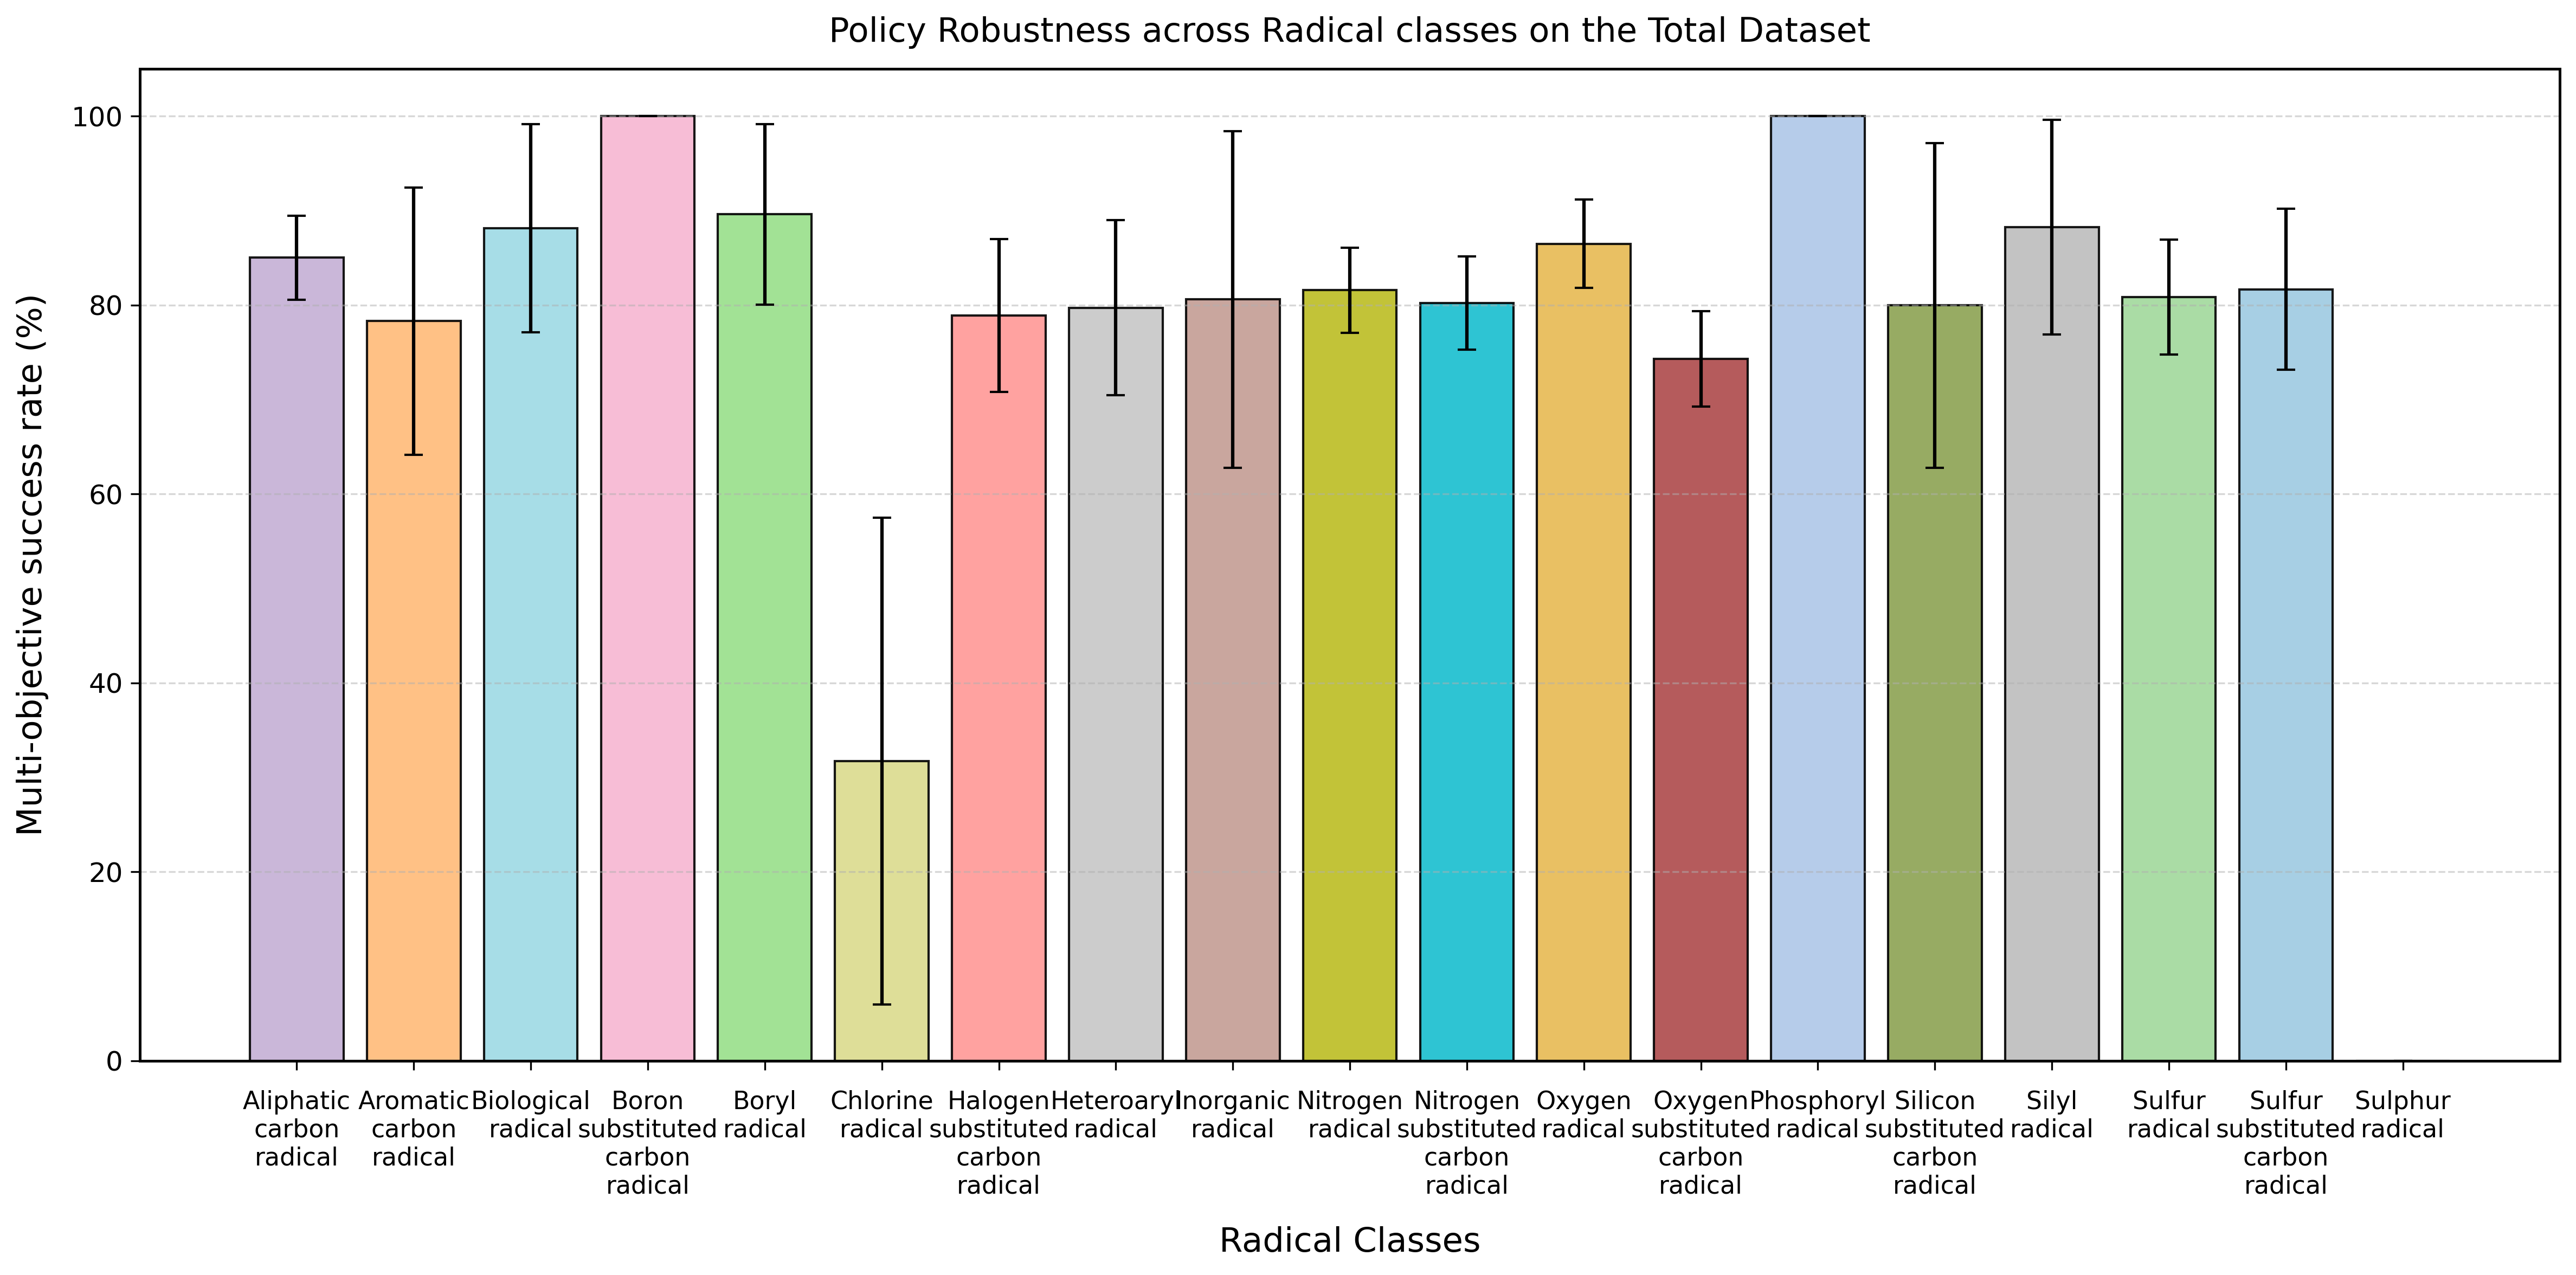

Saved → /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/classwise_multiobjective_success_percent_total_dataset.png


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import textwrap

# ============================================================
# PATHS
# ============================================================

BASE_DIR = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
VAL_CSV  = os.path.join(BASE_DIR, "dataset", "MERGED_CDFT_GLOBAL.csv")
CLASS_XLSX = os.path.join(BASE_DIR, "dataset", "Radical_Name_List-2.xlsx")
PLOTS_DIR = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# ============================================================
# CONSTANTS
# ============================================================

STATE_COLUMNS = [
    'Electronegativity','Hardness','Electrophilicity','q(N)',
    'f-','f+','f0','s-','s+','s0','s+/s-','s-/s+','s(2)'
]
IDX_FM, IDX_FP, IDX_F0 = 4, 5, 6

TARGET_OMEGA = 1.0
OMEGA_TOL    = 0.10
F_BOUNDS     = {'f-': (-1.0, 1.0), 'f+': (-1.0, 1.0), 'f0': (-1.0, 1.0)}

POS_CLIP, NEG_CLIP = 0.05, 0.05
HIGH_OMEGA_THRESH = 2.0

# ============================================================
# LOAD VALIDATION DATA
# ============================================================

val_df = pd.read_csv(VAL_CSV)

if "Radical name" not in val_df.columns:
    raise ValueError("val_dataset.csv must contain column 'Radical name'.")

val_df["Radical name"] = val_df["Radical name"].astype(str).str.strip()

# ============================================================
# LOAD CLASS MAP
# ============================================================

motif_df = pd.read_excel(CLASS_XLSX)
motif_df["Radical name"] = motif_df["Radical name"].astype(str).str.strip()
motif_df["Classification"] = motif_df["Classification"].astype(str).str.strip()

class_map = dict(zip(motif_df["Radical name"], motif_df["Classification"]))
val_df["class"] = val_df["Radical name"].map(class_map).fillna("unknown")

print("Class distribution in total dataset:")
print(val_df["class"].value_counts())

# ============================================================
# SCALER
# ============================================================

def _compute_val_scaler(val_csv):
    raw = pd.read_csv(val_csv)
    mu = raw[STATE_COLUMNS].mean(numeric_only=True)
    sd = raw[STATE_COLUMNS].std(numeric_only=True).replace(0.0, 1.0)
    return mu, sd

mu, sd = _compute_val_scaler(VAL_CSV)

def _unscale_feature(z, name):
    raw = float(z) * float(sd[name]) + float(mu[name])
    if name in ('f-','f+','f0'):
        raw = float(np.clip(raw, -1.0, 1.0))
    return raw

def bootstrap_rate(arr, n_boot=500):
    arr = np.asarray(arr, dtype=float)
    if len(arr) == 0:
        return np.nan, np.nan
    means = [np.mean(np.random.choice(arr, size=len(arr), replace=True)) for _ in range(n_boot)]
    return float(np.mean(means)), float(np.std(means))

# ============================================================
# RESET ENV
# ============================================================

def reset_env_to_val_row(env, i, row):
    state_vec = row[STATE_COLUMNS].to_numpy(dtype=np.float32)

    for fn in [
        lambda: env.reset(i),
        lambda: env.reset(index=i),
        lambda: env.reset(idx=i),
        lambda: env.reset_from_index(i),
        lambda: env.reset_from_row(row)
    ]:
        try:
            s = fn()
            if isinstance(s, np.ndarray):
                return s
        except Exception:
            pass

    if hasattr(env, "set_state"):
        env.set_state(state_vec)
        return state_vec

    if hasattr(env, "state"):
        env.state = state_vec
        return state_vec

    raise RuntimeError("Env cannot be reset to validation row.")

# ============================================================
# ROLLOUT
# ============================================================

@torch.no_grad()
def rollout_from_state(actor, env, init_state, max_steps=250):
    device = next(actor.parameters()).device
    s = init_state

    init_omega = float(init_state[STATE_COLUMNS.index("Electrophilicity")])
    last_omega = np.nan
    converged = False

    for _ in range(max_steps):
        st = torch.from_numpy(s).float().unsqueeze(0).to(device)
        raw = actor(st).item()
        a = raw*POS_CLIP if raw >= 0 else raw*NEG_CLIP
        s, _, done, info = env.step(a, pos_clip=POS_CLIP, neg_clip=NEG_CLIP)
        last_omega = float(info.get("omega", np.nan))
        converged = bool(done)
        if done:
            break

    return s, init_omega, last_omega, converged

# ============================================================
# MAIN
# ============================================================

def evaluate_classwise(actor, env, steps=250):

    records = []

    for i in range(len(val_df)):
        row = val_df.iloc[i]
        cls = row["class"]

        s0 = reset_env_to_val_row(env, i, row)
        s_final, init_omega, omega_final, converged = rollout_from_state(actor, env, s0, steps)

        fm = _unscale_feature(s_final[IDX_FM], "f-")
        fp = _unscale_feature(s_final[IDX_FP], "f+")
        f0 = _unscale_feature(s_final[IDX_F0], "f0")

        exp_hit = abs(omega_final - TARGET_OMEGA) <= OMEGA_TOL
        fukui_hit = (
            (fm >= F_BOUNDS["f-"][0]) & (fm <= F_BOUNDS["f-"][1]) &
            (fp >= F_BOUNDS["f+"][0]) & (fp <= F_BOUNDS["f+"][1]) &
            (f0 >= F_BOUNDS["f0"][0]) & (f0 <= F_BOUNDS["f0"][1])
        )
        multi_hit = exp_hit and fukui_hit

        records.append({
            "class": cls,
            "exp_hit": float(exp_hit),
            "fukui_hit": float(fukui_hit),
            "multi_hit": float(multi_hit),
            "converged": float(converged),
            "omega_final": omega_final
        })

    df = pd.DataFrame(records)

    print("\n=== Overall hit rates ===")
    print(df[["exp_hit","fukui_hit","multi_hit"]].mean())

    summary = []
    for cls, g in df.groupby("class"):
        exp_m, exp_s = bootstrap_rate(g["exp_hit"])
        fk_m,  fk_s  = bootstrap_rate(g["fukui_hit"])
        mh_m,  mh_s  = bootstrap_rate(g["multi_hit"])

        summary.append({
            "class": cls,
            "N": len(g),
            "exp_hit": exp_m, "exp_std": exp_s,
            "fukui_hit": fk_m, "fukui_std": fk_s,
            "multi_hit": mh_m, "multi_std": mh_s,
            "nonconv_frac": 1 - g["converged"].mean(),
            "high_omega_start_frac": float(np.mean(g["omega_final"] > HIGH_OMEGA_THRESH))
        })

    sum_df = pd.DataFrame(summary).sort_values("class")

    sum_df_pct = sum_df.copy()
    for col in ["exp_hit", "exp_std", "fukui_hit", "fukui_std", "multi_hit", "multi_std"]:
        sum_df_pct[col] *= 100.0

    out_csv = os.path.join(PLOTS_DIR, "classwise_success_rates_percent.csv")
    sum_df_pct.to_csv(out_csv, index=False)
    #print(out_csv)
    print(f"Saved → {out_csv}")

    fixed_colors = {
        "Phosphoryl radical": "#aec7e8",
        "Aromatic carbon radical": "#ffbb78",
        "Boryl radical": "#98df8a",
        "Halogen substituted carbon radical": "#ff9896",
        "Aliphatic carbon radical": "#c5b0d5",
    }

    pastel_pool = [
        "#9edae5","#f7b6d2","#dbdb8d","#c7c7c7","#c49c94",
        "#bcbd22","#17becf","#e7ba52","#ad494a","#8ca252",
        "#bdbdbd","#a1d99b","#9ecae1","#fdd0a2","#dadaeb",
        "#fdae6b","#bcbddc","#c6dbef","#f2b447","#c994c7"
    ]

    classes = list(sum_df_pct["class"])
    other_classes = [c for c in classes if c not in fixed_colors]
    other_classes_sorted = sorted(set(other_classes))

    other_color_map = {
        c: pastel_pool[i % len(pastel_pool)]
        for i, c in enumerate(other_classes_sorted)
    }

    colors = [
        fixed_colors[c] if c in fixed_colors else other_color_map.get(c, "#d9d9d9")
        for c in classes
    ]

    labels = [textwrap.fill(c, width=12) for c in classes]

    # ============================================================
    # PLOT (with extra whitespace)
    # ============================================================

    fig, ax = plt.subplots(figsize=(16,8), dpi=300)
    x = np.arange(len(sum_df_pct))

    ax.bar(
        x,
        sum_df_pct["multi_hit"],
        yerr=sum_df_pct["multi_std"],
        capsize=4,
        color=colors,
        edgecolor="black",
        alpha=0.9
    )

    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=11)
    ax.tick_params(axis='x', pad=9)

    ax.set_ylabel("Multi-objective success rate (%)", fontsize=15, labelpad=10)
    ax.set_xlabel("Radical Classes", fontsize=15, labelpad=12)

    ax.set_ylim(0, 105)
    ax.set_title(
        "Policy Robustness across Radical classes on the Total Dataset",
        fontsize=15,
        pad=12
    )

    ax.grid(True, axis="y", linestyle="--", alpha=0.5)

    plt.subplots_adjust(top=0.85, bottom=0.15)

    out_fig = os.path.join(PLOTS_DIR, "classwise_multiobjective_success_percent_total_dataset.png")
    plt.tight_layout()
    plt.savefig(out_fig, bbox_inches="tight")
    plt.show()
    print(f"Saved → {out_fig}")

    return df, sum_df_pct

# ============================================================
# RUN
# ============================================================

raw_df, summary_df = evaluate_classwise(actor, env, steps=250)


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# ============================================================
# Rank radicals using best validated TD3 actor (ω-gated scoring)
# ============================================================

BASE_DIR    = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
VAL_CSV     = os.path.join(BASE_DIR, "dataset", "val_dataset.csv")
RESULTS_DIR = os.path.join(BASE_DIR, "Results")
BEST_ACTOR  = os.path.join(RESULTS_DIR, "best_actor_td3_validated_5000.pth")

STATE_COLUMNS = [
    "Electronegativity","Hardness","Electrophilicity","q(N)",
    "f-","f+","f0","s-","s+","s0","s+/s-","s-/s+","s(2)"
]
IDX_OMEGA, IDX_FM, IDX_FP, IDX_F0 = 2, 4, 5, 6

TARGET_OMEGA, OMEGA_TOL = 1.0, 0.10
POS_CLIP, NEG_CLIP = 0.05, 0.05


# ============================================================
# Model
# ============================================================

def mlp(sizes, act_last=None):
    layers = []
    for i in range(len(sizes) - 2):
        layers += [nn.Linear(sizes[i], sizes[i+1]), nn.ReLU()]
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if act_last == "tanh":
        layers.append(nn.Tanh())
    return nn.Sequential(*layers)

class Actor(nn.Module):
    def __init__(self, state_dim, hidden):
        super().__init__()
        self.body = mlp([state_dim, hidden, hidden, 1], act_last="tanh")
    def forward(self, s):
        return self.body(s).squeeze(1)


# ============================================================
# Preprocess + Env
# ============================================================

def _safe_ratio(num, den, eps=1e-8):
    n = np.asarray(num, dtype=np.float64)
    d = np.asarray(den, dtype=np.float64)
    return n / (np.sign(d) * np.maximum(np.abs(d), eps))

def preprocess_dataframe(df: pd.DataFrame):
    df = df.copy()
    for c in STATE_COLUMNS:
        if c not in df.columns:
            df[c] = np.nan

    if "s+/s-" not in df.columns:
        df["s+/s-"] = _safe_ratio(df["s+"].fillna(0.0).values, df["s-"].fillna(1.0).values)
    if "s-/s+" not in df.columns:
        df["s-/s+"] = _safe_ratio(df["s-"].fillna(0.0).values, df["s+"].fillna(1.0).values)

    df[STATE_COLUMNS] = df[STATE_COLUMNS].apply(pd.to_numeric, errors="coerce")
    df[STATE_COLUMNS] = df[STATE_COLUMNS].ffill().bfill()

    df["f-"] = df["f-"].clip(-1, 1)
    df["f+"] = df["f+"].clip(-1, 1)
    df["f0"] = df["f0"].clip(-1, 1)
    df["Electrophilicity"] = df["Electrophilicity"].clip(0.0, 6.5)

    mu = df[STATE_COLUMNS].mean()
    sd = df[STATE_COLUMNS].std().replace(0.0, 1.0)

    df_scaled = df.copy()
    df_scaled[STATE_COLUMNS] = (df[STATE_COLUMNS] - mu) / sd
    return df_scaled.reset_index(drop=True), {"mu": mu, "sd": sd}

class ContinuousRadicalEnv:
    def __init__(self, df_scaled, scaler, target_omega=1.0, success_thr=0.02):
        self.df = df_scaled.reset_index(drop=True)
        self.state_columns = STATE_COLUMNS
        self.num_features = len(self.state_columns)
        self.mu = scaler["mu"]
        self.sd = scaler["sd"]
        self.target_omega = float(target_omega)
        self.success_thr = float(success_thr)
        self.omega_clip = (0.0, 6.5)
        self.high_omega_terminate = 5.0
        self.state = None
        self.idx = None

    def reset_idx(self, idx):
        self.idx = int(idx)
        self.state = self.df.loc[self.idx, self.state_columns].values.astype(np.float32)
        return self.state.copy()

    def unscale(self, val, name):
        m = float(self.mu[name])
        s = float(self.sd[name]) if float(self.sd[name]) != 0.0 else 1.0
        return s * float(val) + m

    def step(self, delta, pos_clip, neg_clip):
        s = self.state
        prev = self.unscale(s[IDX_OMEGA], "Electrophilicity")
        a = float(np.clip(float(delta), -float(neg_clip), +float(pos_clip)))
        new = float(np.clip(prev + a, *self.omega_clip))

        done = False
        if new >= self.high_omega_terminate:
            done = True
        if abs(new - self.target_omega) <= self.success_thr:
            done = True

        new_scaled = (new - float(self.mu["Electrophilicity"])) / (
            float(self.sd["Electrophilicity"]) if float(self.sd["Electrophilicity"]) != 0.0 else 1.0
        )
        ns = s.copy()
        ns[IDX_OMEGA] = float(new_scaled)
        self.state = ns
        return ns.copy(), {"omega": new, "delta": a, "done": done}


def load_best_model(hidden=128):
    raw_val = pd.read_csv(VAL_CSV)
    val_scaled, scaler = preprocess_dataframe(raw_val)
    env = ContinuousRadicalEnv(val_scaled, scaler, target_omega=TARGET_OMEGA, success_thr=0.02)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    actor = Actor(env.num_features, hidden=hidden).to(device)
    actor.load_state_dict(torch.load(BEST_ACTOR, map_location=device))
    actor.eval()
    return actor, env, raw_val


# ============================================================
# Evaluation helpers
# ============================================================

def omega_band_hit(omega):
    return abs(float(omega) - TARGET_OMEGA) <= OMEGA_TOL

def policy_rollout_final_state(actor, env, init_idx, steps=10):
    s = env.reset_idx(init_idx)
    device = next(actor.parameters()).device
    omega_final = env.unscale(s[IDX_OMEGA], "Electrophilicity")

    for _ in range(int(steps)):
        st = torch.from_numpy(s).float().unsqueeze(0).to(device)
        with torch.no_grad():
            raw = float(actor(st).item())
        a = raw * POS_CLIP if raw >= 0 else raw * NEG_CLIP
        s, info = env.step(a, pos_clip=POS_CLIP, neg_clip=NEG_CLIP)
        omega_final = float(info["omega"])
        if info.get("done", False) or omega_band_hit(omega_final):
            break
    return s, omega_final


# ============================================================
# Main (ω-gated scoring)
# ============================================================

if __name__ == "__main__":
    os.makedirs(RESULTS_DIR, exist_ok=True)

    actor, env, val_full = load_best_model(hidden=128)
    rows = []

    for idx in range(len(val_full)):
        fin_s, omega = policy_rollout_final_state(actor, env, idx, steps=10)

        f_m = env.unscale(fin_s[IDX_FM], "f-")
        f_p = env.unscale(fin_s[IDX_FP], "f+")
        f_0 = env.unscale(fin_s[IDX_F0], "f0")

        ω_flag = omega_band_hit(omega)
        fukui_score = float(np.exp(-abs(f_m)) + np.exp(-abs(f_p)) + np.exp(-abs(f_0)))

        # ===== ω-gated total score =====
        total_score = (1.0 + fukui_score) if ω_flag else 0.0

        rad_name = val_full.loc[idx, "Radical name"] if "Radical name" in val_full.columns else f"rad_{idx}"

        rows.append({
            "index": int(idx),
            "Radical name": str(rad_name),
            "ω": round(float(omega), 4),
            "f⁻": round(float(f_m), 4),
            "f⁺": round(float(f_p), 4),
            "f⁰": round(float(f_0), 4),
            "ω_hit": bool(ω_flag),
            "fukui_score": round(float(fukui_score), 4),
            "total_score": round(float(total_score), 4),
        })

    df = pd.DataFrame(rows)

    df_unique = (
        df.sort_values("total_score", ascending=False)
          .drop_duplicates(subset=["Radical name"], keep="first")
          .reset_index(drop=True)
    )

    top_df = df_unique.head(20)
    out_path = os.path.join(RESULTS_DIR, "top20_radicals_val_unique.csv")
    top_df.to_csv(out_path, index=False)

    print("Top 20 preview (ω-gated, unique Radical names):")
    print(top_df)
    print(f"Saved to: {out_path}")


Top 20 preview (ω-gated, unique Radical names):
    index                                       Radical name       ω      f⁻  \
0      29                              2phenylethyl_sulfanyl  1.0575  0.0106   
1      27                                ethoxydimethylsilyl  0.9445  0.0158   
2      35                                  22dimethyl_propyl  0.9355  0.0244   
3      13                                     3oxocyclohexyl  1.0881  0.0216   
4      87              14methylbenzenesulfonamido_pentan_3yl  1.0817  0.0195   
5      43                                 cyclohexylsulfanyl  1.0280  0.0304   
6      65                        3ethoxy_3oxopropyl_sulfanyl  1.0767  0.0320   
7      94                                    acetamidomethyl  0.9080  0.0225   
8      88                                           oxan_3yl  0.9408  0.0251   
9      60                                     4oxocyclohexyl  1.0678  0.0265   
10     12                             4methylphenyl_sulfanyl  1.0550  0.

In [ ]:
# Rank radicals using best validated TD3 actor (continuous Δω) from the merged dataset


BASE_DIR    = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
MERGED_CSV  = os.path.join(BASE_DIR, "dataset", "MERGED_CDFT_GLOBAL.csv")
RESULTS_DIR = os.path.join(BASE_DIR, "Results")
BEST_ACTOR  = os.path.join(RESULTS_DIR, "best_actor_td3_validated_5000.pth")

STATE_COLUMNS = [
    'Electronegativity','Hardness','Electrophilicity','q(N)',
    'f-','f+','f0','s-','s+','s0','s+/s-','s-/s+','s(2)'
]
IDX_OMEGA, IDX_FM, IDX_FP, IDX_F0 = 2, 4, 5, 6
TARGET_OMEGA, OMEGA_TOL = 1.0, 0.10
POS_CLIP, NEG_CLIP = 0.05, 0.05


# Model + preprocessing

def mlp(sizes, act_last=None):
    layers = []
    for i in range(len(sizes)-2):
        layers += [nn.Linear(sizes[i], sizes[i+1]), nn.ReLU()]
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if act_last == 'tanh': layers.append(nn.Tanh())
    return nn.Sequential(*layers)

class Actor(nn.Module):
    def __init__(self, state_dim, hidden):
        super().__init__()
        self.body = mlp([state_dim, hidden, hidden, 1], act_last='tanh')
    def forward(self, s): return self.body(s).squeeze(1)

def _safe_ratio(num, den, eps=1e-8):
    n = np.asarray(num, dtype=np.float64)
    d = np.asarray(den, dtype=np.float64)
    return n / (np.sign(den) * np.maximum(np.abs(den), eps))

def preprocess_dataframe(df: pd.DataFrame):
    for c in STATE_COLUMNS:
        if c not in df.columns:
            df[c] = np.nan
    if 's+/s-' not in df.columns:
        df['s+/s-'] = _safe_ratio(df.get('s+', 0.0), df.get('s-', 1.0))
    if 's-/s+' not in df.columns:
        df['s-/s+'] = _safe_ratio(df.get('s-', 0.0), df.get('s+', 1.0))
    df[STATE_COLUMNS] = df[STATE_COLUMNS].ffill().bfill()
    df['f-'] = df['f-'].clip(-1,1); df['f+'] = df['f+'].clip(-1,1); df['f0'] = df['f0'].clip(-1,1)
    df['Electrophilicity'] = df['Electrophilicity'].clip(0.0,6.5)
    mu = df.mean(numeric_only=True); sd = df.std(numeric_only=True).replace(0.0,1.0)
    df_scaled = (df - mu) / sd
    df_scaled['_omega_unscaled'] = df['Electrophilicity'].values.astype(np.float32)
    df_scaled['_omega_mu'] = mu['Electrophilicity']; df_scaled['_omega_sd'] = sd['Electrophilicity']
    return df_scaled.reset_index(drop=True)

class ContinuousRadicalEnv:
    def __init__(self, df_scaled, target_omega=1.0, success_thr=0.02, rmax=2.0, success_bonus=10.0):
        self.df = df_scaled.reset_index(drop=True)
        self.state_columns = STATE_COLUMNS; self.num_features = len(self.state_columns)
        self.target_omega = target_omega; self.success_thr = success_thr
        self.rmax = rmax; self.success_bonus = success_bonus
        self.omega_clip = (0.0,6.5); self.high_omega_terminate = 5.0; self.high_omega_penalty = -5.0
        self.state=None; self.idx=None
    def reset_idx(self, idx):
        self.idx = idx
        self.state = self.df.loc[self.idx, self.state_columns].values.astype(np.float32)
        self.row_cache = self.df.loc[self.idx]
        return self.state.copy()
    def step(self, delta,pos_clip,neg_clip):
        s=self.state; mu=float(self.row_cache['_omega_mu']); sd=float(self.row_cache['_omega_sd']); omega_scaled=float(s[IDX_OMEGA])
        prev=sd*omega_scaled+mu
        a=float(np.clip(delta,-neg_clip,+pos_clip))
        new=np.clip(prev+a,*self.omega_clip)
        done=False
        if new>=self.high_omega_terminate: done=True
        if abs(new-self.target_omega)<=self.success_thr: done=True
        new_scaled=(new-mu)/(sd if sd!=0 else 1.0); ns=s.copy(); ns[IDX_OMEGA]=new_scaled; self.state=ns
        return ns.copy(), {"omega":new,"delta":a}

def load_best_model():
    raw_va=pd.read_csv(MERGED_CSV)
    val_df=preprocess_dataframe(raw_va)
    env=ContinuousRadicalEnv(val_df,target_omega=1.0,success_thr=0.02)
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    actor=Actor(env.num_features,hidden=128).to(device)
    actor.load_state_dict(torch.load(BEST_ACTOR,map_location=device))
    actor.eval()
    return actor, env, raw_va


#Evaluation

def omega_band_hit(omega):
    return abs(omega - TARGET_OMEGA) <= OMEGA_TOL

def policy_rollout_final_state(actor, env, init_idx, steps=10):
    s = env.reset_idx(init_idx)
    device = next(actor.parameters()).device
    omega_final = None
    for _ in range(steps):
        st = torch.from_numpy(s).float().unsqueeze(0).to(device)
        with torch.no_grad():
            raw = actor(st).item()
            a = raw*POS_CLIP if raw>=0 else raw*NEG_CLIP
        s, info = env.step(a, pos_clip=POS_CLIP, neg_clip=NEG_CLIP)
        omega_final = info["omega"]
        if omega_final >= env.high_omega_terminate or abs(omega_final-TARGET_OMEGA)<=OMEGA_TOL:
            break
    return s, omega_final

# Main scoring loop

if __name__ == "__main__":
    actor, env, val_full = load_best_model()
    results_rows = []

    for idx in range(len(val_full)):
        fin_state, omega = policy_rollout_final_state(actor, env, idx, steps=10)
        f_m, f_p, f_0 = fin_state[IDX_FM], fin_state[IDX_FP], fin_state[IDX_F0]
        ω_flag = omega_band_hit(omega)
        fukui_score = float(np.exp(-abs(f_m)) + np.exp(-abs(f_p)) + np.exp(-abs(f_0)))
        total_score = (1.0 if ω_flag else 0.0) + fukui_score

        results_rows.append({
            "index": idx,
            "Radical name": val_full.loc[idx, "Radical name"] if "Radical name" in val_full.columns else f"rad_{idx}",
            "ω": round(float(omega), 4),
            "f⁻": round(float(f_m), 4),
            "f⁺": round(float(f_p), 4),
            "f⁰": round(float(f_0), 4),
            "ω_hit": bool(ω_flag),
            "fukui_score": round(fukui_score, 4),
            "total_score": round(total_score, 4)
        })

    df = pd.DataFrame(results_rows)
    df_unique_merged = (df.sort_values("total_score", ascending=False)
                   .drop_duplicates(subset=["Radical name"], keep="first")
                   .reset_index(drop=True))
    top_df_merged = df_unique_merged.head(20)

    top_path = os.path.join(RESULTS_DIR, "top20_radicals_merged_unique.csv")
    top_df_merged.to_csv(top_path, index=False)

    print("Top 20 preview (unique Radical names):")
    print(top_df_merged)
    print(f"Saved top-20 unique list to: {top_path}")


Top 20 preview (unique Radical names):
    index                               Radical name       ω      f⁻      f⁺  \
0     458   13dimethyl_2oxo_132diazaphospholidin_2yl  0.9654 -0.0022  0.0292   
1     483                               isochromanyl  0.9320  0.1090  0.0262   
2     456                              3chloropropyl  0.9866  0.1373 -0.0283   
3      86                              acenaphthenyl  1.0925 -0.1263 -0.0366   
4     223                             phenyloxidanyl  1.0732 -0.0324 -0.1297   
5      14  4dimethylamino_pyridin1ium_1yl_boranuidyl  0.9149  0.0955  0.0890   
6     227                                    linalyl  0.9082 -0.0582 -0.1279   
7     411                        diethoxyphosphoroso  0.9646  0.1476  0.0428   
8     177                              13dithian_2yl  0.9449  0.1020  0.0879   
9     284                      methoxy_phenyl_aminyl  1.0088  0.0338  0.1715   
10    181                        1-_furan-2-yl_ethyl  0.9119 -0.0845 -0.1250   
1


Validation Top-20 stats:
  ω within ±0.1 of target (ω=1.0) : 18/20
  all three Fukui ∈ [−1,1]               : 18/20
  BOTH criteria satisfied                : 16/20

Merged Top-20 stats:
  ω within ±0.1 of target (ω=1.0) : 20/20
  all three Fukui ∈ [−1,1]               : 20/20
  BOTH criteria satisfied                : 20/20


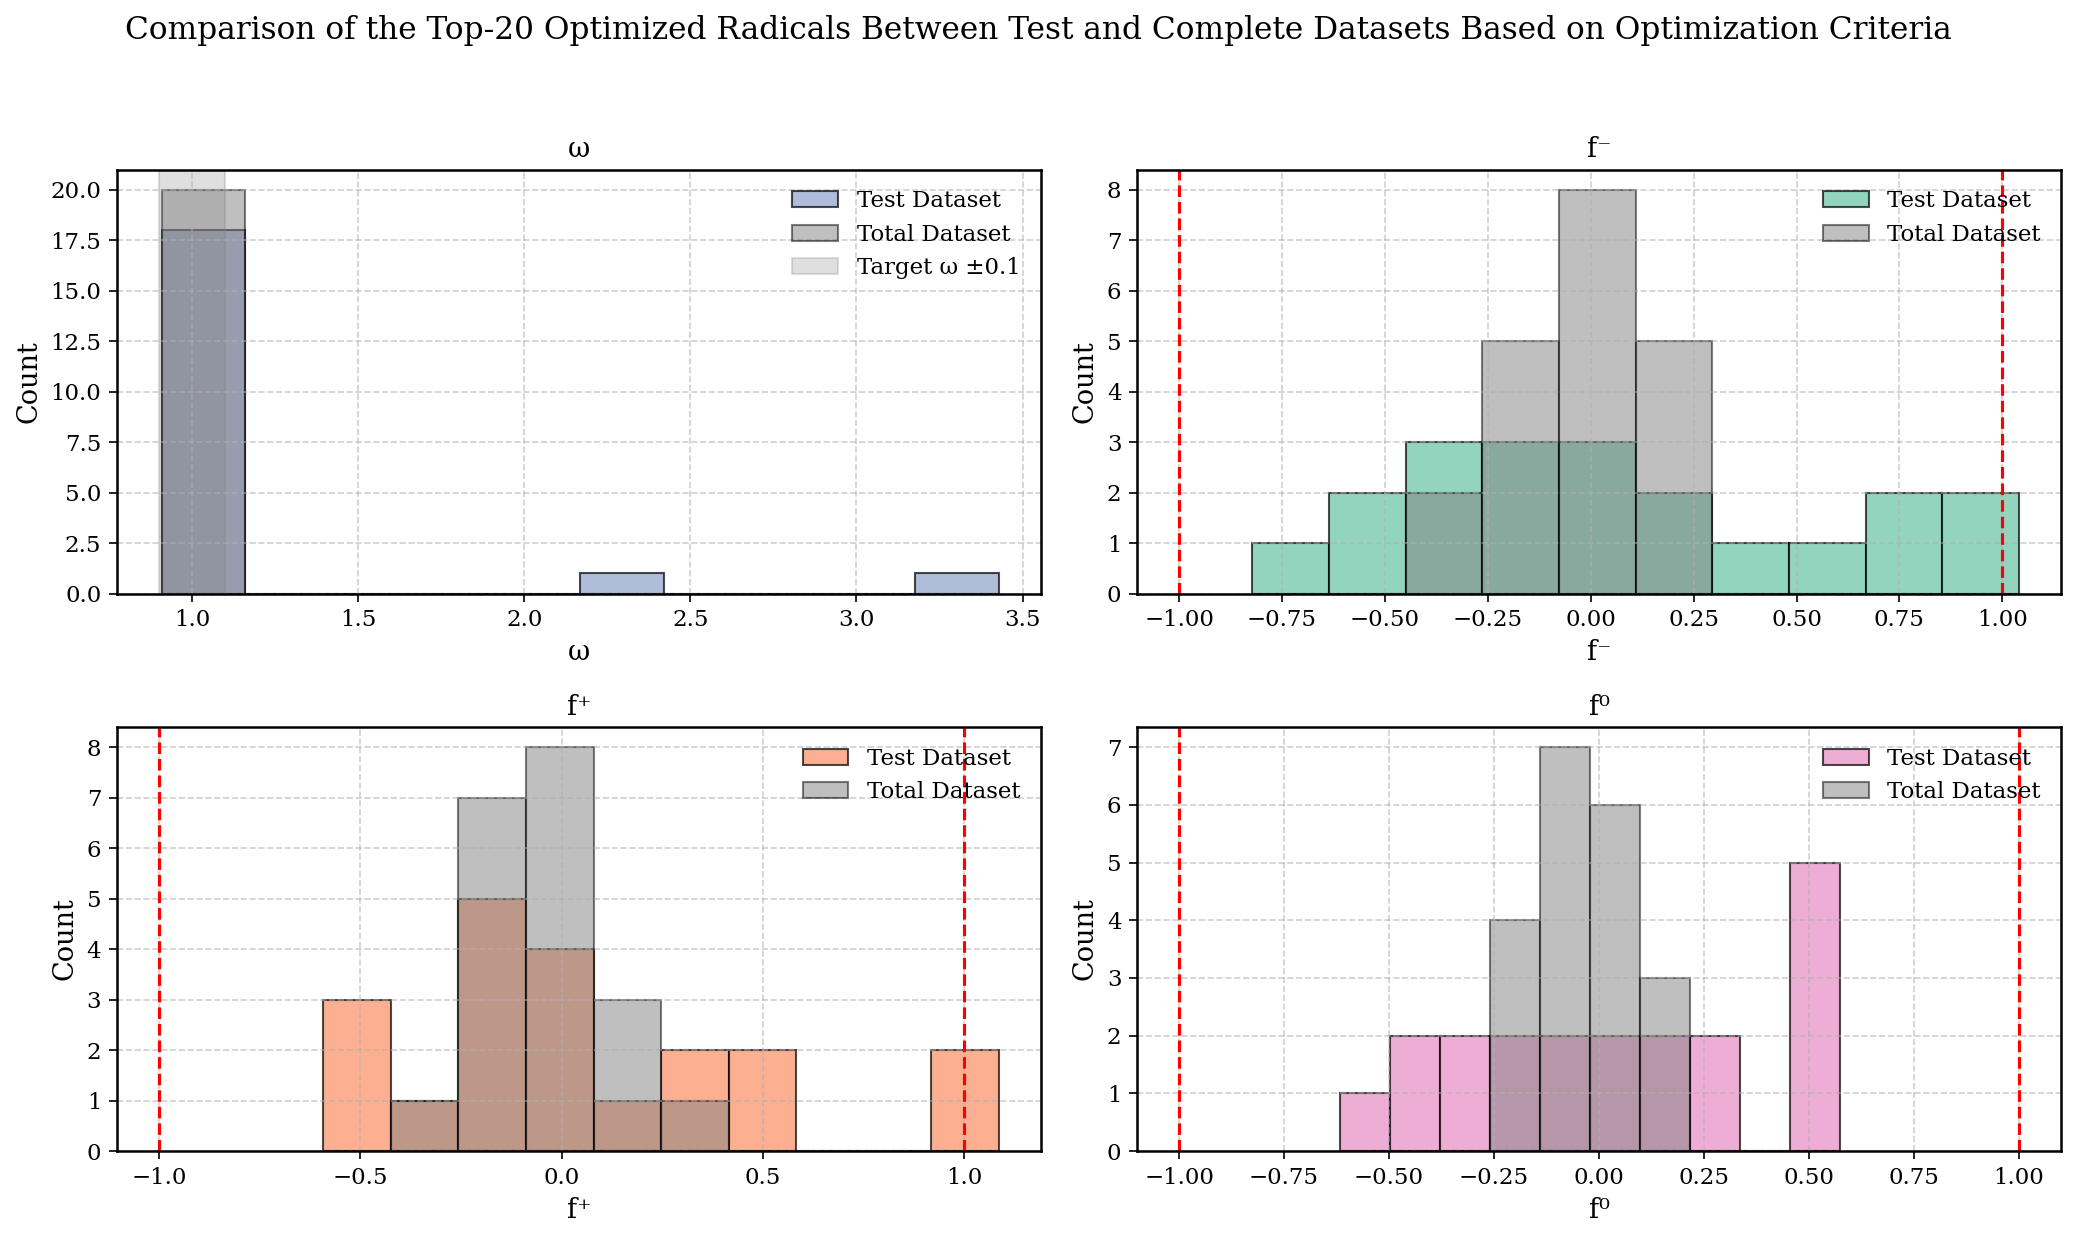


✔ Combined histogram saved → /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/top20_val_vs_merged_combined_pastel.png


In [ ]:
# Validation vs Merged Top-20 — stats + single combined comparison plot

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paths
BASE        = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
RESULT_DIR  = os.path.join(BASE, "Results")
PLOT_DIR    = os.path.join(BASE, "plots")
VAL_TOP20    = os.path.join(RESULT_DIR, "top20_radicals_val_unique.csv")
MERGED_TOP20 = os.path.join(RESULT_DIR, "top20_radicals_merged_unique.csv")
os.makedirs(PLOT_DIR, exist_ok=True)

#  Settings
OMEGA_TARGET = 1.0
OMEGA_TOL    = 0.10

# Helper Functions
def standardize_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Map possible alternate column names to canonical: ω, f⁻, f⁺, f⁰, ω_hit."""
    df = df.copy()
    rename_map = {}

    # omega
    if 'ω' not in df.columns:
        for alt in ['omega', 'Omega', 'Electrophilicity', 'ω_value']:
            if alt in df.columns:
                rename_map[alt] = 'ω'; break

    # f columns
    if 'f⁻' not in df.columns:
        for alt in ['f_minus', 'f-', 'fminus']:
            if alt in df.columns:
                rename_map[alt] = 'f⁻'; break
    if 'f⁺' not in df.columns:
        for alt in ['f_plus', 'f+', 'fplus']:
            if alt in df.columns:
                rename_map[alt] = 'f⁺'; break
    if 'f⁰' not in df.columns:
        for alt in ['f_zero', 'f0', 'fzero']:
            if alt in df.columns:
                rename_map[alt] = 'f⁰'; break

    df = df.rename(columns=rename_map)

    # Ensure numeric for key columns (ignore if missing)
    for c in ['ω','f⁻','f⁺','f⁰']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # ω_hit (optional in CSV) -> bool
    if 'ω_hit' in df.columns and df['ω_hit'].dtype != bool:
        df['ω_hit'] = df['ω_hit'].astype(str).str.strip().str.lower().isin(['1','true','t','yes','y'])

    return df

def compute_stats_vs_target(df: pd.DataFrame):
    """Counts for ω within target band, Fukui in [-1,1], BOTH."""
    N = len(df)
    omega_hit = (df['ω'].sub(OMEGA_TARGET).abs() <= OMEGA_TOL)
    fukui_hit = (df['f⁻'].abs() <= 1.0) & (df['f⁺'].abs() <= 1.0) & (df['f⁰'].abs() <= 1.0)
    both      = omega_hit & fukui_hit
    return {
        'N': N,
        'omega_hits': int(omega_hit.sum()),
        'fukui_hits': int(fukui_hit.sum()),
        'both_hits':  int(both.sum())
    }

def print_stats(label: str, stats: dict):
    N = stats['N']
    print(f"\n{label} Top-{N} stats:")
    print(f"  ω within ±{OMEGA_TOL} of target (ω=1.0) : {stats['omega_hits']}/{N}")
    print(f"  all three Fukui ∈ [−1,1]               : {stats['fukui_hits']}/{N}")
    print(f"  BOTH criteria satisfied                : {stats['both_hits']}/{N}")

#Load & standardize
val_df    = standardize_cols(pd.read_csv(VAL_TOP20))
merged_df = standardize_cols(pd.read_csv(MERGED_TOP20))

# Safety check: keep only rows with needed columns present
needed = ['ω','f⁻','f⁺','f⁰']
for name, df in [('Validation', val_df), ('Merged', merged_df)]:
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"{name} CSV missing columns: {missing}")

# Compute & print stats (like your old block)
val_stats    = compute_stats_vs_target(val_df)
merged_stats = compute_stats_vs_target(merged_df)
print_stats("Validation", val_stats)
print_stats("Merged",     merged_stats)

# One combined 2×2 overlay figure (pastel colors + grids)
plt.rcParams.update({
    "font.size": 12,
    "axes.linewidth": 1.2,
    "xtick.major.size": 4,
    "ytick.major.size": 4
})
fig, ax = plt.subplots(2, 2, figsize=(14, 8), dpi=150)
ax = np.array(ax).ravel()

# Pastel color scheme
panels = [
    ('ω',  "#8DA0CB", "ω"),   # pastel blue
    ('f⁻', "#66C2A5", "f⁻"),  # pastel teal
    ('f⁺', "#FC8D62", "f⁺"),  # pastel orange
    ('f⁰', "#E78AC3", "f⁰"),  # pastel pink
]

for i, (col, color, label) in enumerate(panels):
    combined = pd.concat([val_df[col], merged_df[col]], ignore_index=True).dropna()
    bins = np.histogram_bin_edges(combined, bins=10) if combined.nunique() > 1 else 10

    ax[i].hist(val_df[col].dropna(),    bins=bins, alpha=0.7, edgecolor="black",
               color=color, label="Test Dataset")
    ax[i].hist(merged_df[col].dropna(), bins=bins, alpha=0.5, edgecolor="black",
               color="gray", label="Total Dataset")

    if label == "ω":
        ax[i].axvspan(OMEGA_TARGET - OMEGA_TOL, OMEGA_TARGET + OMEGA_TOL,
                      color='gray', alpha=0.25, label=f"Target ω ±{OMEGA_TOL}")
    else:
        ax[i].axvline(-1, ls='--', c='red'); ax[i].axvline(1, ls='--', c='red')

    ax[i].set_title(label)
    ax[i].set_xlabel(label)
    ax[i].set_ylabel("Count")
    ax[i].legend(frameon=False)
    ax[i].grid(True, linestyle="--", alpha=0.6)

sup = (f"Comparison of the Top-20 Optimized Radicals Between Test and Complete Datasets Based on Optimization Criteria")

fig.suptitle(sup, fontsize=15, y=1.03)

plt.tight_layout()
out_path = os.path.join(PLOT_DIR, "top20_val_vs_merged_combined_pastel.png")
plt.savefig(out_path, bbox_inches="tight")
plt.show()
print(f"\n✔ Combined histogram saved → {out_path}")



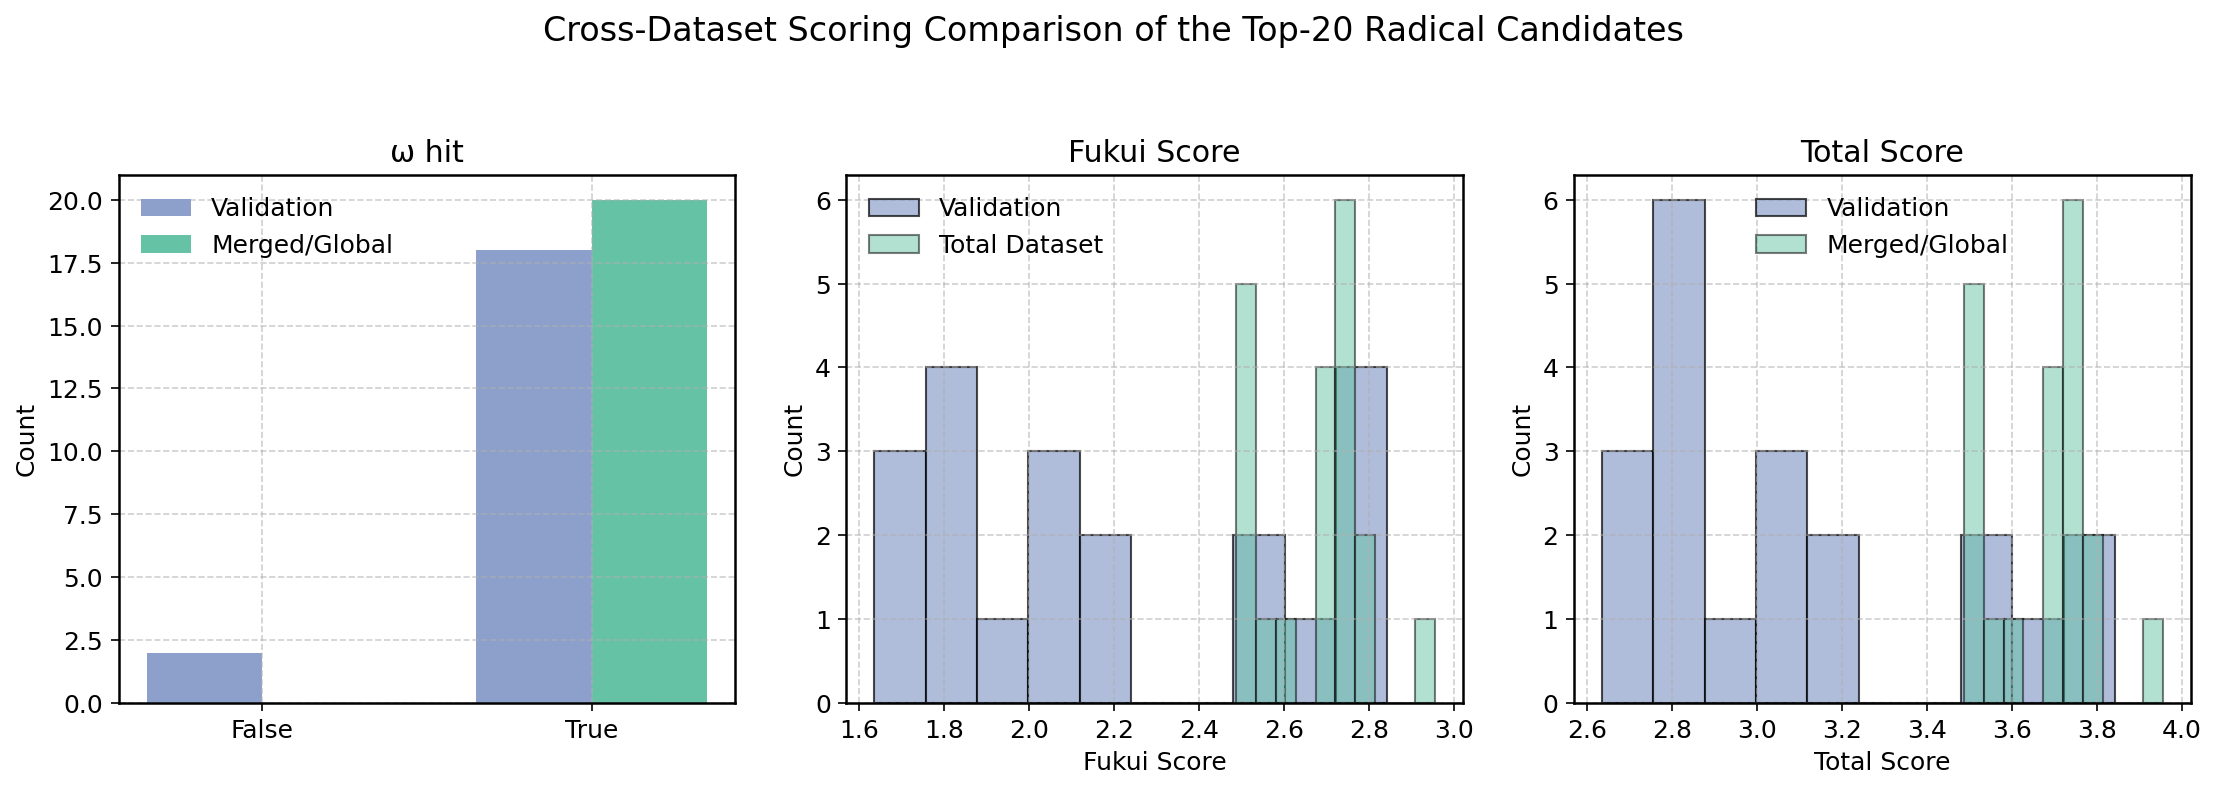

Metrics comparison plot saved → /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/top20_val_vs_merged_metrics.png


In [ ]:
#Comparison of Fukui score & Total score

# Paths
BASE       = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
RESULT_DIR = os.path.join(BASE, "Results")

val_path    = os.path.join(RESULT_DIR, "top20_radicals_val_unique.csv")
merged_path = os.path.join(RESULT_DIR, "top20_radicals_merged_unique.csv")

val_df    = pd.read_csv(val_path)
merged_df = pd.read_csv(merged_path)

# Plot
plt.rcParams.update({
    "font.size": 12,
    "axes.linewidth": 1.2,
    "xtick.major.size": 4,
    "ytick.major.size": 4
})

fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=150)

# Pastel color scheme
colors = {"Validation":"#8DA0CB", "Merged":"#66C2A5"}

#  ω_hit
val_counts    = val_df["ω_hit"].value_counts().reindex([False, True], fill_value=0)
merged_counts = merged_df["ω_hit"].value_counts().reindex([False, True], fill_value=0)

bar_width = 0.35
x = [0, 1]  # False, True
ax[0].bar([p - bar_width/2 for p in x], val_counts.values, width=bar_width,
          color=colors["Validation"], label="Validation")
ax[0].bar([p + bar_width/2 for p in x], merged_counts.values, width=bar_width,
          color=colors["Merged"], label="Merged/Global")
ax[0].set_xticks(x)
ax[0].set_xticklabels(["False", "True"])
ax[0].set_title("ω hit")
ax[0].set_ylabel("Count")
ax[0].legend(frameon=False)
ax[0].grid(True, linestyle="--", alpha=0.6)

#fukui_score
ax[1].hist(val_df["fukui_score"], bins=10, alpha=0.7, color=colors["Validation"],
           edgecolor="black", label="Validation")
ax[1].hist(merged_df["fukui_score"], bins=10, alpha=0.5, color=colors["Merged"],
           edgecolor="black", label="Total Dataset")
ax[1].set_title("Fukui Score")
ax[1].set_xlabel("Fukui Score")
ax[1].set_ylabel("Count")
ax[1].legend(frameon=False)
ax[1].grid(True, linestyle="--", alpha=0.6)

# total_score
ax[2].hist(val_df["total_score"], bins=10, alpha=0.7, color=colors["Validation"],
           edgecolor="black", label="Validation")
ax[2].hist(merged_df["total_score"], bins=10, alpha=0.5, color=colors["Merged"],
           edgecolor="black", label="Merged/Global")
ax[2].set_title("Total Score")
ax[2].set_xlabel("Total Score")
ax[2].set_ylabel("Count")
ax[2].legend(frameon=False)
ax[2].grid(True, linestyle="--", alpha=0.6)

fig.suptitle("Cross-Dataset Scoring Comparison of the Top-20 Radical Candidates", fontsize=16, y=1.05)

plt.tight_layout()
out_path = os.path.join(BASE, "plots", "top20_val_vs_merged_metrics.png")
plt.savefig(out_path, bbox_inches="tight")
plt.show()
print(f"Metrics comparison plot saved → {out_path}")



PLS Baseline (Validation set):
  Success rate (±0.02 band) : 3.1%
  Mean final |ω-1| distance : 0.5878


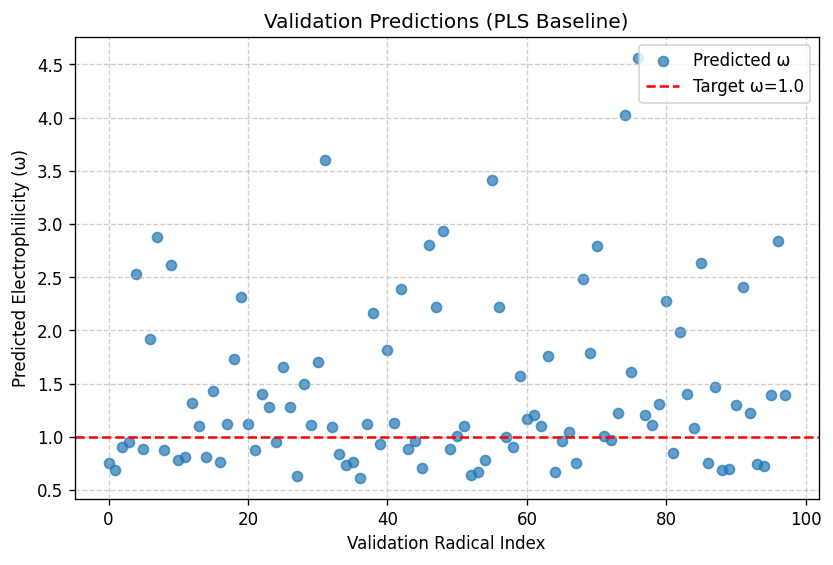

✔ Baseline plot saved → /content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset/plots/episode_trace_val_pls.png


In [ ]:
# -*- coding: utf-8 -*-
# Baseline: PLS Regression → evaluate on validation set
# Print success rate + mean |ω-1| distance
# Plot ω predictions (scatter) vs target ω=1.0

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

# -------------------------------
# Paths
# -------------------------------
BASE_DIR    = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
TRAIN_CSV   = os.path.join(BASE_DIR, "dataset", "train_dataset.csv")
VAL_CSV     = os.path.join(BASE_DIR, "dataset", "val_dataset.csv")
RESULTS_DIR = os.path.join(BASE_DIR, "Results")
PLOTS_DIR   = os.path.join(BASE_DIR, "plots")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# -------------------------------
# Settings
# -------------------------------
STATE_COLUMNS = [
    'Electronegativity','Hardness','Electrophilicity','q(N)',
    's-','s+','s0','s+/s-','s-/s+','s(2)'
]
TARGET_COLUMNS = ['Electrophilicity','f-','f+','f0']

TARGET_OMEGA = 1.0
SUCCESS_THR  = 0.02   # strict band ±0.02

# -------------------------------
# Load datasets
# -------------------------------
df_train = pd.read_csv(TRAIN_CSV)
df_val   = pd.read_csv(VAL_CSV)

X_train = df_train[STATE_COLUMNS].values
Y_train = df_train[TARGET_COLUMNS].values
X_val   = df_val[STATE_COLUMNS].values
Y_val   = df_val[TARGET_COLUMNS].values

# -------------------------------
# Train PLS
# -------------------------------
pls = PLSRegression(n_components=5)
pls.fit(X_train, Y_train)

# -------------------------------
# Predict on validation
# -------------------------------
Y_pred = pls.predict(X_val)

# Extract ω predictions
omega_pred = Y_pred[:,0]

# -------------------------------
# Success stats
# -------------------------------
success_flags = np.abs(omega_pred - TARGET_OMEGA) <= SUCCESS_THR
distances     = np.abs(omega_pred - TARGET_OMEGA)

success_rate = success_flags.mean()
mean_distance = distances.mean()

print("\nPLS Baseline (Validation set):")
print(f"  Success rate (±0.02 band) : {success_rate*100:.1f}%")
print(f"  Mean final |ω-1| distance : {mean_distance:.4f}")

# -------------------------------
# Plot ω predictions (scatter)
# -------------------------------
fig, ax = plt.subplots(figsize=(8,5), dpi=120)
ax.scatter(range(len(omega_pred)), omega_pred, c="tab:blue", label="Predicted ω", alpha=0.7)
ax.axhline(TARGET_OMEGA, ls="--", color="red", label="Target ω=1.0")

ax.set_xlabel("Validation Radical Index")
ax.set_ylabel("Predicted Electrophilicity (ω)")
ax.set_title("Validation Predictions (PLS Baseline)")
ax.legend()
ax.grid(True, ls="--", alpha=0.6)

out_path = os.path.join(PLOTS_DIR, "episode_trace_val_pls.png")
plt.savefig(out_path, bbox_inches="tight")
plt.show()
print(f"✔ Baseline plot saved → {out_path}")


## EXTENTION

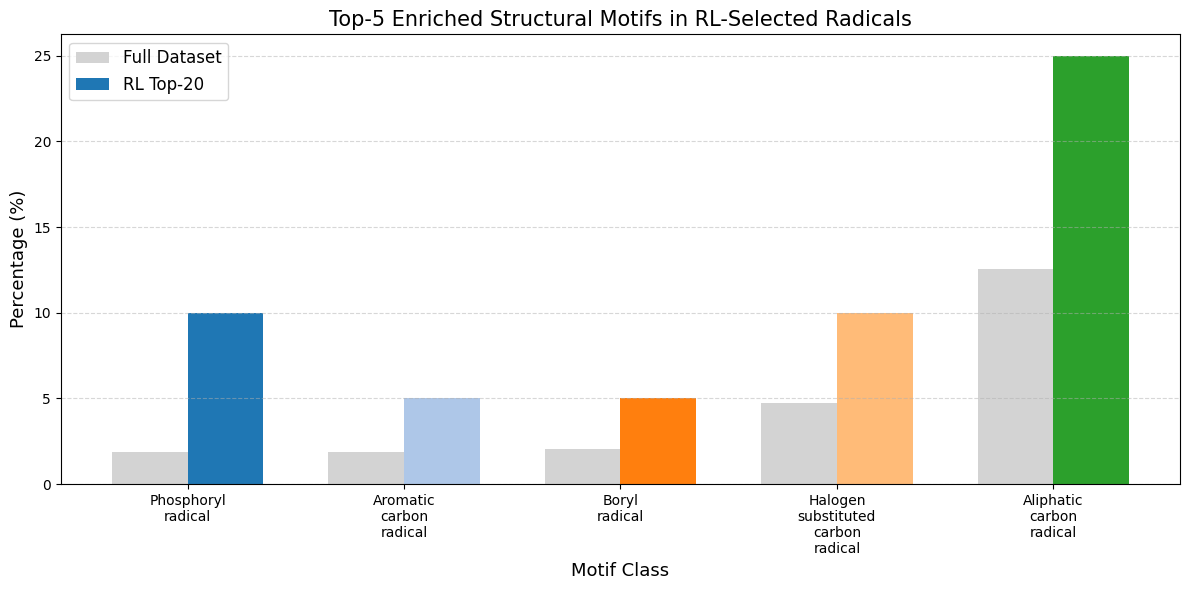

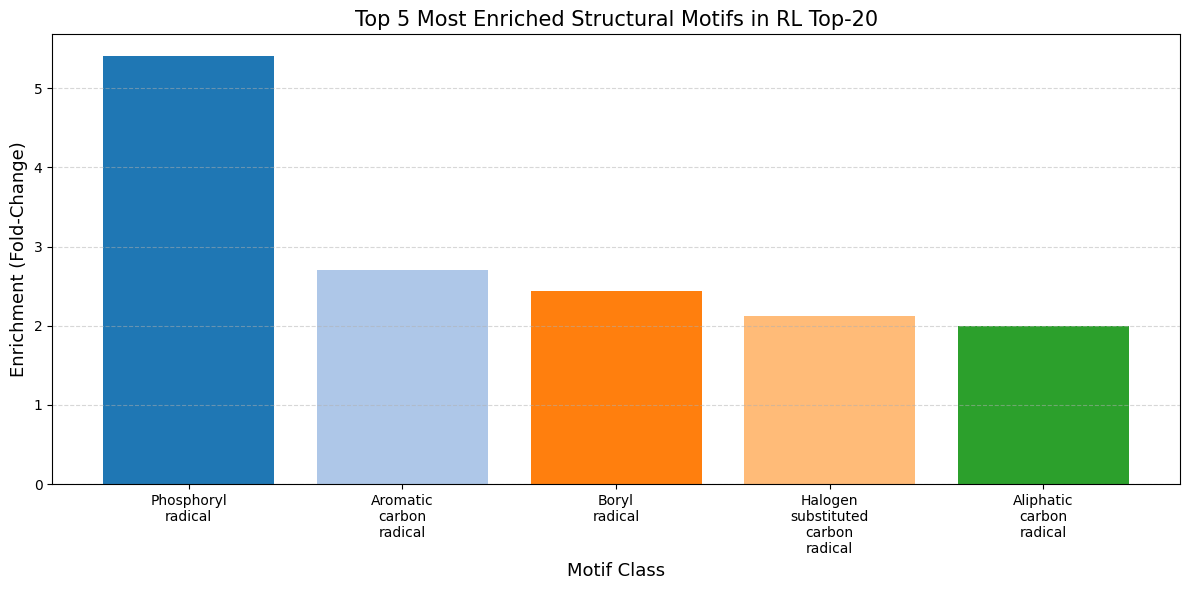

In [ ]:
#!/usr/bin/env python3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import textwrap

# =============================
# PATHS
# =============================
BASE = "/content/drive/MyDrive/RL_radical_dft/RL_radical_new_dataset"
RESULT_DIR = os.path.join(BASE, "Results")

ENRICH_FILE = os.path.join(RESULT_DIR, "motif_enrichment_full_vs_top20.csv")

# =============================
# LOAD DATA
# =============================
df = pd.read_csv(ENRICH_FILE)

# Sort by enrichment (descending) and select top-5
df_top5 = df.sort_values("enrichment", ascending=False).head(5)

motifs_raw = df_top5["motif_class"].astype(str)
full_pct = df_top5["pct_full"] * 100
top20_pct = df_top5["pct_top20"] * 100
enrichment = df_top5["enrichment"]

# Convert labels into two-line form using textwrap
motifs = [textwrap.fill(label, width=12) for label in motifs_raw]

# Use distinct colors for each motif
cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in range(len(df_top5))]

# =============================
# PLOT 1 — DISTRIBUTION (FULL vs TOP-20)
# =============================
x = np.arange(len(motifs))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, full_pct, width, label="Full Dataset", color="lightgray")
plt.bar(x + width/2, top20_pct, width, label="RL Top-20", color=colors)

plt.ylabel("Percentage (%)", fontsize=13)
plt.xlabel("Motif Class", fontsize=13)
plt.title("Top-5 Enriched Structural Motifs in RL-Selected Radicals", fontsize=15)

plt.xticks(x, motifs)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


# =============================
# PLOT 2 — ENRICHMENT BARPLOT
# =============================
plt.figure(figsize=(12, 6))
plt.bar(motifs, enrichment, color=colors)

plt.ylabel("Enrichment (Fold-Change)", fontsize=13)
plt.xlabel("Motif Class", fontsize=13)
plt.title("Top 5 Most Enriched Structural Motifs in RL Top-20", fontsize=15)

plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()
